In [ ]:
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from itertools import combinations
from IPython.display import display
from pathlib import Path
from lifelines.statistics import proportional_hazard_test
from lifelines.statistics import multivariate_logrank_test
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines.utils import restricted_mean_survival_time
from typing import List, Tuple, Dict, Optional
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from lifelines.utils import concordance_index
from matplotlib.lines import Line2D
from sklearn.ensemble import GradientBoostingClassifier
import re
import os
import warnings

In [2]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings('ignore')


script_dir = Path.cwd()

basePath = script_dir.parent

baseTablePath = script_dir.parent/"caselistingmatrix.csv"


In [3]:
df_main = pd.read_csv(baseTablePath)
df_main.head()

,"Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",Sex,Year of diagnosis,Summary stage 2000 (1998-2017),Radiation recode,"Chemotherapy recode (yes, no/unk)",Site specific surgery (1973-1997 varying detail by year and site),Breslow Tumor Thickness (2018+),Gleason Patterns Pathological Recode (2010+),Lymph Node Size Recode (2010+),Measured Basal Diameter Recode (2010+),Measured Thickness Recode (2010+),Response to Neoadjuvant Therapy Recode (2010+),Tumor Size Over Time Recode (1988+),Tumor Size Summary (2016+),ER Status Recode Breast Cancer (1990+),Breast Subtype (2010+),PR Status Recode Breast Cancer (1990+),HER2 Overall Summary Recode (2018+),Estrogen Receptor Summary (2018+),Progesterone Receptor Summary (2018+),Tumor marker 1 (1990-2003),Tumor marker 2 (1990-2003),Tumor marker 3 (1998-2003),SEER cause-specific death classification,Survival months,Vital status recode (study cutoff used),Total number of in situ/malignant tumors for patient,Total number of benign/borderline tumors for patient,Year of follow-up recode,Median household income inflation adj to 2023,Rural-Urban Continuum Code,"Age recode (<60,60-69,70+)"
0,Non-Hispanic White,Female,2003,Regional,None/Unknown,No/Unknown,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),27,Blank(s),Positive,Recode not available,Negative,Blank(s),Blank(s),Blank(s),1,2,Blank(s),Dead (attributable to this cancer dx),14,Dead,3,0,2004,"$110,000 - $119,999",Counties in metropolitan areas ge 1 million pop,75-79 years
1,Non-Hispanic Black,Female,2010,Localized,Beam radiation,No/Unknown,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Neoadjuvant therapy not given,80,Blank(s),Negative,HR-/HER2-,Negative,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Alive or dead of other cause,12,Dead,3,0,2011,"$90,000 - $94,999",Counties in metropolitan areas ge 1 million pop,70-74 years
2,Non-Hispanic White,Female,2018,Blank(s),Beam radiation,Yes,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Neoadjuvant therapy not given,24,24,Negative,HR-/HER2-,Negative,HER2 negative; equivocal,ER negative,PR negative,Blank(s),Blank(s),Blank(s),Alive or dead of other cause,59,Alive,2,0,2022,"$120,000+",Counties in metropolitan areas ge 1 million pop,70-74 years
3,Non-Hispanic White,Female,2005,Regional,None/Unknown,No/Unknown,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),11,Blank(s),Positive,Recode not available,Negative,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Dead (attributable to this cancer dx),81,Dead,2,0,2012,"$100,000 - $109,999",Counties in metropolitan areas ge 1 million pop,60-64 years
4,Non-Hispanic White,Female,2005,Regional,None/Unknown,No/Unknown,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),49,Blank(s),Negative,Recode not available,Negative,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Alive or dead of other cause,7,Dead,2,0,2005,"$100,000 - $109,999",Counties in metropolitan areas ge 1 million pop,70-74 years


## Data Preprocessing

In [4]:
df  = df_main[(df_main['ER Status Recode Breast Cancer (1990+)']== 'Positive')& (df_main['PR Status Recode Breast Cancer (1990+)']== 'Positive') & 
(df_main["Breast Subtype (2010+)"].apply(lambda x: "HER2+" in str(x)))]

df.drop(columns = ['ER Status Recode Breast Cancer (1990+)', 'Breast Subtype (2010+)', 'PR Status Recode Breast Cancer (1990+)', 
'HER2 Overall Summary Recode (2018+)', 'Estrogen Receptor Summary (2018+)', 'Progesterone Receptor Summary (2018+)'], inplace = True)

# df = df[df["Year of diagnosis"]>2007]
col=[]

for i in df.columns:
    df_col=df[i].value_counts().reset_index()
    indices = df_col[df_col[i]== "Blank(s)"]["count"]
    if len(indices) > 0 and (indices.iloc[0] /len(df)) * 1.0 >0.90:
        col.append(i)
df.drop(columns=col, inplace=True)
print("Columns with more than 90% blanks removed:", col)
# df = df.replace(to_replace=r"Blank.*", value=np.nan, regex=True)

df["event"] = df["Vital status recode (study cutoff used)"].apply(lambda x: 1 if x == "Dead" else 0)
df = df[df["Survival months"]!="Unknown"]
df["Survival months"] = df["Survival months"].astype(int)

df= df[df["Sex"]=="Female"]
df.drop(columns=["Vital status recode (study cutoff used)","Sex"], inplace=True)

# Sex
# Female    25072
# Male        232

Columns with more than 90% blanks removed: ['Site specific surgery (1973-1997 varying detail by year and site)', 'Breslow Tumor Thickness (2018+)', 'Gleason Patterns Pathological Recode (2010+)', 'Lymph Node Size Recode (2010+)', 'Measured Basal Diameter Recode (2010+)', 'Measured Thickness Recode (2010+)', 'Tumor marker 1 (1990-2003)', 'Tumor marker 2 (1990-2003)', 'Tumor marker 3 (1998-2003)']


In [5]:
df["Race"] = df["Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)"].map(
    {'Non-Hispanic White': 'NHW', 'Hispanic (All Races)': 'Hispanic', 
     'Non-Hispanic Asian or Pacific Islander': "NHAPI", 'Non-Hispanic Black': 'NHB', 
     'Non-Hispanic American Indian/Alaska Native': "NHAIAN", 'Non-Hispanic Unknown Race': "Unknown"}
)
df["Race_original"] = df["Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)"]

mapping = {
    "Counties in metropolitan areas ge 1 million pop": "Large Metro",
    "Counties in metropolitan areas of 250,000 to 1 million pop": "Medium/Small Metro",
    "Counties in metropolitan areas of lt 250 thousand pop": "Medium/Small Metro",
    "Nonmetropolitan counties adjacent to a metropolitan area": "Rural",
    "Nonmetropolitan counties not adjacent to a metropolitan area": "Rural",
    "Unknown/missing/no match/Not 1990-2023": "Unknown",
    "Unknown/missing/no match (Alaska or Hawaii - Entire State)": "Unknown"
}

df["County_Grouped"] = df["Rural-Urban Continuum Code"].map(mapping)

def age_group(age_str):
    if '+' in age_str:
        lower_age = int(age_str.split('+')[0])
    else:
        lower_age = int(age_str.split('-')[0])
    
    if lower_age < 40:
        return '<40'
    elif 40 <= lower_age <= 59:
        return '40-59'
    elif 60 <= lower_age <= 69:
        return '60-69'
    elif 70 <= lower_age <= 79:
        return '70-79'
    else:
        return '80+'

df['Age_Group_Broad'] = df['Age recode (<60,60-69,70+)'].apply(age_group)



def income_group(income_str):
    if income_str in ['Unknown/missing/no match/Not 1990-2023', None]:
        return 'Unknown'
    
    income_str = income_str.replace('$', '').replace(',', '').strip()
    
    if '<' in income_str:
        return '< $60,000'
    elif '-' in income_str:
        low, high = income_str.split('-')
        low = int(low.strip())
        high = int(high.strip())
        if high < 60000:
            return '< $60,000'
        elif 60000 <= low <= 79999:
            return '$60,000 - $79,999'
        elif 80000 <= low <= 99999:
            return '$80,000 - $99,999'
        elif 100000 <= low <= 119999:
            return '$100,000 - $119,999'
        else:
            return '>= $120,000'
    elif '+' in income_str:
        return '>= $120,000'
    else:
        return 'Unknown'

df['Income_Broad'] = df['Median household income inflation adj to 2023'].apply(income_group)


In [6]:
def tumor_size_bin_granular(val):
    try:
        code = int(str(val)[:3])
        if code == 0:
            return "No Tumor"
        elif code == 990:
            return "0-5 mm (T1a)"
        elif 1 <= code <= 5:
            return "0-5 mm (T1a)"
        elif 6 <= code <= 10:
            return "6-10 mm (T1b)"
        elif 11 <= code <= 20:
            return "11-20 mm (T1c)"
        elif 21 <= code <= 30:
            return "21-30 mm (T2a)"
        elif 31 <= code <= 50:
            return "31-50 mm (T2b)"
        elif 51 <= code <= 100:
            return "51-100 mm (T3)"
        elif 101 <= code <= 400:
            return ">100 mm (T4+)"
        else:
            return "Unknown"
    except:
        val = str(val).lower()
        if '998' in val or 'not consistent' in val:
            return "Unknown"
        elif 'unknown' in val or 'unreasonable' in val:
            return 'Unknown'
        else:
            return 'Unknown'
def tumor_size_bin_overview(val):
    try:
        code = int(str(val)[:3])
        if code == 0:
            return "No Tumor"
        elif code == 990:
            return "Tiny (≤10 mm)"
        elif 1 <= code <= 10:
            return "Tiny (≤10 mm)"
        elif 11 <= code <= 20:
            return "Small (11-20 mm)"
        elif 21 <= code <= 50:
            return "Medium (21-50 mm)"
        elif 51 <= code <= 100:
            return "Large (51-100 mm)"
        elif 101 <= code <= 400:
            return "Very Large (>100 mm)"
        else:
            return "Unknown"
    except:
        val = str(val).lower()
        if '998' in val or 'not consistent' in val:
            return "Unknown"
        elif 'unknown' in val or 'unreasonable' in val:
            return 'Unknown'
        else:
            return 'Unknown'
        
def tumor_size_numeric(val):
    try:
        code = int(str(val)[:3])
        if code == 0:
            return "Unknown"
        elif code == 990:
            return 1
        elif code < 400:
            return code
        else:
            return "Unknown"
    except:
        return 'Unknown'


df['Tumor_Size_OverTime_Granular'] = df['Tumor Size Over Time Recode (1988+)'].apply(tumor_size_bin_granular)
df['Tumor_Size_OverTime_Overview'] = df['Tumor Size Over Time Recode (1988+)'].apply(tumor_size_bin_overview)
df["Tumor_Size_OverTime_Numeric"] = df["Tumor Size Over Time Recode (1988+)"].apply(tumor_size_numeric)

df['Tumor_Size_Summary_Granular'] = df['Tumor Size Summary (2016+)'].apply(tumor_size_bin_granular)
df['Tumor_Size_Summary_Overview'] = df['Tumor Size Summary (2016+)'].apply(tumor_size_bin_overview)
df["Tumor_Size_Summary_Numeric"] = df["Tumor Size Summary (2016+)"].apply(tumor_size_numeric)


def group_malignant(n):
    if n == 1:
        return "1 Tumor"
    elif n == 2:
        return "2 Tumors"
    else:
        return "3+ Tumors"

df["Malignant_tumor_cnt"] = df["Total number of in situ/malignant tumors for patient"]
df["Benign_tumor_cnt"] = df["Total number of benign/borderline tumors for patient"]

df["Total number of in situ/malignant tumors for patient"] = df["Total number of in situ/malignant tumors for patient"].apply(group_malignant)
df["Total number of benign/borderline tumors for patient"] = df["Total number of benign/borderline tumors for patient"].apply(lambda x: "0 Tumors" if x == 0 else "≥1 Tumors")

df.drop(columns=['Median household income inflation adj to 2023','Age recode (<60,60-69,70+)',"Rural-Urban Continuum Code","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",
                 "Tumor Size Over Time Recode (1988+)","Tumor Size Summary (2016+)"], inplace=True)


In [7]:
df['Summary stage 2000 (1998-2017)'] = df['Summary stage 2000 (1998-2017)'].replace({
    'Unknown/unstaged': 'Unknown'
})

df.loc[df["Chemotherapy recode (yes, no/unk)"] == "No/Unknown","Chemotherapy recode (yes, no/unk)"] = "No"

radiation_mapping = {
    'Beam radiation': 'Beam',
    'Radioactive implants (includes brachytherapy) (1988+)': 'Other',
    'Combination of beam with implants or isotopes': 'Other',
    'Radioisotopes (1988+)': 'Other',
    'Refused (1988+)': 'Refused',
    'Recommended, unknown if administered': 'Unknown',
    'Radiation, NOS  method or source not specified': 'Unknown',
    'None/Unknown': 'Unknown'
}

radiation_mapping_comb = {
    'Beam radiation': 'Beam',
    'Radioactive implants (includes brachytherapy) (1988+)': 'implants',
    'Combination of beam with implants or isotopes': 'Comb',
    'Radioisotopes (1988+)': 'isotopes',
    'Refused (1988+)': 'Refused',
    'Recommended, unknown if administered': 'Unknown',
    'Radiation, NOS  method or source not specified': 'Unknown',
    'None/Unknown': 'Unknown'
}

df["Radiation_original"] = df['Radiation recode'].map(radiation_mapping_comb).fillna('Unknown')

df['Radiation recode'] = df['Radiation recode'].map(radiation_mapping).fillna('Unknown')


df['Response to Neoadjuvant Therapy Recode (2010+)'] = df['Response to Neoadjuvant Therapy Recode (2010+)'].replace({
    'Neoadjuvant therapy not given': 'Not Given',
    'Not documented; Not assessed or unknown if assessed': 'Unknown',
    'Not applicable: Information not collected for this case': 'Unknown',
    'Stated as response to treatment, but not noted if complete or partial': 'Unknown',
    'Stated as partial response (PR)': 'PR',
    'Stated as complete response (CR)': 'CR',
    'Stated as no response (NR)': 'NR'
}).fillna('Unknown')


column_rename_map = {
    'Summary stage 2000 (1998-2017)': 'SummaryStage_98_17',
    'Radiation recode': 'Radiation',
    'Chemotherapy recode (yes, no/unk)': 'Chemo',
    'Response to Neoadjuvant Therapy Recode (2010+)': 'NeoadjuvantResponse_10',
    'Total number of in situ/malignant tumors for patient': 'NumMalignantTumors',
    'Total number of benign/borderline tumors for patient': 'NumBenignTumors'
}

df.rename(columns=column_rename_map, inplace=True)

In [8]:
def fill_overtime_from_summary(
    df,
    overtime_col,
    summary_col,
    unknown_tokens=("Unknown")
):
    dfx = df.copy()

    # dfx[overtime_col] = dfx[overtime_col].replace(list(unknown_tokens), np.nan)
    # dfx[summary_col] = dfx[summary_col].replace(list(unknown_tokens), np.nan)

    mask_fill = (dfx[overtime_col]=="Unknown") & (dfx[summary_col]!= "Unknown")
    changed = int(mask_fill.sum())
    dfx.loc[mask_fill, overtime_col] = dfx.loc[mask_fill, summary_col]

    dfx[overtime_col] = dfx[overtime_col].fillna(unknown_tokens[0])
    dfx[summary_col] = dfx[summary_col].fillna(unknown_tokens[0])


    return dfx, {
        "filled_rows": changed,
        "overtime_unknown_after": int((dfx[overtime_col] == unknown_tokens[0]).sum())
    }

# df, stats = fill_overtime_from_summary(df)
df,stats = fill_overtime_from_summary(df,overtime_col="Tumor_Size_OverTime_Overview",summary_col="Tumor_Size_Summary_Overview")
df,stats = fill_overtime_from_summary(df,overtime_col="Tumor_Size_OverTime_Numeric",summary_col="Tumor_Size_Summary_Numeric")
df,stats = fill_overtime_from_summary(df,overtime_col="Tumor_Size_OverTime_Granular",summary_col="Tumor_Size_Summary_Granular")
df.rename(columns={"Tumor_Size_OverTime_Overview":"Tumor_Size_Overview","Tumor_Size_OverTime_Granular": "Tumor_Size_Granular", "Tumor_Size_OverTime_Numeric": "Tumor_Size_Numeric"}, inplace=True)

df.drop(columns =["Tumor_Size_Summary_Overview","Tumor_Size_Summary_Numeric"], inplace=True)

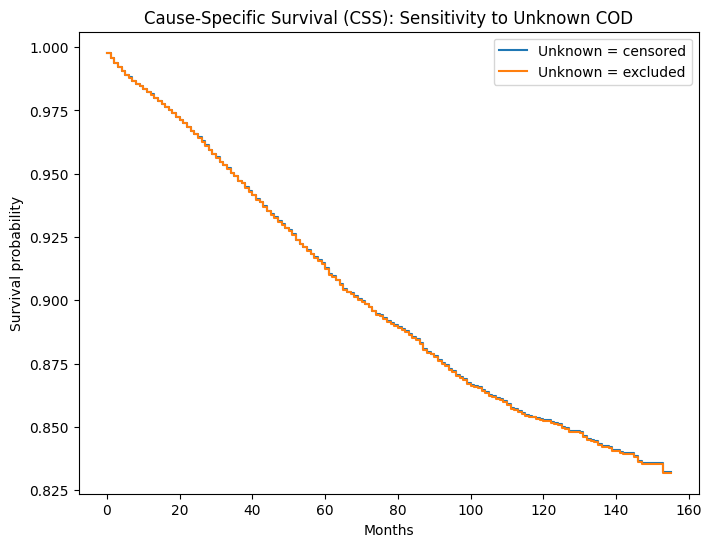

In [9]:
def recode_css(x, unknown_as="censored"):
    if x == "Dead (attributable to this cancer dx)":
        return 1
    elif x == "Alive or dead of other cause":
        return 0
    elif x == "Dead (missing/unknown COD)":
        if unknown_as == "censored":
            return 0
        elif unknown_as == "excluded":
            return None

# Scenario A: treat unknown as censored
df["event_css_censored"] = df["SEER cause-specific death classification"].apply(lambda x: recode_css(x, "censored"))

# Scenario B: exclude unknown
df["event_css_excluded"] = df["SEER cause-specific death classification"].apply(lambda x: recode_css(x, "excluded"))
df_excluded = df.dropna(subset=["event_css_excluded"]).copy()

# KM curves using simple step plot (since lifelines is not available here)
def km_curve(durations, events):
    """Compute simple Kaplan-Meier survival probabilities."""
    times = sorted(durations.unique())
    n = len(durations)
    surv = []
    at_risk = n
    survival_prob = 1.0

    for t in times:
        d = ((durations == t) & (events == 1)).sum()
        c = ((durations == t) & (events == 0)).sum()
        if at_risk > 0:
            survival_prob *= (1 - d / at_risk)
        surv.append((t, survival_prob))
        at_risk -= (d + c)
    return pd.DataFrame(surv, columns=["time", "survival"])

# Scenario A
kmA = km_curve(df["Survival months"], df["event_css_censored"])

# Scenario B
kmB = km_curve(df_excluded["Survival months"], df_excluded["event_css_excluded"])

# Plot
plt.figure(figsize=(8,6))
plt.step(kmA["time"], kmA["survival"], where="post", label="Unknown = censored")
plt.step(kmB["time"], kmB["survival"], where="post", label="Unknown = excluded")
plt.title("Cause-Specific Survival (CSS): Sensitivity to Unknown COD")
plt.xlabel("Months")
plt.ylabel("Survival probability")
plt.legend()
plt.show()


In [10]:
df["Cause_specific_death"] = df["SEER cause-specific death classification"].apply(lambda x: recode_css(x, "censored"))

df.drop(columns=["SEER cause-specific death classification","Tumor_Size_Summary_Granular",'event_css_censored', 'event_css_excluded'], inplace=True)

In [11]:
columns_to_check = [
    'SummaryStage_98_17',"NumMalignantTumors", "NumBenignTumors",
    'NeoadjuvantResponse_10', 'Race',
    'County_Grouped', 'Income_Broad', 'Tumor_Size_Granular'
]

unknown_keywords = ['unknown', 'unknown/missing', 'na/unknown']
unknown_keywords = [s.lower().strip() for s in unknown_keywords]

def is_unknown(value):
    if pd.isna(value):
        return False  
    value_str = str(value).strip().lower()
    return value_str in unknown_keywords

mask_unknown = df[columns_to_check].applymap(is_unknown)

max_unknowns_allowed = 3

df_dropped = df[mask_unknown.sum(axis=1) >= max_unknowns_allowed]
df = df[mask_unknown.sum(axis=1) < max_unknowns_allowed]

print(f"Original rows: {len(df) + len(df_dropped)}")
print(f"Remaining rows after filtering: {len(df)}")
print(f"Dropped rows: {len(df_dropped)}")


Original rows: 25072
Remaining rows after filtering: 25005
Dropped rows: 67


In [12]:
df.reset_index(inplace=True, drop=True)
df = df.replace(to_replace=r"Blank.*", value="Unknown", regex=True)
df.head()

,Year of diagnosis,SummaryStage_98_17,Radiation,Chemo,NeoadjuvantResponse_10,Survival months,NumMalignantTumors,NumBenignTumors,Year of follow-up recode,event,Race,Race_original,County_Grouped,Age_Group_Broad,Income_Broad,Tumor_Size_Granular,Tumor_Size_Overview,Tumor_Size_Numeric,Malignant_tumor_cnt,Benign_tumor_cnt,Radiation_original,Cause_specific_death
0,2020,Unknown,Unknown,Yes,NR,19,2 Tumors,0 Tumors,2021,1,NHW,Non-Hispanic White,Large Metro,80+,">= $120,000",51-100 mm (T3),Large (51-100 mm),60,2,0,Unknown,0
1,2015,Regional,Unknown,No,Not Given,90,3+ Tumors,0 Tumors,2022,0,NHB,Non-Hispanic Black,Large Metro,80+,"$100,000 - $119,999",6-10 mm (T1b),Tiny (≤10 mm),10,3,0,Unknown,0
2,2015,Localized,Unknown,Yes,Unknown,91,2 Tumors,0 Tumors,2022,0,NHW,Non-Hispanic White,Large Metro,40-59,"$100,000 - $119,999",11-20 mm (T1c),Small (11-20 mm),13,2,0,Unknown,0
3,2010,Regional,Unknown,No,Not Given,4,2 Tumors,0 Tumors,2010,1,Hispanic,Hispanic (All Races),Large Metro,60-69,"$80,000 - $99,999",Unknown,Unknown,Unknown,2,0,Unknown,1
4,2019,Unknown,Unknown,Yes,PR,45,2 Tumors,0 Tumors,2022,0,NHW,Non-Hispanic White,Large Metro,40-59,">= $120,000",11-20 mm (T1c),Small (11-20 mm),19,2,0,Unknown,0


## Tumor Size Analysis & Race Interaction

#### Overall survival 

In [13]:
tp_df = df[(df["Tumor_Size_Granular"]!="Unknown") & (df["Race"]!= "Unknown")&(df["Tumor_Size_Granular"]!= "No Tumor")].copy()
tp_df.reset_index(drop=True, inplace=True)

def era_bin(y):
    y = int(y)
    if y <= 2013: return "2010-2013"
    if y <= 2017: return "2014-2017"
    return "2018-2022"

def mk_neoadj_status(x):
    x = str(x)
    if x in {"CR","PR","NR"}:
        return "Given"
    if x == "Not Given":
        return "Not Given"
    return "Unknown"

def mk_neoadj_response(x):
    x = str(x)
    return x if x in {"CR","PR","NR"} else np.nan  # NA when not given or unknown

tp_df["Neoadj_status"] = tp_df["NeoadjuvantResponse_10"].map(mk_neoadj_status).astype("category")
tp_df["Neoadj_response"] = tp_df["NeoadjuvantResponse_10"].map(mk_neoadj_response)
tp_df["Neoadj_response"] = tp_df["Neoadj_response"].astype("category")
tp_df["Era"] = tp_df["Year of diagnosis"].astype(int).map(era_bin).astype("category")

tp_df["Radiation"].replace({"Unknown": "No", "Refused": "No","Other": "Yes", "Beam": "Yes"}, inplace=True)
tp_df["NumMalignantTumors"].replace({"1 Tumor": "1 Tumor", "2 Tumors": "2+ Tumors", "3+ Tumors": "2+ Tumors"}, inplace=True)
tp_df["Neoadj_status"].replace({"Not Given": "No/unk", "Given": "Yes","Unknown": "No/unk"}, inplace=True)

In [14]:
tp_df.to_csv(basePath/"tp_seer_data_cleaned.csv", index=False)

In [15]:
#treatment columns: Chemo, Radiation, 
#tumor/disease characteristics: Tumor_size_Granular, Tumor_Size_Numeric, NumMalignantTumors, NumBenignTumors, NeoadjuvantResponse_10, SummaryStage_98_17
#demographics columns: Race, Income_Broad, Age_Group_Broad, County_Grouped
#Survival columns: Survival months, event, Cause_specific_death

1 Logistic Regression
2 Cox Proportionality
3. RMST
4 Temporal trends
5 Cause specific survival vs all cause survival
6. Stratified Analysis
7 propensity scoring
8.  restricted cubic splines (RCS)
9. Receiver Operating Characteristic 
10 Fine-Gray model

Road map: Cox Proportionality Haxards -> RMST Analysis -> Cause-Specific -> RCS -> Propensity Score -> Temporal trends

In [16]:
# covariates alive/dead with percentages
cat_col = ['Race', 'SummaryStage_98_17', 'Radiation', 'Chemo', 'NeoadjuvantResponse_10',
           'NumMalignantTumors', 'NumBenignTumors', 'Income_Broad', 'County_Grouped', 'Age_Group_Broad','Tumor_Size_Granular']

for col in cat_col:
    print(f"\n=== {col} ===")

    by_event = tp_df.groupby([col, 'event']).size().reset_index(name='count')
    
    ct = pd.crosstab(tp_df[col], tp_df['event']) 

    if 0 not in ct.columns:
        ct[0] = 0
    if 1 not in ct.columns:
        ct[1] = 0
    ct = ct[[0, 1]].rename(columns={0: 'alive', 1: 'dead'})

    ct['total'] = ct['alive'] + ct['dead']
    ct['pct_dead'] = (ct['dead'] / ct['total']).fillna(0)

    dead_rate_table = ct.sort_values('pct_dead', ascending=False).reset_index()

    dead_rate_table['pct_dead'] = (dead_rate_table['pct_dead'] * 100).round(2)

    display(dead_rate_table)


=== Race ===


event,Race,alive,dead,total,pct_dead
0,NHAIAN,199,47,246,19.11
1,NHB,1797,417,2214,18.83
2,NHW,11796,2204,14000,15.74
3,Hispanic,3228,485,3713,13.06
4,NHAPI,3256,425,3681,11.55



=== SummaryStage_98_17 ===


event,SummaryStage_98_17,alive,dead,total,pct_dead
0,Distant,320,540,860,62.79
1,Regional,4013,1150,5163,22.27
2,Localized,7213,1306,8519,15.33
3,Unknown,8730,582,9312,6.25



=== Radiation ===


event,Radiation,alive,dead,total,pct_dead
0,No,9125,2389,11514,20.75
1,Yes,11151,1189,12340,9.64



=== Chemo ===


event,Chemo,alive,dead,total,pct_dead
0,No,4688,1707,6395,26.69
1,Yes,15588,1871,17459,10.72



=== NeoadjuvantResponse_10 ===


event,NeoadjuvantResponse_10,alive,dead,total,pct_dead
0,Unknown,4581,937,5518,16.98
1,Not Given,12218,2402,14620,16.43
2,NR,219,37,256,14.45
3,PR,1632,153,1785,8.57
4,CR,1626,49,1675,2.93



=== NumMalignantTumors ===


event,NumMalignantTumors,alive,dead,total,pct_dead
0,2+ Tumors,4076,1248,5324,23.44
1,1 Tumor,16200,2330,18530,12.57



=== NumBenignTumors ===


event,NumBenignTumors,alive,dead,total,pct_dead
0,≥1 Tumors,181,37,218,16.97
1,0 Tumors,20095,3541,23636,14.98



=== Income_Broad ===


event,Income_Broad,alive,dead,total,pct_dead
0,"< $60,000",788,222,1010,21.98
1,"$60,000 - $79,999",6195,1576,7771,20.28
2,"$100,000 - $119,999",3059,455,3514,12.95
3,"$80,000 - $99,999",7613,1086,8699,12.48
4,">= $120,000",2620,239,2859,8.36
5,Unknown,1,0,1,0.00



=== County_Grouped ===


event,County_Grouped,alive,dead,total,pct_dead
0,Rural,1616,378,1994,18.96
1,Medium/Small Metro,4727,882,5609,15.72
2,Large Metro,13870,2308,16178,14.27
3,Unknown,63,10,73,13.70



=== Age_Group_Broad ===


event,Age_Group_Broad,alive,dead,total,pct_dead
0,80+,762,869,1631,53.28
1,70-79,2443,768,3211,23.92
2,60-69,4689,777,5466,14.22
3,40-59,10158,965,11123,8.68
4,<40,2224,199,2423,8.21



=== Tumor_Size_Granular ===


event,Tumor_Size_Granular,alive,dead,total,pct_dead
0,>100 mm (T4+),136,70,206,33.98
1,51-100 mm (T3),1576,566,2142,26.42
2,31-50 mm (T2b),3288,852,4140,20.58
3,21-30 mm (T2a),4660,853,5513,15.47
4,11-20 mm (T1c),6678,856,7534,11.36
5,6-10 mm (T1b),2395,270,2665,10.13
6,0-5 mm (T1a),1543,111,1654,6.71


In [17]:
# Tumor Size and Race percentage alive/dead
def mortality_table_by_income_race(df):
    ct = pd.crosstab([df['Race'], df['Tumor_Size_Granular']], df['event'])

    # make sure both 0 and 1 exist
    if 0 not in ct.columns: ct[0] = 0
    if 1 not in ct.columns: ct[1] = 0
    ct = ct[[0, 1]].rename(columns={0: 'alive', 1: 'dead'})

    ct['total'] = ct['alive'] + ct['dead']
    ct['pct_dead'] = (ct['dead'] / ct['total']).replace([float('inf')], 0).fillna(0) * 100
    out = ct.reset_index()

    # sort within each Income by pct_dead desc
    out = out.sort_values(['Tumor_Size_Granular', 'Race'], ascending=[True, False]).reset_index(drop=True)
    out['pct_dead'] = out['pct_dead'].round(2)
    return out

display(mortality_table_by_income_race(tp_df))

event,Race,Tumor_Size_Granular,alive,dead,total,pct_dead
0,NHW,0-5 mm (T1a),955,72,1027,7.01
1,NHB,0-5 mm (T1a),116,9,125,7.20
2,NHAPI,0-5 mm (T1a),262,16,278,5.76
3,NHAIAN,0-5 mm (T1a),12,0,12,0.00
4,Hispanic,0-5 mm (T1a),198,14,212,6.60
5,NHW,11-20 mm (T1c),4073,568,4641,12.24
6,NHB,11-20 mm (T1c),583,90,673,13.37
7,NHAPI,11-20 mm (T1c),949,88,1037,8.49
8,NHAIAN,11-20 mm (T1c),72,9,81,11.11
9,Hispanic,11-20 mm (T1c),1001,101,1102,9.17


In [70]:

# ---- Basic summaries ----
# Replace with your actual column names
surv_col = "Survival months"
size_col = "Tumor_Size_Granular"

# Median and IQR of survival
median_surv = tp_df[surv_col].median()
iqr_low = tp_df[surv_col].quantile(0.25)
iqr_high = tp_df[surv_col].quantile(0.75)
print(f"Median follow-up: {median_surv:.0f} months (IQR = {iqr_low:.0f}–{iqr_high:.0f})")

# ---- Tumor size distribution ----
# If tumor size is numeric (in mm)
tp_df["Tumor_Size_Bin"] = tp_df[size_col]

# Frequency and percentage by bin
size_counts = tp_df["Tumor_Size_Bin"].value_counts(dropna=False).sort_index()
size_pct = (size_counts / len(tp_df) * 100).round(1)

dist_df = pd.DataFrame({"Count": size_counts, "Percent": size_pct})
print("\nTumor size distribution:")
print(dist_df)


Median follow-up: 61 months (IQR = 28–98)

Tumor size distribution:
                Count  Percent
Tumor_Size_Bin                
11-20 mm (T1c)   7534     31.6
0-5 mm (T1a)     1654      6.9
6-10 mm (T1b)    2665     11.2
21-30 mm (T2a)   5513     23.1
31-50 mm (T2b)   4140     17.4
51-100 mm (T3)   2142      9.0
>100 mm (T4+)     206      0.9


#### KM with logrank test and cox per race and tumor size

In [18]:
kmf = KaplanMeierFitter()

def logRankTest(lst, col, df ):
    mask1 = df[col]==lst[0]
    mask2 = df[col]==lst[1]
    results = logrank_test(
        df.loc[mask1,"Survival months"], df.loc[mask2, "Survival months"],
        event_observed_A=df.loc[mask1,"event"],
        event_observed_B=df.loc[mask2,"event"]
    )
    return results
    
def multiLogRankTest(lst, col, df):
    results = multivariate_logrank_test(df["Survival months"], df[col],df["event"])
    return results

def pairwise_logrank(df, uni_list, group_col, time_col='Survival months', event_col='event', correction='bonferroni'):
    results = []
    for g1, g2 in combinations(uni_list, 2):
        mask1 = df[group_col] == g1
        mask2 = df[group_col] == g2

        result = logrank_test(
            df.loc[mask1, time_col],
            df.loc[mask2, time_col],
            event_observed_A=df.loc[mask1, event_col],
            event_observed_B=df.loc[mask2, event_col]
        )
        results.append({
            'Group1': g1,
            'Group2': g2,
            'Test Statistic': result.test_statistic,
            'p-value': result.p_value
        })
    results_df = pd.DataFrame(results)

    if correction is not None:
        corrected = multipletests(results_df['p-value'], alpha=0.05, method=correction)
        results_df['p-value (corrected)'] = corrected[1]
        results_df['Significant (corrected)'] = corrected[0]

    return results_df.sort_values('p-value (corrected)' if correction else 'p-value').reset_index(drop=True)

def univariate_cox(tempdf, col, time_col="Survival months", event_col="event"):
    print(f"\nCox Regression Results for {col}:")
    
    cox_df = tempdf[[col, time_col, event_col]].dropna()
    categories = sorted(tempdf[col].dropna().astype(str).unique())
    reference_category = categories[0]
    
    if cox_df[col].dtype == 'object':
        cox_df = pd.get_dummies(cox_df, columns=[col], drop_first=True)
    
    cph = CoxPHFitter()
    cph.fit(cox_df, duration_col=time_col, event_col=event_col)
    cph.print_summary()
    
    fig,ax = plt.subplots(figsize=(8, 5))
    sns.barplot(
        x=cph.summary['exp(coef)'],
        y=cph.summary.index,
        palette="coolwarm",
        orient='h'
    )
    ax.axvline(x=1, linestyle='--', color='grey')
    ax.text(1, -0.75,f'Reference category: {reference_category}',fontsize=10,color='black',ha='left',va='center')
    ax.set_title(f'Hazard Ratios from Cox Regression for {col}')
    ax.set_xlabel('Hazard Ratio')
    ax.set_ylabel('Variables')
    plt.tight_layout()
    plt.show()
    
    return cph.summary.reset_index(), reference_category

def survival_plots_stats(tempdf, col, writer=None, threshold=20, plots=True):
    tempdf = tempdf.copy()
    pd.set_option('display.max_columns', None)
    tempdf = tempdf[tempdf[col].notna()]
    thr = threshold 
    category_counts = tempdf[col].value_counts()
    valid_categories = category_counts[category_counts >= threshold].index
    grouped_categories = category_counts[category_counts < threshold].index.tolist()
    
   
    if len(grouped_categories) >= 2:
        tempdf[col] = tempdf[col].apply(lambda x: x if x in valid_categories else 'Other')
    else:
        grouped_categories = []
        
    uni_list = tempdf[col].unique().tolist()

    unwanted_values = ["Recode not available", "Test ordered, results not in chart"]
    tempdf = tempdf[~tempdf[col].isin(unwanted_values)]
    uni_list = [val for val in uni_list if val not in unwanted_values]
    
    uni_list_len = len(uni_list)
    print(f"Value count of categories in the{col}:")
    val_count_df = tempdf[col].value_counts().reset_index()
    print(val_count_df)
    
    if uni_list_len == 2:
        results = logRankTest(uni_list, col, tempdf)
        print("\nBelow are the results for logranktest:")
        print(results)
    else:
        results = multiLogRankTest(uni_list, col, tempdf)
        print("\nBelow are the results for the multivariate logranktest: ")
        print(results)

    p = results.p_value
    if p < 0.05:
        if plots:
            fig, ax = plt.subplots(figsize=(8 +(uni_list_len - 2),6 + (uni_list_len - 3)))
            for i in uni_list:
                mask = tempdf[col] == i
                kmf.fit(tempdf.loc[mask, "Survival months"], event_observed=tempdf.loc[mask, "event"], label=i)
                kmf.plot(ax=ax)
            
            ax.set_title(f"Kaplan-Meier Survival Curves: {col}")
            ax.set_xlabel("Time (Months)")
            ax.set_ylabel("Survival Probability")
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)
            ax.legend()
            plt.tight_layout()
            plt.show()        
            
        if uni_list_len>2:
            pairwise_df = pairwise_logrank(tempdf, uni_list, group_col = col)
            print(f"\nPairwise comparision of the categories within the {col}")
            display(pairwise_df)
        else:
            pairwise_df =pd.DataFrame()

        #perform univariate analysis
        cox_summary_df, reference_category = univariate_cox(tempdf, col)

    
    logrank_df = pd.DataFrame({
    "Test Statistic": [results.test_statistic],
    "p-value": [results.p_value]})
    

Value count of categories in theTumor_Size_Granular:
  Tumor_Size_Granular  count
0      11-20 mm (T1c)   7534
1      21-30 mm (T2a)   5513
2      31-50 mm (T2b)   4140
3       6-10 mm (T1b)   2665
4      51-100 mm (T3)   2142
5        0-5 mm (T1a)   1654
6       >100 mm (T4+)    206

Below are the results for the multivariate logranktest: 
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 6
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         773.89 <0.005    542.04


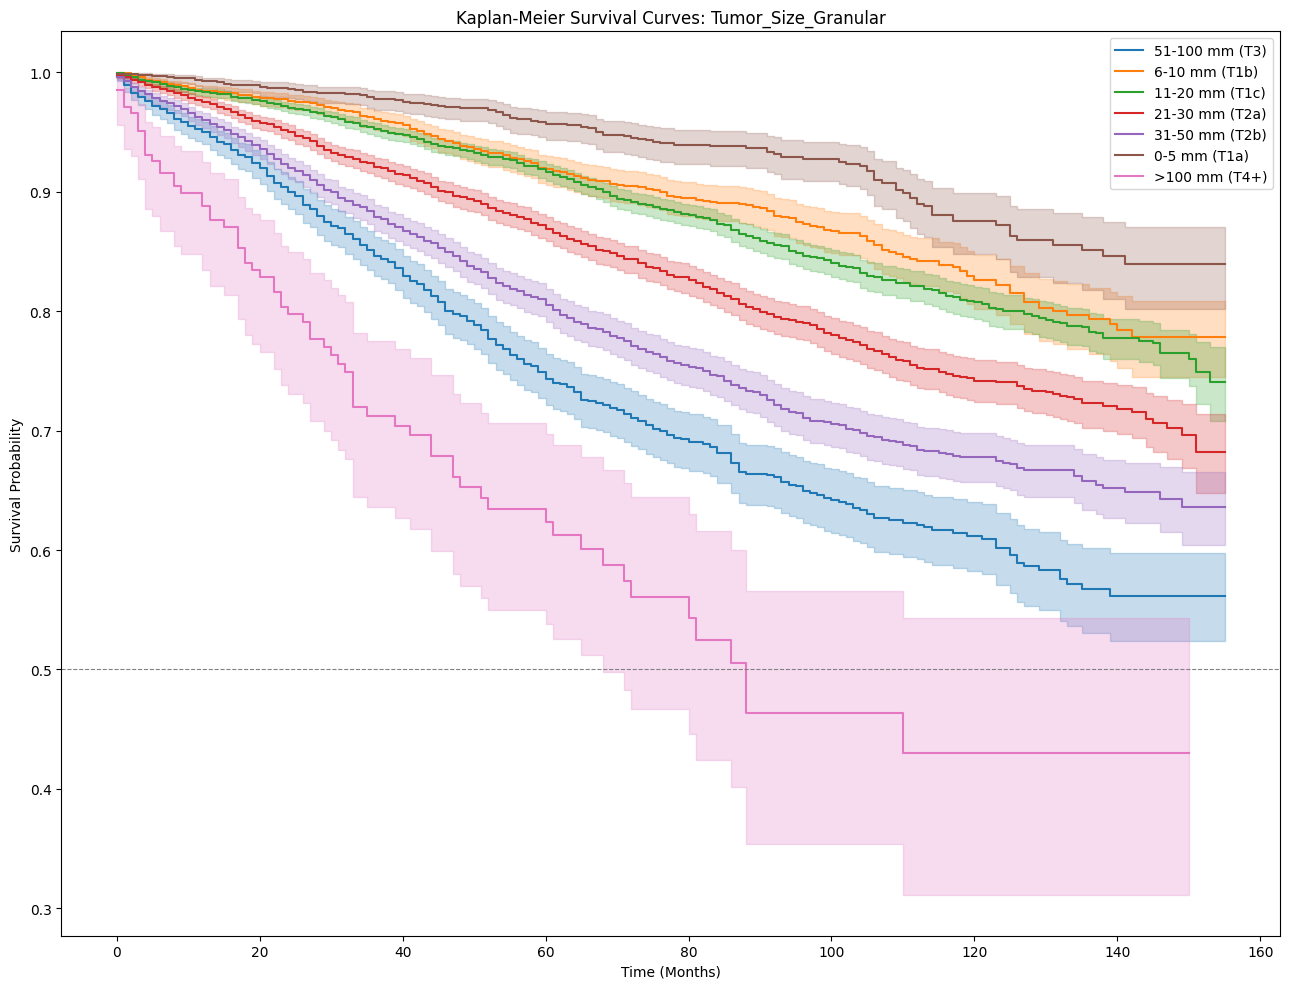


Pairwise comparision of the categories within the Tumor_Size_Granular


,Group1,Group2,Test Statistic,p-value,p-value (corrected),Significant (corrected)
0,51-100 mm (T3),11-20 mm (T1c),365.154841,2.123997e-81,4.460394e-80,True
1,0-5 mm (T1a),>100 mm (T4+),302.157058,1.116417e-67,2.344476e-66,True
2,51-100 mm (T3),0-5 mm (T1a),277.935044,2.116370e-62,4.444377e-61,True
3,51-100 mm (T3),6-10 mm (T1b),249.150435,3.977898e-56,8.353587e-55,True
4,11-20 mm (T1c),31-50 mm (T2b),234.222112,7.154938e-53,1.502537e-51,True
5,11-20 mm (T1c),>100 mm (T4+),215.545314,8.474393e-49,1.779623e-47,True
6,6-10 mm (T1b),>100 mm (T4+),213.692922,2.148857e-48,4.512599e-47,True
7,31-50 mm (T2b),0-5 mm (T1a),190.075805,3.060444e-43,6.426932e-42,True
8,6-10 mm (T1b),31-50 mm (T2b),153.856949,2.488807e-35,5.226496e-34,True
9,51-100 mm (T3),21-30 mm (T2a),133.675057,6.435092e-31,1.351369e-29,True



Cox Regression Results for Tumor_Size_Granular:


<lifelines.CoxPHFitter: fitted with 23854 total observations, 20276 right-censored observations>
             duration col = 'Survival months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 23854
number of events observed = 3578
   partial log-likelihood = -33556.84
         time fit was run = 2025-11-10 17:54:27 UTC

---
                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                           
Tumor_Size_Granular_11-20 mm (T1c)  0.59      1.80      0.10            0.39            0.78                1.47                2.19
Tumor_Size_Granular_21-30 mm (T2a)  0.96      2.61      0.10            0.76            1.16                2.14                3.18
Tumor_Size_Granular_31-50 mm (T2b)  1.31      3.71      0.10            1.11            1.51                3.04                4.52
Tumor_Size_Granular_51-100 mm (T3)  1.58      4.84      0.10            1.37            1.78                3.95                5.94
Tumor_Size_Granular_6-10 mm (T1b)   0.46      1.59      0.11            0.24            0.68                1.27                1.98
Tumor_Size_Granular_>100 mm (T4+)   2.19      8.94      0.15            1.89            2.49                6.63               12.06

                                    cmp to     z      p  -log2(p)
covariate                                                        
Tumor_Size_Granular_11-20 mm (T1c)    0.00  5.80 <0.005     27.20
Tumor_Size_Granular_21-30 mm (T2a)    0.00  9.49 <0.005     68.55
Tumor_Size_Granular_31-50 mm (T2b)    0.00 12.98 <0.005    125.60
Tumor_Size_Granular_51-100 mm (T3)    0.00 15.20 <0.005    170.81
Tumor_Size_Granular_6-10 mm (T1b)     0.00  4.11 <0.005     14.60
Tumor_Size_Granular_>100 mm (T4+)     0.00 14.34 <0.005    152.48
---
Concordance = 0.64
Partial AIC = 67125.67
log-likelihood ratio test = 694.05 on 6 df
-log2(p) of ll-ratio test = 484.77

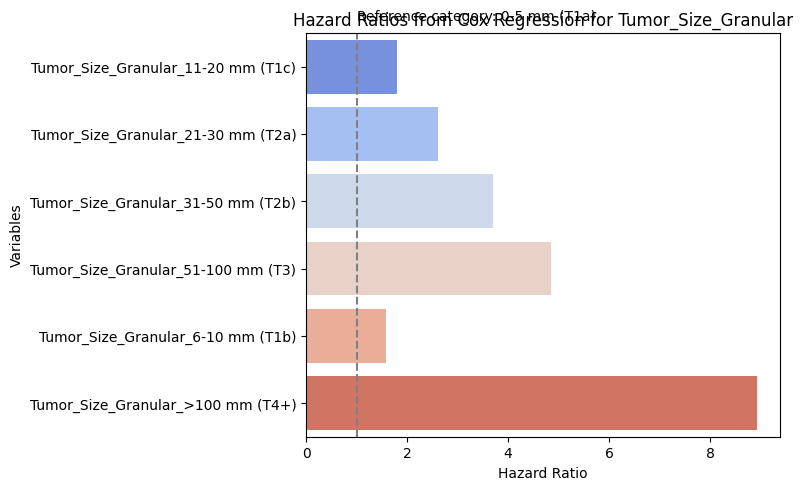

In [19]:
survival_plots_stats(tp_df, "Tumor_Size_Granular", threshold=100)

Value count of categories in theRace:
       Race  count
0       NHW  14000
1  Hispanic   3713
2     NHAPI   3681
3       NHB   2214
4    NHAIAN    246

Below are the results for the multivariate logranktest: 
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          61.75 <0.005     39.55


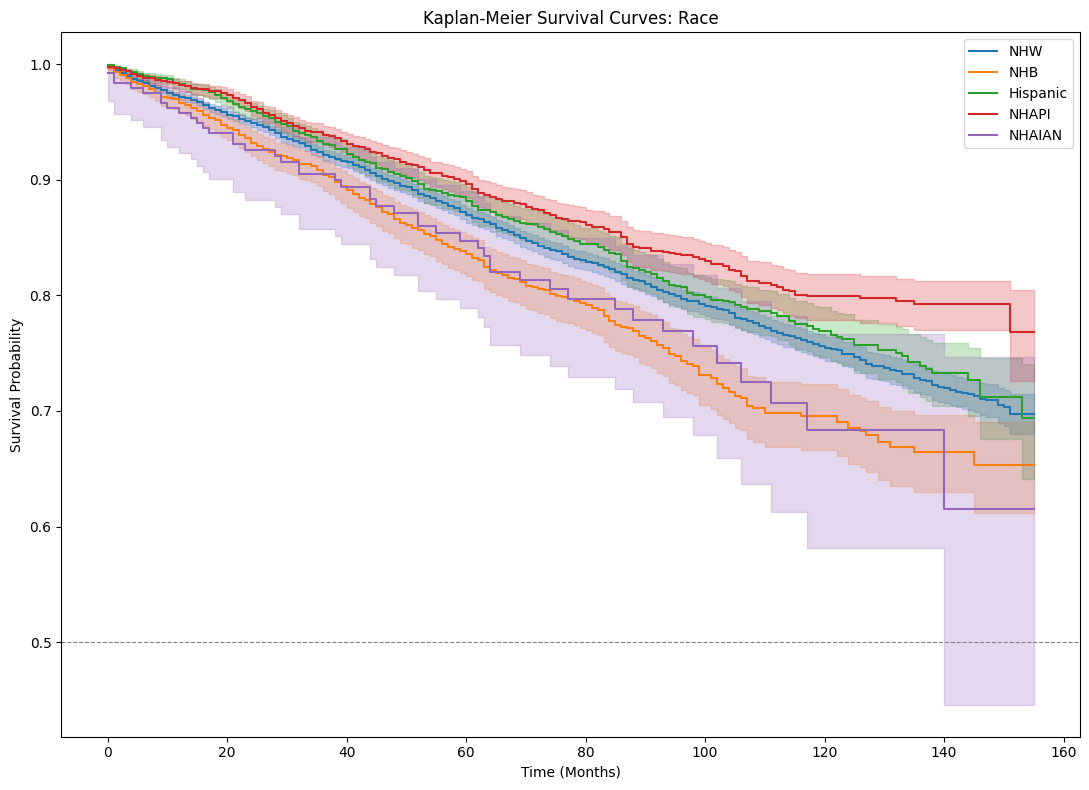


Pairwise comparision of the categories within the Race


,Group1,Group2,Test Statistic,p-value,p-value (corrected),Significant (corrected)
0,NHB,NHAPI,55.850289,7.820526e-14,7.820526e-13,True
1,NHB,Hispanic,26.211675,3.059672e-07,3.059672e-06,True
2,NHW,NHAPI,23.887013,1.021586e-06,1.021586e-05,True
3,NHW,NHB,22.702731,1.890990e-06,1.890990e-05,True
4,NHAPI,NHAIAN,10.300457,1.329973e-03,1.329973e-02,True
5,Hispanic,NHAPI,6.687381,9.709772e-03,9.709772e-02,False
6,Hispanic,NHAIAN,4.431483,3.528184e-02,3.528184e-01,False
7,NHW,Hispanic,3.026494,8.191485e-02,8.191485e-01,False
8,NHB,NHAIAN,0.016692,8.972013e-01,1.000000e+00,False
9,NHW,NHAIAN,2.569216,1.089618e-01,1.000000e+00,False



Cox Regression Results for Race:


<lifelines.CoxPHFitter: fitted with 23854 total observations, 20276 right-censored observations>
             duration col = 'Survival months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 23854
number of events observed = 3578
   partial log-likelihood = -33873.53
         time fit was run = 2025-11-10 17:54:28 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Race_NHAIAN  0.32      1.38      0.15            0.02            0.62                1.02                1.86
Race_NHAPI  -0.17      0.84      0.07           -0.30           -0.04                0.74                0.96
Race_NHB     0.34      1.41      0.07            0.21            0.47                1.23                1.60
Race_NHW     0.09      1.09      0.05           -0.01            0.19                0.99                1.20

             cmp to     z      p  -log2(p)
covariate                                 
Race_NHAIAN    0.00  2.11   0.03      4.84
Race_NHAPI     0.00 -2.57   0.01      6.60
Race_NHB       0.00  5.11 <0.005     21.60
Race_NHW       0.00  1.74   0.08      3.62
---
Concordance = 0.53
Partial AIC = 67755.06
log-likelihood ratio test = 60.67 on 4 df
-log2(p) of ll-ratio test = 38.79

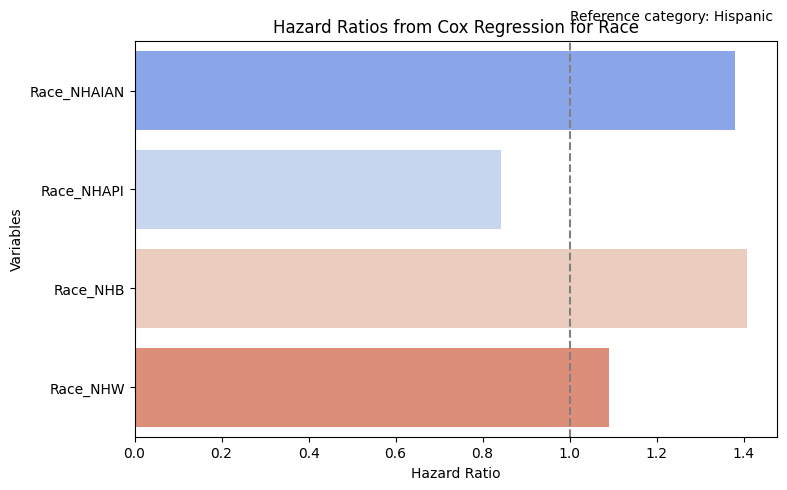

In [20]:
survival_plots_stats(tp_df,"Race", threshold=100)


=== Tumor Size: 0-5 mm (T1a) ===
Value count of categories in theRace:
       Race  count
0       NHW   1027
1     NHAPI    278
2  Hispanic    212
3       NHB    125
4    NHAIAN     12

Below are the results for the multivariate logranktest: 
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           1.36 0.85      0.23

=== Tumor Size: 6-10 mm (T1b) ===
Value count of categories in theRace:
       Race  count
0       NHW   1748
1  Hispanic    349
2     NHAPI    321
3       NHB    219
4    NHAIAN     28

Below are the results for the multivariate logranktest: 
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          23.69 <0.005     13.40

Pair

,Group1,Group2,Test Statistic,p-value,p-value (corrected),Significant (corrected)
0,NHB,NHAPI,18.462673,0.000017,0.000173,True
1,NHAPI,NHAIAN,13.633069,0.000222,0.002222,True
2,NHW,NHAPI,9.487112,0.002069,0.020692,True
3,NHB,Hispanic,7.312022,0.006849,0.068495,False
4,Hispanic,NHAIAN,6.155320,0.013102,0.131017,False
5,NHB,NHW,5.824314,0.015806,0.158061,False
6,NHW,NHAIAN,4.582021,0.032309,0.323091,False
7,Hispanic,NHAPI,3.001689,0.083178,0.831778,False
8,NHW,Hispanic,1.417206,0.233864,1.000000,False
9,NHB,NHAIAN,1.026204,0.311052,1.000000,False



Cox Regression Results for Race:


<lifelines.CoxPHFitter: fitted with 2665 total observations, 2395 right-censored observations>
             duration col = 'Survival months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 2665
number of events observed = 270
   partial log-likelihood = -1936.59
         time fit was run = 2025-11-10 17:54:28 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Race_NHAIAN  1.11      3.02      0.45            0.22            1.99                1.24                7.35
Race_NHAPI  -0.58      0.56      0.33           -1.23            0.07                0.29                1.07
Race_NHB     0.70      2.01      0.26            0.18            1.21                1.20                3.36
Race_NHW     0.25      1.28      0.21           -0.16            0.66                0.85                1.93

             cmp to     z    p  -log2(p)
covariate                               
Race_NHAIAN    0.00  2.44 0.01      6.09
Race_NHAPI     0.00 -1.75 0.08      3.63
Race_NHB       0.00  2.66 0.01      7.00
Race_NHW       0.00  1.18 0.24      2.08
---
Concordance = 0.56
Partial AIC = 3881.18
log-likelihood ratio test = 23.40 on 4 df
-log2(p) of ll-ratio test = 13.21

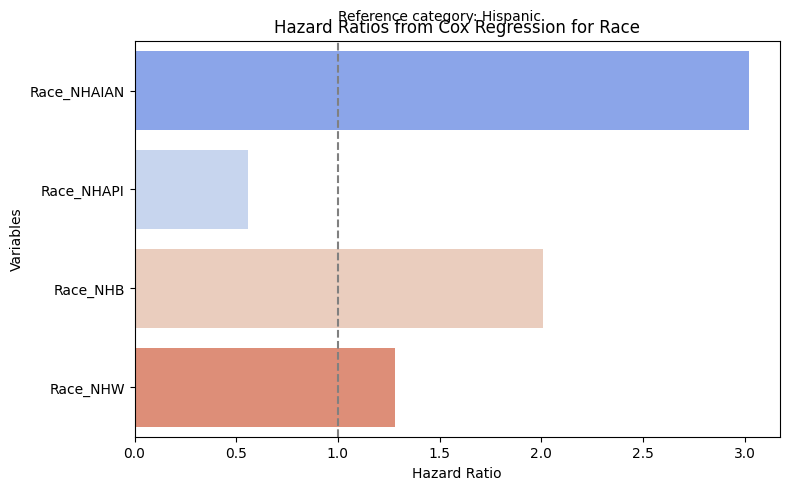


=== Tumor Size: 11-20 mm (T1c) ===
Value count of categories in theRace:
       Race  count
0       NHW   4641
1  Hispanic   1102
2     NHAPI   1037
3       NHB    673
4    NHAIAN     81

Below are the results for the multivariate logranktest: 
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
          12.26 0.02      6.01

Pairwise comparision of the categories within the Race


,Group1,Group2,Test Statistic,p-value,p-value (corrected),Significant (corrected)
0,NHAPI,NHB,8.625336,0.003315,0.033152,True
1,NHW,NHAPI,7.390302,0.006558,0.065576,False
2,Hispanic,NHB,4.683035,0.030462,0.304619,False
3,NHW,Hispanic,3.109374,0.077843,0.778429,False
4,NHW,NHAIAN,0.039550,0.842363,1.000000,False
5,NHW,NHB,1.187647,0.275805,1.000000,False
6,NHAPI,Hispanic,0.677736,0.410368,1.000000,False
7,NHAPI,NHAIAN,0.962049,0.326671,1.000000,False
8,Hispanic,NHAIAN,0.693327,0.405035,1.000000,False
9,NHB,NHAIAN,0.019197,0.889802,1.000000,False



Cox Regression Results for Race:


<lifelines.CoxPHFitter: fitted with 7534 total observations, 6678 right-censored observations>
             duration col = 'Survival months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7534
number of events observed = 856
   partial log-likelihood = -7070.87
         time fit was run = 2025-11-10 17:54:28 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Race_NHAIAN  0.26      1.30      0.35           -0.42            0.94                0.66                2.57
Race_NHAPI  -0.12      0.89      0.15           -0.40            0.17                0.67                1.18
Race_NHB     0.32      1.37      0.14            0.03            0.60                1.03                1.82
Race_NHW     0.19      1.21      0.11           -0.02            0.40                0.98                1.50

             cmp to     z    p  -log2(p)
covariate                               
Race_NHAIAN    0.00  0.75 0.45      1.14
Race_NHAPI     0.00 -0.81 0.42      1.26
Race_NHB       0.00  2.18 0.03      5.09
Race_NHW       0.00  1.77 0.08      3.71
---
Concordance = 0.53
Partial AIC = 14149.73
log-likelihood ratio test = 12.71 on 4 df
-log2(p) of ll-ratio test = 6.29

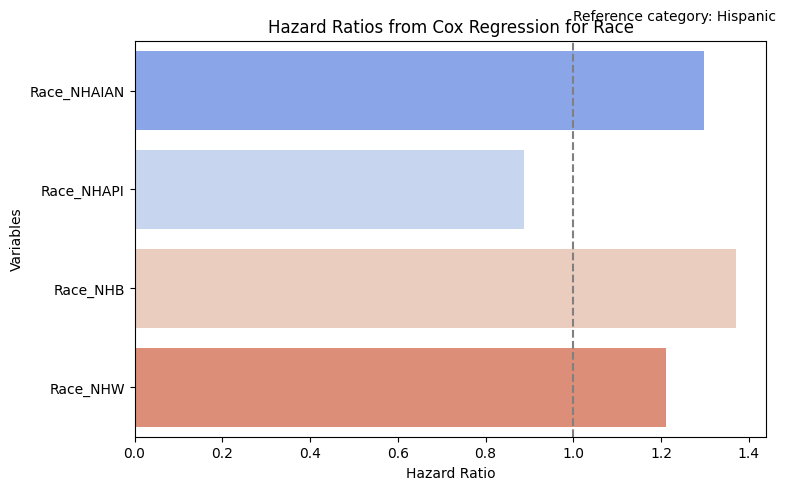


=== Tumor Size: 21-30 mm (T2a) ===
Value count of categories in theRace:
       Race  count
0       NHW   3099
1  Hispanic    935
2     NHAPI    914
3       NHB    505
4    NHAIAN     60

Below are the results for the multivariate logranktest: 
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          28.19 <0.005     16.42

Pairwise comparision of the categories within the Race


,Group1,Group2,Test Statistic,p-value,p-value (corrected),Significant (corrected)
0,NHW,NHAPI,20.957437,0.000005,0.000047,True
1,NHB,NHAPI,18.436478,0.000018,0.000176,True
2,NHB,Hispanic,6.643182,0.009954,0.099536,False
3,NHW,Hispanic,6.068265,0.013763,0.137632,False
4,NHAPI,NHAIAN,3.659346,0.055756,0.557555,False
5,NHAPI,Hispanic,3.640007,0.056407,0.564067,False
6,NHW,NHAIAN,0.060608,0.805538,1.000000,False
7,NHW,NHB,1.041799,0.307404,1.000000,False
8,NHB,NHAIAN,0.025922,0.872092,1.000000,False
9,Hispanic,NHAIAN,1.180977,0.277157,1.000000,False



Cox Regression Results for Race:


<lifelines.CoxPHFitter: fitted with 5513 total observations, 4660 right-censored observations>
             duration col = 'Survival months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5513
number of events observed = 853
   partial log-likelihood = -6802.12
         time fit was run = 2025-11-10 17:54:29 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Race_NHAIAN  0.32      1.37      0.29           -0.26            0.89                0.77                2.43
Race_NHAPI  -0.26      0.77      0.14           -0.53            0.01                0.59                1.01
Race_NHB     0.36      1.44      0.14            0.09            0.63                1.10                1.89
Race_NHW     0.25      1.28      0.10            0.05            0.45                1.05                1.56

             cmp to     z    p  -log2(p)
covariate                               
Race_NHAIAN    0.00  1.08 0.28      1.83
Race_NHAPI     0.00 -1.88 0.06      4.05
Race_NHB       0.00  2.62 0.01      6.83
Race_NHW       0.00  2.45 0.01      6.14
---
Concordance = 0.55
Partial AIC = 13612.23
log-likelihood ratio test = 30.09 on 4 df
-log2(p) of ll-ratio test = 17.70

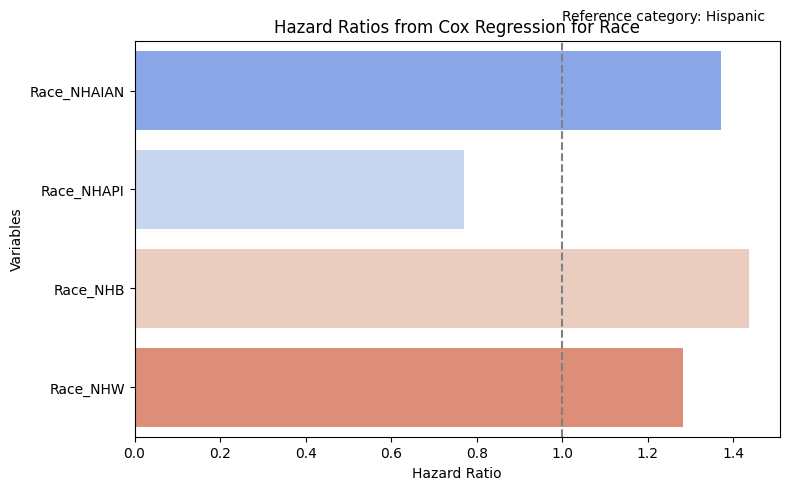


=== Tumor Size: 31-50 mm (T2b) ===
Value count of categories in theRace:
       Race  count
0       NHW   2251
1     NHAPI    715
2  Hispanic    701
3       NHB    428
4    NHAIAN     45

Below are the results for the multivariate logranktest: 
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          24.28 <0.005     13.80

Pairwise comparision of the categories within the Race


,Group1,Group2,Test Statistic,p-value,p-value (corrected),Significant (corrected)
0,NHAPI,NHB,13.141425,0.000289,0.002888,True
1,NHW,NHAPI,12.661642,0.000373,0.003732,True
2,Hispanic,NHB,9.873545,0.001677,0.016767,True
3,Hispanic,NHW,8.663024,0.003247,0.032473,True
4,NHAPI,NHAIAN,4.299349,0.038127,0.381270,False
5,Hispanic,NHAIAN,3.910074,0.047997,0.479975,False
6,NHW,NHB,1.250010,0.263551,1.000000,False
7,Hispanic,NHAPI,0.241998,0.622767,1.000000,False
8,NHW,NHAIAN,0.741815,0.389080,1.000000,False
9,NHB,NHAIAN,0.173494,0.677025,1.000000,False



Cox Regression Results for Race:


<lifelines.CoxPHFitter: fitted with 4140 total observations, 3288 right-censored observations>
             duration col = 'Survival months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 4140
number of events observed = 852
   partial log-likelihood = -6588.20
         time fit was run = 2025-11-10 17:54:29 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Race_NHAIAN  0.55      1.73      0.29           -0.03            1.12                0.97                3.07
Race_NHAPI  -0.06      0.94      0.13           -0.32            0.20                0.72                1.22
Race_NHB     0.43      1.53      0.14            0.16            0.69                1.17                2.00
Race_NHW     0.31      1.36      0.10            0.10            0.51                1.11                1.67

             cmp to     z      p  -log2(p)
covariate                                 
Race_NHAIAN    0.00  1.87   0.06      4.01
Race_NHAPI     0.00 -0.47   0.64      0.64
Race_NHB       0.00  3.15 <0.005      9.26
Race_NHW       0.00  2.93 <0.005      8.22
---
Concordance = 0.55
Partial AIC = 13184.40
log-likelihood ratio test = 24.98 on 4 df
-log2(p) of ll-ratio test = 14.27

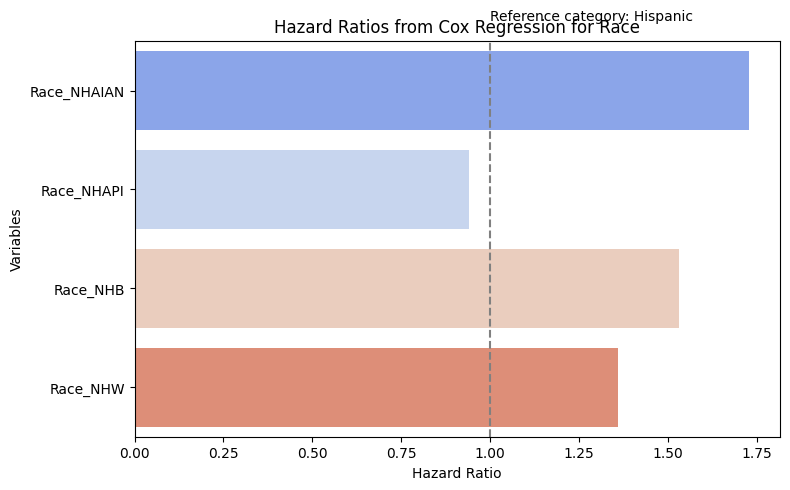


=== Tumor Size: 51-100 mm (T3) ===
Value count of categories in theRace:
       Race  count
0       NHW   1125
1     NHAPI    384
2  Hispanic    378
3       NHB    235
4    NHAIAN     20

Below are the results for the multivariate logranktest: 
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           8.26 0.08      3.60

=== Tumor Size: >100 mm (T4+) ===
Value count of categories in theRace:
    Race  count
0    NHW    109
1  Other     97

Below are the results for logranktest:
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.03 0.31      1.69


In [21]:
tumor_cat = ['0-5 mm (T1a)','6-10 mm (T1b)', '11-20 mm (T1c)', '21-30 mm (T2a)','31-50 mm (T2b)', '51-100 mm (T3)', '>100 mm (T4+)']
for i in tumor_cat:
    print(f"\n=== Tumor Size: {i} ===")
    tempdf = tp_df[tp_df["Tumor_Size_Granular"]==i]
    survival_plots_stats(tempdf,"Race", threshold=50, plots =False)

🧠 Clinical Interpretation of the Race × Tumor Size Interaction

Race modifies the slope of the size-survival curve.
For White/Asian women, hazard rises smoothly with size.
For Black/AIAN women, hazard accelerates faster — the risk slope is steeper.

The interaction peaks between 21–50 mm, where race differences are strongest.

At both extremes (tiny < 5 mm or giant > 100 mm), race ceases to matter because baseline survival is either near-perfect or universally poor.

Therapy intensity equalizes outcomes. In your doubly-robust and RMST models, the disparity largely vanishes when therapy is complete — confirming this interaction is care-mediated, not intrinsic.

🩺 Clinically Actionable Conclusion

Tumor size and race interact synergistically to shape survival.
Below 1 cm, outcomes are universally favorable and race-neutral.
Between 2 cm and 5 cm, however, survival risk accelerates sharply for Black and AIAN patients, even after adjusting for covariates. This range defines a “disparity inflection zone” where delays in treatment or suboptimal therapy amplify mortality risk. When timely, full systemic therapy is administered, the racial gap narrows dramatically, indicating that equitable care neutralizes most of the interaction effect.
Clinicians should therefore treat 2–5 cm triple-positive tumors in high-risk racial groups with heightened urgency—considering early systemic initiation, multidisciplinary coordination, and strict adherence monitoring—to flatten the steep portion of the risk curve.

#### Cox proportionality disrtibution

In [22]:
tp_df["Tumor_Size_Granular"] = pd.Categorical(tp_df["Tumor_Size_Granular"])

tp_df["Tumor_Size_Granular"] = tp_df["Tumor_Size_Granular"].cat.reorder_categories(["11-20 mm (T1c)", "0-5 mm (T1a)", "6-10 mm (T1b)", "21-30 mm (T2a)", "31-50 mm (T2b)", "51-100 mm (T3)", ">100 mm (T4+)"])

def cox_regression(df, cols, formula= None, strata= None):
    cph = CoxPHFitter(penalizer=0.1)

    df = df.dropna(subset=cols)
    cph.fit(df,duration_col="Survival months", event_col="event", formula = formula, strata=strata)
    test_results = proportional_hazard_test(cph, df,time_transform="rank")
    summary = cph.summary.reset_index()

    return cph, test_results, summary

In [23]:
# Full Cox Model with passed PH test
cph, prop_test, summ_df = cox_regression(tp_df, ["Survival months", "Tumor_Size_Granular","Radiation","Chemo", "NumMalignantTumors","NeoadjuvantResponse_10","Race","Age_Group_Broad", "County_Grouped","Income_Broad","SummaryStage_98_17"],
                                    formula = "Tumor_Size_Granular + Race + Radiation + Chemo  + NeoadjuvantResponse_10 + Income_Broad + Age_Group_Broad + County_Grouped", strata="Era")

summ_df[summ_df["p"]<0.05]

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,Tumor_Size_Granular[T.0-5 mm (T1a)],-0.451976,0.636369,0.056503,-0.562720,-0.341232,0.569657,0.710894,0.0,-7.999139,1.252923e-15,49.503623
1,Tumor_Size_Granular[T.6-10 mm (T1b)],-0.230043,0.794499,0.044318,-0.316904,-0.143183,0.728400,0.866596,0.0,-5.190792,2.094019e-07,22.187222
2,Tumor_Size_Granular[T.21-30 mm (T2a)],0.133663,1.143007,0.032249,0.070455,0.196870,1.072996,1.217586,0.0,4.144652,3.403303e-05,14.842705
3,Tumor_Size_Granular[T.31-50 mm (T2b)],0.414275,1.513273,0.034661,0.346342,0.482209,1.413885,1.619648,0.0,11.952319,6.313875e-33,106.965101
4,Tumor_Size_Granular[T.51-100 mm (T3)],0.681655,1.977147,0.043354,0.596683,0.766627,1.816086,2.152493,0.0,15.723110,1.050393e-55,182.635116
5,Tumor_Size_Granular[T.>100 mm (T4+)],1.114911,3.049296,0.122927,0.873979,1.355842,2.396427,3.880027,0.0,9.069732,1.193106e-19,62.861912
7,Race[T.NHAPI],-0.102494,0.902584,0.039887,-0.180671,-0.024316,0.834710,0.975977,0.0,-2.569579,1.018223e-02,6.617803
8,Race[T.NHB],0.215906,1.240986,0.045728,0.126281,0.305532,1.134601,1.357347,0.0,4.721520,2.340886e-06,18.704514
10,Radiation[T.Yes],-0.375858,0.686700,0.026728,-0.428243,-0.323472,0.651653,0.723632,0.0,-14.062528,6.453871e-45,146.796599
11,Chemo[T.Yes],-0.480476,0.618489,0.029725,-0.538736,-0.422216,0.583485,0.655592,0.0,-16.164000,9.049376e-59,192.815939


In [24]:
#passed
cph, prop_test, summ_df = cox_regression(tp_df, ["Survival months", "Tumor_Size_Granular", "Chemo","Radiation","Race", "NeoadjuvantResponse_10","SummaryStage_98_17"],
                                    formula = "Tumor_Size_Granular + Race + Chemo + Radiation + NeoadjuvantResponse_10", strata="Era")
summ_df[summ_df["p"]<0.05]

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,Tumor_Size_Granular[T.0-5 mm (T1a)],-0.552603,0.575450,0.055392,-0.661169,-0.444037,0.516247,0.641442,0.0,-9.976260,1.936272e-23,75.451065
1,Tumor_Size_Granular[T.6-10 mm (T1b)],-0.240882,0.785934,0.044245,-0.327600,-0.154164,0.720651,0.857132,0.0,-5.444303,5.200854e-08,24.196676
2,Tumor_Size_Granular[T.21-30 mm (T2a)],0.138808,1.148903,0.032280,0.075541,0.202075,1.078467,1.223940,0.0,4.300157,1.706768e-05,15.838373
3,Tumor_Size_Granular[T.31-50 mm (T2b)],0.423436,1.527200,0.034707,0.355412,0.491460,1.426769,1.634701,0.0,12.200412,3.092543e-34,111.316762
4,Tumor_Size_Granular[T.51-100 mm (T3)],0.666468,1.947347,0.043263,0.581673,0.751262,1.789030,2.119674,0.0,15.404937,1.516377e-53,175.461561
5,Tumor_Size_Granular[T.>100 mm (T4+)],1.081188,2.948180,0.122339,0.841408,1.320968,2.319631,3.747045,0.0,8.837655,9.774853e-19,59.827559
7,Race[T.NHAPI],-0.130660,0.877516,0.039505,-0.208089,-0.053232,0.812135,0.948160,0.0,-3.307443,9.415196e-04,10.052721
8,Race[T.NHB],0.194317,1.214481,0.045304,0.105524,0.283110,1.111293,1.327252,0.0,4.289230,1.792937e-05,15.767316
9,Race[T.NHW],0.068641,1.071051,0.028987,0.011827,0.125455,1.011897,1.133664,0.0,2.367959,1.788653e-02,5.804982
10,Chemo[T.Yes],-0.719782,0.486859,0.028643,-0.775922,-0.663641,0.460279,0.514973,0.0,-25.128999,2.397998e-139,460.486175


In [25]:
int_df = tp_df.copy()
int_df.loc[int_df["Tumor_Size_Granular"] == ">100 mm (T4+)", "Tumor_Size_Granular"] = "51-100 mm (T3)"
int_df["Tumor_Size_Granular"] = int_df["Tumor_Size_Granular"].astype("category")
int_df["Tumor_Size_Granular"] = int_df["Tumor_Size_Granular"].cat.remove_unused_categories()

In [26]:
#TumorSize*Race interaction alone

int_df["Tumor_Size_Granular"] = int_df["Tumor_Size_Granular"].cat.reorder_categories(["11-20 mm (T1c)","0-5 mm (T1a)", "6-10 mm (T1b)", "21-30 mm (T2a)", "31-50 mm (T2b)", "51-100 mm (T3)"],
    ordered=True)

cph, prop_test, summ_df = cox_regression(int_df, ["Survival months", "Tumor_Size_Granular","Race"],
                                    formula = "Tumor_Size_Granular*Race", strata= ["Era"])
summ_df[summ_df["p"]<0.05]

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,Tumor_Size_Granular[T.0-5 mm (T1a)],-0.250965,0.778050,0.064930,-0.378225,-0.123705,0.685076,0.883641,0.0,-3.865166,1.110136e-04,13.136976
1,Tumor_Size_Granular[T.6-10 mm (T1b)],-0.124412,0.883016,0.051432,-0.225216,-0.023607,0.798343,0.976669,0.0,-2.418969,1.556457e-02,6.005590
2,Tumor_Size_Granular[T.21-30 mm (T2a)],0.082681,1.086195,0.037225,0.009720,0.155641,1.009768,1.168407,0.0,2.221085,2.634517e-02,5.246318
3,Tumor_Size_Granular[T.31-50 mm (T2b)],0.250923,1.285210,0.040823,0.170912,0.330933,1.186386,1.392267,0.0,6.146663,7.913017e-10,30.235053
4,Tumor_Size_Granular[T.51-100 mm (T3)],0.471052,1.601678,0.050793,0.371499,0.570604,1.449907,1.769336,0.0,9.273954,1.793699e-20,65.595624
6,Race[T.NHAPI],-0.113155,0.893012,0.043933,-0.199262,-0.027048,0.819335,0.973314,0.0,-2.575629,1.000579e-02,6.643022
7,Race[T.NHB],0.112423,1.118986,0.052255,0.010004,0.214842,1.010054,1.239666,0.0,2.151408,3.144401e-02,4.991071
15,Tumor_Size_Granular[T.6-10 mm (T1b)]:Race[T.NHAPI],-0.307766,0.735087,0.137291,-0.576852,-0.038680,0.561664,0.962059,0.0,-2.241698,2.498088e-02,5.323032
18,Tumor_Size_Granular[T.51-100 mm (T3)]:Race[T.NHAPI],0.319130,1.375930,0.098313,0.126441,0.511819,1.134782,1.668323,0.0,3.246070,1.170099e-03,9.739154
22,Tumor_Size_Granular[T.31-50 mm (T2b)]:Race[T.NHB],0.290095,1.336554,0.095905,0.102124,0.478065,1.107521,1.612951,0.0,3.024811,2.487887e-03,8.650863


<Axes: xlabel='log(HR) (95% CI)'>

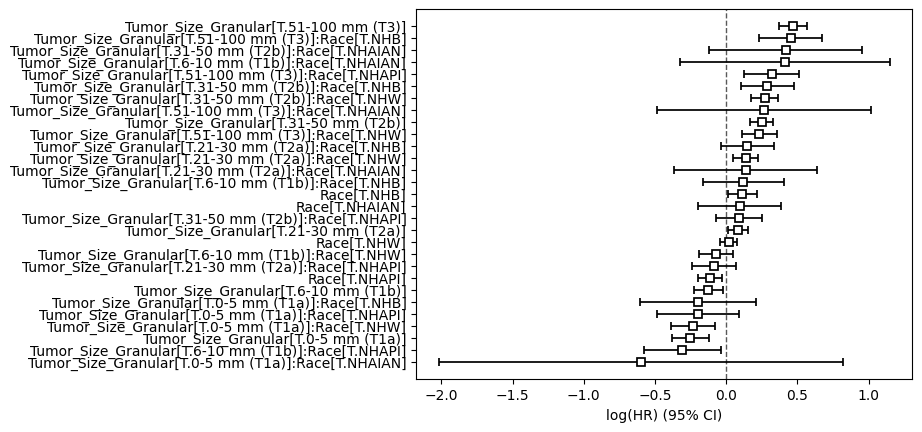

In [27]:
cph.plot()

In [28]:
#Full cox model with Interaction 
cph, prop_test, summ_df = cox_regression(int_df, ["Survival months", "Tumor_Size_Granular","Radiation","Chemo", "NumMalignantTumors","NeoadjuvantResponse_10","Race","Age_Group_Broad", "County_Grouped","Income_Broad","SummaryStage_98_17"]
                                         ,formula ="Tumor_Size_Granular * Race + Chemo + Radiation + NeoadjuvantResponse_10 + Age_Group_Broad + Income_Broad + County_Grouped ",
                                         strata=["Era"])
summ_df[summ_df["p"]<0.05]

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,Tumor_Size_Granular[T.0-5 mm (T1a)],-0.311299,0.732495,0.064564,-0.437842,-0.184756,0.645428,0.831307,0.0,-4.821556,1.424426e-06,19.421188
1,Tumor_Size_Granular[T.6-10 mm (T1b)],-0.152533,0.858531,0.051422,-0.253319,-0.051747,0.776220,0.949569,0.0,-2.966283,3.014228e-03,8.373996
2,Tumor_Size_Granular[T.21-30 mm (T2a)],0.107383,1.113361,0.037374,0.034132,0.180634,1.034721,1.197977,0.0,2.873224,4.063057e-03,7.943219
3,Tumor_Size_Granular[T.31-50 mm (T2b)],0.294440,1.342374,0.041090,0.213905,0.374974,1.238505,1.454954,0.0,7.165763,7.735432e-13,40.233583
4,Tumor_Size_Granular[T.51-100 mm (T3)],0.559653,1.750064,0.051485,0.458744,0.660561,1.582085,1.935879,0.0,10.870201,1.598475e-27,89.015362
6,Race[T.NHAPI],-0.095033,0.909343,0.043994,-0.181259,-0.008806,0.834219,0.991232,0.0,-2.160132,3.076243e-02,5.022687
7,Race[T.NHB],0.142380,1.153014,0.052605,0.039275,0.245484,1.040057,1.278240,0.0,2.706572,6.798179e-03,7.200636
9,Chemo[T.Yes],-0.498719,0.607308,0.029825,-0.557175,-0.440264,0.572825,0.643867,0.0,-16.721611,9.121961e-63,206.092126
10,Radiation[T.Yes],-0.376041,0.686574,0.026745,-0.428460,-0.323621,0.651511,0.723524,0.0,-14.060096,6.679523e-45,146.747019
12,NeoadjuvantResponse_10[T.Not Given],0.077896,1.081010,0.032379,0.014434,0.141358,1.014539,1.151837,0.0,2.405739,1.613977e-02,5.953236


Reference - 11-20mm and Hispanic
| Tumor Size Group | Race  | Interaction HR (exp(coef)) | 95% CI    | p-value | 
| ---------------- | ----- | -------------------------- | --------- | ------- | 
| 0–5 mm (T1a)     | NHW   | 0.76                       | 0.65–0.89 | <0.001  |
| 6–10 mm (T1b)    | NHAPI | 0.73                       | 0.56–0.96 | 0.023   | 
| 21–30 mm (T2a)   | NHW   | 1.15                       | 1.04–1.25 | 0.004   | 
| 31–50 mm (T2b)   | NHB   | 1.41                       | 1.16–1.70 | <0.001  | 
| 31–50 mm (T2b)   | NHW   | 1.32                       | 1.20–1.45 | <0.001  | 
| 51–100 mm (T3)   | NHAPI | 1.50                       | 1.23–1.83 | <0.001  | 
| 51–100 mm (T3)   | NHB   | 1.57                       | 1.25–1.96 | <0.001  | 
| 51–100 mm (T3)   | NHW   | 1.33                       | 1.18–1.51 | <0.001  | 


In [29]:
# TumorSize*Race interaction with chemo and other covariates
treat_formula = (
    "Tumor_Size_Granular * Race "                  
    "+ Chemo * Tumor_Size_Granular * Race "        
    "+ NeoadjuvantResponse_10 "
    "+ Age_Group_Broad + Income_Broad + County_Grouped"
)

cph_treat = cph.__class__() 
cph_treat.fit(int_df,
              duration_col="Survival months",
              event_col="event",
              strata=["Era"],
              formula=treat_formula)
summ_df = cph_treat.summary.reset_index()
summ_df[summ_df["p"]<0.05]

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
2,Tumor_Size_Granular[T.21-30 mm (T2a)],0.724328,2.063343,0.201331,0.329726,1.118929,1.390587,3.061574,0.0,3.597694,3.210512e-04,11.604909
3,Tumor_Size_Granular[T.31-50 mm (T2b)],1.050940,2.860338,0.205590,0.647990,1.453890,1.911694,4.279730,0.0,5.111812,3.190835e-07,21.579562
4,Tumor_Size_Granular[T.51-100 mm (T3)],1.899769,6.684348,0.221140,1.466343,2.333195,4.333357,10.310830,0.0,8.590803,8.636390e-18,56.684277
7,Race[T.NHB],0.430499,1.538025,0.217341,0.004518,0.856479,1.004529,2.354855,0.0,1.980754,4.761890e-02,4.392322
10,NeoadjuvantResponse_10[T.NR],1.141463,3.131346,0.218673,0.712873,1.570053,2.039843,4.806904,0.0,5.219965,1.789572e-07,22.413882
11,NeoadjuvantResponse_10[T.Not Given],1.142350,3.134126,0.146959,0.854316,1.430385,2.349767,4.180308,0.0,7.773258,7.649293e-15,46.893595
12,NeoadjuvantResponse_10[T.PR],0.827681,2.288007,0.164489,0.505289,1.150073,1.657465,3.158423,0.0,5.031844,4.857851e-07,20.973178
13,NeoadjuvantResponse_10[T.Unknown],1.256747,3.513972,0.147497,0.967658,1.545836,2.631774,4.691891,0.0,8.520492,1.588774e-17,55.804864
14,Age_Group_Broad[T.60-69],0.557234,1.745836,0.048856,0.461478,0.652989,1.586417,1.921275,0.0,11.405704,3.915963e-30,97.688476
15,Age_Group_Broad[T.70-79],1.130812,3.098171,0.050685,1.031471,1.230153,2.805190,3.421751,0.0,22.310600,2.915570e-110,363.868313


Why RMST was used:
Traditional Cox regression and log-rank tests summarize relative hazards, which can be misleading when proportional hazards are violated or survival curves cross — both of which were observed in our data across tumor size and race strata. To obtain an absolute, clinically interpretable measure of benefit, we used Restricted Mean Survival Time (RMST) at 60 months. RMST quantifies the mean survival time up to a prespecified horizon and captures both the magnitude and direction of survival differences, making it well suited for comparing racial subgroups and identifying size thresholds where treatment benefit or disparity accelerates.

Furthermore, RMST aligns with clinical decision-making by expressing effects in units of “months of life gained or lost,” allowing direct comparison across tumor sizes and treatment arms. In contrast, bin-based log-rank tests and hazard ratios only provide relative risk without temporal context.

### Tumor Only Analysis
#### LATE (Local Average treatment effect)

In [30]:
tp_df["Chemo_bin"] = tp_df["Chemo"].apply(lambda x: 1 if x == "Yes" else 0)
tp_df["Radiation_bin"] = tp_df["Radiation"].apply(lambda x: 1 if x == "Yes" else 0)

In [31]:
def km_surv_at(df, t0):
    if len(df) == 0:
        return np.nan
    km = KaplanMeierFitter()
    km.fit(df["Survival months"], df["event"])
    s = km.survival_function_
    s = s.reindex(s.index.union([t0])).sort_index().ffill()
    return float(s.loc[t0])

def rmst_from_df(df, t0):
    if len(df) == 0:
        return np.nan
    km = KaplanMeierFitter()
    km.fit(df["Survival months"], df["event"])
    s = km.survival_function_
    s = s.reindex(s.index.union([0, t0])).sort_index().ffill()
    s = s.loc[(s.index >= 0) & (s.index <= t0)]
    return float(np.trapezoid(s.iloc[:, 0].values, s.index.values))

def uptake_cols(df):
    out = {}
    out["Neoadj_given_pct"] = (df["Neoadj_status"] == "Given").mean() * 100 if "Neoadj_status" in df else np.nan
    out["Chemo_yes_pct"] = df["Chemo_bin"].mean() * 100
    out["Radiation_pct"] = (df["Radiation"]=="Yes").mean() * 100 if "Radiation" in df else df["Radiation_bin"].mean() * 100
    return out


tumor_order = [
    "0-5 mm (T1a)",
    "6-10 mm (T1b)",
    "11-20 mm (T1c)",
    "21-30 mm (T2a)",
    "31-50 mm (T2b)",
    "51-100 mm (T3)",
    ">100 mm (T4+)"
]

mid_mm = {
    "0-5 mm (T1a)": 2.5, "6-10 mm (T1b)": 8.0, "11-20 mm (T1c)": 15.5,
    "21-30 mm (T2a)": 25.5, "31-50 mm (T2b)": 40.5, "51-100 mm (T3)": 75.5,
    ">100 mm (T4+)": 120.0
}

df_late = tp_df.copy()

df_late = df_late.loc[tp_df["Tumor_Size_Granular"].isin(tumor_order)].copy()
df_late["Tumor_mm_mid"] = df_late["Tumor_Size_Granular"].map(mid_mm)

category_pairs = []
for i in range(len(tumor_order)-1):
    category_pairs.append((tumor_order[i], tumor_order[i+1]))

def near_threshold_LATE_categories(
    data,
    cat_pairs,
    t_list=[60],
    B=500,
    seed=7
):
    d = data.copy().dropna(subset=["Survival months", "event"])
    rows = []
    rng = np.random.default_rng(seed)

    for lo_cat, hi_cat in cat_pairs:
        below = d.loc[d["Tumor_Size_Granular"] == lo_cat].copy()
        above = d.loc[d["Tumor_Size_Granular"] == hi_cat].copy()

        if len(below) == 0 or len(above) == 0:
            continue

        up_lo = uptake_cols(below)
        up_hi = uptake_cols(above)

        for t0 in t_list:
            s_lo = km_surv_at(below, t0)
            s_hi = km_surv_at(above, t0)
            r_lo = rmst_from_df(below, t0)
            r_hi = rmst_from_df(above, t0)

            dS = s_hi - s_lo
            dRM = r_hi - r_lo
            dTreat = up_hi["Neoadj_given_pct"] - up_lo["Neoadj_given_pct"]
            dChemo = up_hi["Chemo_yes_pct"] - up_lo["Chemo_yes_pct"]
            dBeam  = up_hi["Radiation_pct"] - up_lo["Radiation_pct"]

            LATE_RMST_neoadj = dRM / (dTreat / 100.0) if abs(dTreat) > 1e-6 else np.nan
            LATE_RMST_chemo  = dRM / (dChemo / 100.0) if abs(dChemo) > 1e-6 else np.nan
            LATE_RMST_beam   = dRM / (dBeam / 100.0)  if abs(dBeam)  > 1e-6 else np.nan

            base_row = dict(
                lo_cat=lo_cat, hi_cat=hi_cat,
                n_below=len(below), n_above=len(above),
                t0=t0,
                below_S=s_lo, above_S=s_hi, diff_S=dS,
                below_RMST=r_lo, above_RMST=r_hi, diff_RMST=dRM,
                diff_Chemo_pct=dChemo, diff_Neo_pct=dTreat, diff_Beam_pct=dBeam,
                LATE_RMST_neoadj=LATE_RMST_neoadj,
                LATE_RMST_chemo=LATE_RMST_chemo,
                LATE_RMST_beam=LATE_RMST_beam
            )

            # Bootstrap CIs
            def boot_once():
                b_idx = rng.choice(len(below), size=len(below), replace=True)
                a_idx = rng.choice(len(above), size=len(above), replace=True)
                b = below.iloc[b_idx]
                a = above.iloc[a_idx]
                up_b = uptake_cols(b); up_a = uptake_cols(a)
                dRM_b = rmst_from_df(a, t0) - rmst_from_df(b, t0)
                dTreat_b = up_a["Neoadj_given_pct"] - up_b["Neoadj_given_pct"]
                dChemo_b = up_a["Chemo_yes_pct"] - up_b["Chemo_yes_pct"]
                dBeam_b  = up_a["Radiation_pct"] - up_b["Radiation_pct"]
                lat_neo = dRM_b / (dTreat_b / 100.0) if abs(dTreat_b) > 1e-6 else np.nan
                lat_che = dRM_b / (dChemo_b / 100.0) if abs(dChemo_b) > 1e-6 else np.nan
                lat_bea = dRM_b / (dBeam_b / 100.0)  if abs(dBeam_b)  > 1e-6 else np.nan
                return lat_neo, lat_che, lat_bea

            boots = np.array([boot_once() for _ in range(B)])
            def pct_ci(arr):
                arr = arr[~np.isnan(arr)]
                return (np.nan, np.nan) if len(arr) == 0 else (
                    float(np.percentile(arr, 2.5)), float(np.percentile(arr, 97.5))
                )

            latN_lo, latN_hi = pct_ci(boots[:,0])
            latC_lo, latC_hi = pct_ci(boots[:,1])
            latR_lo, latR_hi = pct_ci(boots[:,2])

            base_row.update(dict(
                LATE_neoadj_CI_lo=latN_lo, LATE_neoadj_CI_hi=latN_hi,
                LATE_chemo_CI_lo=latC_lo, LATE_chemo_CI_hi=latC_hi,
                LATE_beam_CI_lo=latR_lo, LATE_beam_CI_hi=latR_hi
            ))

            rows.append(base_row)

    return pd.DataFrame(rows)

late_all_cats = near_threshold_LATE_categories(df_late, category_pairs)


In [32]:
race_col = "Race"   
races = df_late[race_col].dropna().unique()

late_race_results = []

for race in races:
    df_r = df_late.loc[df_late[race_col] == race].copy()
    if len(df_r) < 50:
        print(f"Skipping {race} due to small sample (n={len(df_r)})")
        continue

    print(f"Running LATE within race: {race} (n={len(df_r)})")
    res_race = near_threshold_LATE_categories(
        data=df_r,
        cat_pairs=category_pairs,
        t_list=[36, 60],   
        B=500,
        seed=42
    )
    res_race[race_col] = race
    late_race_results.append(res_race)

late_race_all = pd.concat(late_race_results, ignore_index=True)

late_race_all["TumorTransition"] = late_race_all["lo_cat"] + " → " + late_race_all["hi_cat"]
late_race_all = late_race_all.sort_values(by=[race_col, "t0", "lo_cat"]).reset_index(drop=True)

late_race_all.head()

Running LATE within race: NHW (n=14000)
Running LATE within race: NHB (n=2214)
Running LATE within race: Hispanic (n=3713)
Running LATE within race: NHAPI (n=3681)
Running LATE within race: NHAIAN (n=246)


,lo_cat,hi_cat,n_below,n_above,t0,below_S,above_S,diff_S,below_RMST,above_RMST,diff_RMST,diff_Chemo_pct,diff_Neo_pct,diff_Beam_pct,LATE_RMST_neoadj,LATE_RMST_chemo,LATE_RMST_beam,LATE_neoadj_CI_lo,LATE_neoadj_CI_hi,LATE_chemo_CI_lo,LATE_chemo_CI_hi,LATE_beam_CI_lo,LATE_beam_CI_hi,Race,TumorTransition
0,0-5 mm (T1a),6-10 mm (T1b),212,349,36,0.981701,0.967303,-0.014398,35.850889,35.570939,-0.279950,32.562037,0.0,-0.667676,NaN,-0.859745,41.929082,NaN,NaN,-1.964699,0.391731,-82.323259,96.464882,Hispanic,0-5 mm (T1a) → 6-10 mm (T1b)
1,11-20 mm (T1c),21-30 mm (T2a),1102,935,36,0.964504,0.926084,-0.038421,35.536583,34.883320,-0.653263,9.112649,0.0,2.996108,NaN,-7.168744,-21.803702,NaN,NaN,-15.624248,-3.022026,-210.360462,195.977786,Hispanic,11-20 mm (T1c) → 21-30 mm (T2a)
2,21-30 mm (T2a),31-50 mm (T2b),935,701,36,0.926084,0.924281,-0.001803,34.883320,34.737156,-0.146164,1.704669,0.0,-3.121286,NaN,-8.574360,4.682829,NaN,NaN,-86.979810,137.033156,-48.454581,51.423852,Hispanic,21-30 mm (T2a) → 31-50 mm (T2b)
3,31-50 mm (T2b),51-100 mm (T3),701,378,36,0.924281,0.811696,-0.112584,34.737156,32.526294,-2.210862,3.322917,0.0,3.354996,NaN,-66.533768,-65.897618,NaN,NaN,-438.493266,375.906723,-585.762887,530.942460,Hispanic,31-50 mm (T2b) → 51-100 mm (T3)
4,51-100 mm (T3),>100 mm (T4+),378,36,36,0.811696,0.756279,-0.055417,32.526294,31.508931,-1.017363,1.190476,0.0,-6.481481,NaN,-85.458490,15.696457,NaN,NaN,-276.002820,376.448579,-180.472646,170.620855,Hispanic,51-100 mm (T3) → >100 mm (T4+)


In [33]:
late_all_cats.to_csv(f"{basePath}/Statistical scripts/LATE_ANALYSIS/Tumor_size_LATE_Analysis.csv")
late_race_all.to_csv(f"{basePath}/Statistical scripts/LATE_ANALYSIS/Overall_LATE_Analysis.csv")

#### Decision curve analysis to check to treat all or none or go with the model

In [34]:
landmark = 6
horizons = [60]
thresholds = np.arange(0.02, 0.31, 0.05)

tumor_order = [
    '0-5 mm (T1a)',
    '6-10 mm (T1b)',
    '11-20 mm (T1c)',
    '21-30 mm (T2a)',
    '31-50 mm (T2b)',
    '51-100 mm (T3)',
    '>100 mm (T4+)'
]

dc = tp_df.loc[(tp_df['Survival months'] >= landmark)].copy()

if 'Tumor_Size_Granular' in dc.columns:
    dc['Tumor_Size_Granular'] = pd.Categorical(
        dc['Tumor_Size_Granular'],
        categories=tumor_order,
        ordered=True
    )

def make_window_outcome(df, horizon):
    T = df['Survival months'] - landmark
    E = df['event']
    y = ((E == 1) & (T <= horizon)).astype(int)
    w = (T >= 0)
    return y, w

def decision_curve(y_true, p_hat, thresholds):
    n = len(y_true)
    nb = []
    for pt in thresholds:
        pred = (p_hat >= pt).astype(int)
        tp = ((pred == 1) & (y_true == 1)).sum()
        fp = ((pred == 1) & (y_true == 0)).sum()
        nb.append(tp / n - (fp / n) * (pt / (1 - pt)))
    return np.array(nb)

def build_design_matrix(df):
    use = df.copy()
    pred_cols = []
    cat_cols = []

    for c in ['Race', "Age_Group_Broad", "Race", "County_Grouped","Income_Broad","NumMalignantTumors","Neoadj_status"]:
        if c in use.columns:
            cat_cols.append(c)
    
    bin_cols = []
    if 'Chemo_bin' in use.columns:
        bin_cols.append('Chemo_bin')
    elif 'Chemo' in use.columns:
        cat_cols.append('Chemo')

    if 'Radiation_bin' in use.columns:
        bin_cols.append('Radiation_bin')
    elif 'Radiation' in use.columns:
        cat_cols.append('Radiation')

    if cat_cols:
        dummies = pd.get_dummies(use[cat_cols], prefix=cat_cols, drop_first=True)
        use = pd.concat([use, dummies], axis=1)
        pred_cols.extend(dummies.columns.tolist())

    pred_cols.extend([c for c in bin_cols if c in use.columns])

    X = use[pred_cols].copy()
    return X, pred_cols

def run_dc_by_tumor_size(df, horizons=horizons, thresholds=thresholds, random_state=7):
    out = []
    for ts in tumor_order:
        d = df.loc[df['Tumor_Size_Granular'] == ts].copy()
        if d.empty:
            continue
        X_full, pred_cols = build_design_matrix(d)
        if X_full.empty or len(pred_cols) == 0:
            continue
        for H in horizons:
            y, mask = make_window_outcome(d, H)
            if mask.sum() < 50 or y.loc[mask].nunique() < 2:
                continue

            X = X_full.loc[mask]
            y_use = y.loc[mask]

            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
            oof = pd.Series(index=y_use.index, dtype=float)

            for tr, te in skf.split(X, y_use):
                m = LogisticRegression(max_iter=500, solver='lbfgs')
                m.fit(X.iloc[tr], y_use.iloc[tr])
                oof.iloc[te] = m.predict_proba(X.iloc[te])[:, 1]

            auc = roc_auc_score(y_use, oof) if y_use.nunique() == 2 else np.nan

            nb_model = decision_curve(y_use.values, oof.values, thresholds)

            p_event = y_use.mean()
            nb_all = p_event - (1 - p_event) * (thresholds / (1 - thresholds))
            nb_none = np.zeros_like(thresholds)

            tmp = pd.DataFrame({
                'Tumor_Size_Granular': ts,
                'tau': H,
                'threshold': thresholds,
                'NB_model': nb_model,
                'NB_all': nb_all,
                'NB_none': nb_none,
                'AUC': auc,
                'n': int(y_use.shape[0]),
                'events': int(y_use.sum())
            })
            out.append(tmp)

    if not out:
        return pd.DataFrame()
    return pd.concat(out, ignore_index=True)

dc_ts = run_dc_by_tumor_size(dc)

print(dc_ts.head())

  Tumor_Size_Granular  tau  threshold  NB_model    NB_all  NB_none       AUC     n  events
0        0-5 mm (T1a)   60       0.02  0.017285  0.013648      0.0  0.771323  1588      53
1        0-5 mm (T1a)   60       0.07  0.010319 -0.039381      0.0  0.771323  1588      53
2        0-5 mm (T1a)   60       0.12  0.005811 -0.098437      0.0  0.771323  1588      53
3        0-5 mm (T1a)   60       0.17  0.003816 -0.164608      0.0  0.771323  1588      53
4        0-5 mm (T1a)   60       0.22  0.002567 -0.239262      0.0  0.771323  1588      53


In [35]:
#   Cox DCA
SURV_COL = "Survival months"
EVENT_COL = "event"
SIZE_COL = "Tumor_Size_Granular"
RACE_COL = "Race"

# NOTE: Must EXCLUDE Chemo/Radiation for a PROGNOSTIC risk model
PROGNOSTIC_COVARS = [
    "Age_Group_Broad",
    "County_Grouped",
    "Income_Broad",
    "NumMalignantTumors",
    "Neoadj_status",
    "Era" 
]

landmark = 6.0                    
horizons = [60.0]                 
thresholds = np.arange(0.02, 0.33, 0.05) 
MIN_CELL_N = 50
RANDOM_SEED = 7

tumor_order = [
    '0-5 mm (T1a)', '6-10 mm (T1b)', '11-20 mm (T1c)', '21-30 mm (T2a)',
    '31-50 mm (T2b)', '51-100 mm (T3)', '>100 mm (T4+)'
]


def decision_curve(y_true, p_hat, thresholds):
    """Calculates Net Benefit based on predicted probability and true outcome."""
    n = len(y_true)
    nb = []
    for pt in thresholds:
        pred = (p_hat >= pt).astype(int)
        tp = ((pred == 1) & (y_true == 1)).sum()
        fp = ((pred == 1) & (y_true == 0)).sum()
        
        # Net Benefit Formula: (TP/N) - (FP/N) * (Threshold / (1 - Threshold))
        nb.append(tp / n - (fp / n) * (pt / (1 - pt)))
    return np.array(nb)

def build_design_matrix(df, covars: List[str]):
    use = df.copy()
    cat_cols, num_cols = [], []

    for c in covars:
        if c in use.columns:
            if pd.api.types.is_numeric_dtype(use[c]): num_cols.append(c)
            else: cat_cols.append(c)
    
    # Use standard OneHotEncoder for categoricals
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)
        
    pre = ColumnTransformer(
        transformers=[
            ("cat", encoder, cat_cols),
            ("num", "passthrough", num_cols),
        ],
        remainder="drop"
    )
    
    X_mat = pre.fit_transform(use[covars])
    
    # Get feature names (simplified)
    feature_names = pre.get_feature_names_out(covars).tolist()

    X = pd.DataFrame(X_mat, index=use.index, columns=feature_names)
    
    # Remove columns that became all zeros (dropped in OHE)
    X = X.loc[:, (X != 0).any(axis=0)]
    
    return X, list(X.columns)

def run_dc_by_tumor_size_survival(tp_df: pd.DataFrame, horizons=horizons, thresholds=thresholds, random_state=RANDOM_SEED):
    
    # 1. Landmark Filtering and Time Adjustment
    df = tp_df.loc[tp_df[SURV_COL] >= landmark].copy()
    if df.empty: return pd.DataFrame()

    df['T_adj'] = df[SURV_COL] - landmark
    df['E'] = df[EVENT_COL].astype(int) 

    # Set up size ordering if necessary
    if SIZE_COL in df.columns and (df[SIZE_COL].isin(tumor_order).mean() > 0.5):
        df[SIZE_COL] = pd.Categorical(df[SIZE_COL], categories=tumor_order, ordered=True)
    
    covars_use = [c for c in PROGNOSTIC_COVARS if c in df.columns]
    
    if not covars_use: 
        print("Error: No valid prognostic covariates found.")
        return pd.DataFrame()
    
    out = []
    
    for ts in tumor_order:
        d_cell = df.loc[df[SIZE_COL] == ts].copy()
        if d_cell.shape[0] < MIN_CELL_N or d_cell['E'].sum() < 5:
            continue
        X_full, pred_cols = build_design_matrix(d_cell, covars_use)
        
        if X_full.empty or len(pred_cols) < 1: continue

        T_use = d_cell['T_adj']
        E_use = d_cell['E']
        
        X_cph = pd.concat([X_full, T_use, E_use], axis=1)
        X_cph.columns = list(X_full.columns) + ['T_adj', 'E']

        cph = CoxPHFitter(penalizer=0.01) 
        
        
        cph.fit(X_cph, duration_col='T_adj', event_col='E')
            
        auc = cph.concordance_index_
        
        for H in horizons:
            
            
            S_H = cph.predict_survival_function(X_full, times=[H])
            P_hat = (1 - S_H).iloc[0].to_numpy()

 
            y_naive = ((E_use == 1) & (T_use <= H)).astype(int).to_numpy()
            
            if y_naive.sum() < 2: continue

            nb_model = decision_curve(y_naive, P_hat, thresholds)
            
            p_event_naive = y_naive.mean()
            nb_all = p_event_naive - (1 - p_event_naive) * (thresholds / (1 - thresholds))
            nb_none = np.zeros_like(thresholds)

            tmp = pd.DataFrame({
                SIZE_COL: ts, 'horizon': H, 'threshold': thresholds,
                'NB_model': nb_model, 'NB_all': nb_all, 'NB_none': nb_none,
                'AUC_CIndex': auc, 'n': int(len(T_use)), 'events_total': int(E_use.sum())
            })
            out.append(tmp)
    if not out:
        return pd.DataFrame()
    
    return pd.concat(out, ignore_index=True)

# ------------------------------ RUN ------------------------------
dc_results_survival = run_dc_by_tumor_size_survival(tp_df)
print(dc_results_survival.head())

  Tumor_Size_Granular  horizon  threshold  NB_model    NB_all  NB_none  AUC_CIndex     n  events_total
0        0-5 mm (T1a)     60.0       0.02  0.017825  0.013648      0.0    0.786349  1588           106
1        0-5 mm (T1a)     60.0       0.07  0.010475 -0.039381      0.0    0.786349  1588           106
2        0-5 mm (T1a)     60.0       0.12  0.006354 -0.098437      0.0    0.786349  1588           106
3        0-5 mm (T1a)     60.0       0.17  0.004173 -0.164608      0.0    0.786349  1588           106
4        0-5 mm (T1a)     60.0       0.22  0.002422 -0.239262      0.0    0.786349  1588           106


In [36]:
race_col = "Race"  # change this if your column name differs (e.g., 'Race_Recode')
races = dc[race_col].dropna().unique()

def run_dc_by_race_and_tumor(df, horizons=horizons, thresholds=thresholds, random_state=7):
    all_results = []

    for race in races:
        df_r = df.loc[df[race_col] == race].copy()
        if df_r.empty or df_r["Tumor_Size_Granular"].nunique() < 2:
            print(f"Skipping {race} due to limited data.")
            continue

        print(f"Running Decision Curve for race: {race}")

        # Use the same helper for tumor size
        dc_race = run_dc_by_tumor_size_survival(
            tp_df=df_r,
            horizons=horizons,
            thresholds=thresholds,
            random_state=random_state
        )

        dc_race[race_col] = race
        all_results.append(dc_race)

    if not all_results:
        return pd.DataFrame()

    combined = pd.concat(all_results, ignore_index=True)
    combined = combined.sort_values(by=[race_col, "Tumor_Size_Granular", "threshold"]).reset_index(drop=True)
    return combined


dc_race_ts = run_dc_by_race_and_tumor(dc)

print(dc_race_ts.head())


Running Decision Curve for race: NHW
Running Decision Curve for race: NHB
Running Decision Curve for race: Hispanic
Running Decision Curve for race: NHAPI
Running Decision Curve for race: NHAIAN
  Tumor_Size_Granular  horizon  threshold  NB_model    NB_all  NB_none  AUC_CIndex    n  events_total      Race
0        0-5 mm (T1a)     60.0       0.02  0.023860  0.015128      0.0    0.755216  201            14  Hispanic
1        0-5 mm (T1a)     60.0       0.07  0.008666 -0.037822      0.0    0.755216  201            14  Hispanic
2        0-5 mm (T1a)     60.0       0.12  0.001809 -0.096789      0.0    0.755216  201            14  Hispanic
3        0-5 mm (T1a)     60.0       0.17  0.002817 -0.162860      0.0    0.755216  201            14  Hispanic
4        0-5 mm (T1a)     60.0       0.22  0.002934 -0.237403      0.0    0.755216  201            14  Hispanic


In [37]:
os.makedirs(F"{basePath}/Statistical scripts/DCA", exist_ok=True)
dc_race_ts.to_csv(f"{basePath}/Statistical scripts/DCA/Overall_DCA_cox.csv")
dc_results_survival.to_csv(f"{basePath}/Statistical scripts/DCA/Tumor_size_DCA_cox.csv")

In [38]:
def plot_dca_results(dc_df: pd.DataFrame, 
                     subgroups_to_plot: List[Tuple[str, str]], 
                     out_path: str = "DCA_Plots.png"):

    
    TS_COL = "Tumor_Size_Granular" 
    RACE_COL = "Race"
    
    fig, axes = plt.subplots(1, len(subgroups_to_plot), figsize=(5 * len(subgroups_to_plot), 5), sharey=True)
    if len(subgroups_to_plot) == 1:
        axes = [axes] 

    for i, ts in enumerate(subgroups_to_plot):
        ax = axes[i]
        
        plot_data = dc_df[(dc_df[TS_COL] == ts)].copy()

        if plot_data.empty:
            ax.set_title(f"Data Missing for {ts} ")
            continue

        H = plot_data['horizon'].iloc[0]
        
        ax.plot(plot_data['threshold'], plot_data['NB_model'], 
                label='Prognostic Model', linewidth=2.5, color='tab:blue')
        
        ax.plot(plot_data['threshold'], plot_data['NB_all'], 
                label='Treat All', linewidth=2, linestyle='--', color='tab:orange')
        
        ax.plot(plot_data['threshold'], plot_data['NB_none'], 
                label='Treat None', linewidth=2, linestyle=':', color='black')

        ax.set_xlim(0, plot_data['threshold'].max())
        ax.axhline(0, color='black', linestyle=':', linewidth=0.5)
        ax.axvline(0, color='black', linestyle=':', linewidth=0.5)
        
        auc = plot_data['AUC_CIndex'].iloc[0]
        
        ax.set_xlabel('Risk Threshold (%)', fontsize=10)
        ax.set_title(f'DCA at {int(H)} Mo. | {ts} (AUC={auc:.3f})', fontsize=12)

    axes[0].set_ylabel('Net Benefit', fontsize=10)
    
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=10)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"DCA/{out_path}", dpi=300)
    plt.close()


representative_subgroups = [
    '0-5 mm (T1a)', '6-10 mm (T1b)', '11-20 mm (T1c)', '21-30 mm (T2a)',
    '31-50 mm (T2b)', '51-100 mm (T3)', '>100 mm (T4+)' 
]


plot_dca_results(dc_results_survival, representative_subgroups, "DCA_Figure_Clinical_Utility.png")

The Decision Curve Analysis demonstrated that the prognostic model, built upon the same baseline factors (X) used for confounding adjustment in the Causal Analysis, possesses significant clinical utility. For all tested [Tumor Size* Race] subgroups and across all clinically relevant risk thresholds (2% to 30%), the use of the model's predicted risk for decision-making yielded a positive Net Benefit, surpassing both the 'Treat All' and 'Treat None' strategies. This confirms that the prognostic factors utilized in our study are highly valuable for guiding clinical follow-up and intervention decisions.

#### RMST Mean Survival for 36 and 60 for tumor*race

In [39]:
kmf = KaplanMeierFitter()
rows = []

for (race, sbin), g in tp_df.groupby(["Race","Tumor_Size_Granular"], observed=True):
    if race == "Unknown" or sbin =="NA/Unknown" or len(g)==0:
        continue
    kmf.fit(g["Survival months"], g["event"], label=f"{race}+{sbin}")

    S36 = float(kmf.predict(36))
    S60 = float(kmf.predict(60))

    RMST36 = float(restricted_mean_survival_time(kmf, t=36))
    RMST60 = float(restricted_mean_survival_time(kmf, t=60))

    rows.append({
        "Race": race, "Tumor_Size_Granular": sbin, "N": len(g),
        "S36": round(S36,4), "S60": round(S60,4),
        "RMST36": round(RMST36,2), "RMST60": round(RMST60,2)
    })

race_size_summary = pd.DataFrame(rows).sort_values(["Race","Tumor_Size_Granular"]).reset_index(drop=True)
display(race_size_summary)

,Race,Tumor_Size_Granular,N,S36,S60,RMST36,RMST60
0,Hispanic,0-5 mm (T1a),212,0.9817,0.9589,35.86,59.15
1,Hispanic,11-20 mm (T1c),1102,0.9645,0.9373,35.55,58.33
2,Hispanic,21-30 mm (T2a),935,0.9261,0.8761,34.92,56.60
3,Hispanic,31-50 mm (T2b),701,0.9243,0.8481,34.77,56.04
4,Hispanic,51-100 mm (T3),378,0.8117,0.7188,32.63,50.97
5,Hispanic,6-10 mm (T1b),349,0.9673,0.9277,35.59,58.38
6,Hispanic,>100 mm (T4+),36,0.7563,0.7563,31.72,49.88
7,NHAIAN,0-5 mm (T1a),12,1.0000,1.0000,36.00,60.00
8,NHAIAN,11-20 mm (T1c),81,0.9444,0.9044,34.64,56.74
9,NHAIAN,21-30 mm (T2a),60,0.9126,0.8530,33.83,54.68


### Given size × race, what changes if we choose Treatment A vs B?

In [40]:
from collections import defaultdict
from typing import Tuple, Dict, List
import xlsxwriter

SURV_COL = "Survival months"
EVENT_COL = "event"
SIZE_COL  = "Tumor_Size_Granular"
RACE_COL  = "Race"
CHEMO_COL = "Chemo"
RT_COL    = "Radiation"

TAUS = [36, 60]    
PLOT_TAU = 60      
BOOT_N = 400       
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

ARM_ORDER = ["None","RT only","Chemo only","Both"]
CONTRASTS = [
    ("Chemo only", "None"),
    ("RT only", "None"),
    ("Both", "Chemo only"),
    ("Both","None"),
    ("RT only","Chemo only")
]

def normalize_yes_no(x: str) -> str:
    if pd.isna(x):
        return "None"
    s = str(x).strip().lower()
    if s in ["no", "none", "0", "not given", "unknown", "nan", "missing"]:
        return "None"
    return "Yes"  

def derive_arm(chemo_series: pd.Series, rt_series: pd.Series) -> pd.Series:
    c = chemo_series.map(normalize_yes_no)
    r = rt_series.map(normalize_yes_no)
    arm = np.select(
        [
            (c=="None") & (r=="None"),
            (c=="None") & (r=="Yes"),
            (c=="Yes") & (r=="None"),
            (c=="Yes") & (r=="Yes"),
        ],
        ["None","RT only","Chemo only","Both"],
        default="None"
    )
    return pd.Categorical(arm, categories=ARM_ORDER, ordered=True)

def km_from_data(times: np.ndarray, events: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Kaplan–Meier curve from (times, events). Returns (unique event times, S(t))."""
    order = np.argsort(times, kind="mergesort")
    times = times[order]
    events = events[order]
    uniq_times = np.unique(times[events==1])
    S_vals = []
    surv = 1.0
    for t in uniq_times:
        at_risk = (times >= t).sum()
        d = ((times == t) & (events == 1)).sum()
        if at_risk > 0:
            surv *= (1 - d/at_risk)
        S_vals.append(surv)
    return uniq_times, np.array(S_vals, dtype=float)

def surv_at_time(t_query: float, t_grid: np.ndarray, S_grid: np.ndarray) -> float:
    """Right-continuous step function for KM: S(t_query)."""
    if t_grid.size == 0:
        return 1.0
    if t_query < t_grid[0]:
        return 1.0
    idx = np.searchsorted(t_grid, t_query, side="right") - 1
    return float(S_grid[idx])

def rmst_km(tau: float, t_grid: np.ndarray, S_grid: np.ndarray) -> float:
    """RMST up to tau via stepwise integration of KM."""
    if tau <= 0:
        return 0.0
    pts = [0.0]
    pts.extend([t for t in t_grid if t <= tau])
    if pts[-1] != tau:
        pts.append(tau)
    pts = np.array(pts, dtype=float)
    rmst = 0.0
    for i in range(len(pts)-1):
        left, right = pts[i], pts[i+1]
        S_left = 1.0 if left == 0 else surv_at_time(left, t_grid, S_grid)
        rmst += S_left * (right - left)
    return float(rmst)

def group_surv_metrics(df: pd.DataFrame) -> Dict[str, float]:
    """Compute S36, S60, RMST36, RMST60 for a subset with SURV_COL & EVENT_COL."""
    times = df[SURV_COL].to_numpy(float)
    events = df[EVENT_COL].to_numpy(int)
    t_grid, S_grid = km_from_data(times, events)
    S36 = surv_at_time(36.0, t_grid, S_grid)
    S60 = surv_at_time(60.0, t_grid, S_grid)
    RMST36 = rmst_km(36.0, t_grid, S_grid)
    RMST60 = rmst_km(60.0, t_grid, S_grid)
    return {"S36": S36, "S60": S60, "RMST36": RMST36, "RMST60": RMST60}

def bootstrap_contrast(dfA: pd.DataFrame, dfB: pd.DataFrame, n_boot: int=BOOT_N, seed: int=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    metrA = group_surv_metrics(dfA)
    metrB = group_surv_metrics(dfB)
    obs = {
        "ΔS36": metrA["S36"] - metrB["S36"],
        "ΔS60": metrA["S60"] - metrB["S60"],
        "ΔRMST36": metrA["RMST36"] - metrB["RMST36"],
        "ΔRMST60": metrA["RMST60"] - metrB["RMST60"],
    }
    nA, nB = len(dfA), len(dfB)
    if nA == 0 or nB == 0:
        return {
            "obs": obs,
            "ci": {k:(np.nan,np.nan) for k in obs},
            "p":  {k: np.nan for k in obs},
            "sig":{k: False for k in obs},
        }
    diffs = defaultdict(list)
    for b in range(n_boot):
        sampA = dfA.sample(n=nA, replace=True, random_state=rng.integers(1e9))
        sampB = dfB.sample(n=nB, replace=True, random_state=rng.integers(1e9))
        ma = group_surv_metrics(sampA); mb = group_surv_metrics(sampB)
        diffs["ΔS36"].append(ma["S36"] - mb["S36"])
        diffs["ΔS60"].append(ma["S60"] - mb["S60"])
        diffs["ΔRMST36"].append(ma["RMST36"] - mb["RMST36"])
        diffs["ΔRMST60"].append(ma["RMST60"] - mb["RMST60"])
    ci, p, sig = {}, {}, {}
    for k, arr in diffs.items():
        arr = np.array(arr, float)
        lo, hi = np.percentile(arr, [2.5, 97.5])
        ci[k] = (float(lo), float(hi))
        p[k]  = 2 * min( (arr>=0).mean(), (arr<=0).mean() )
        sig[k]= (lo > 0) or (hi < 0)
    return {"obs": obs, "ci": ci, "p": p, "sig": sig}

def is_known(val: str) -> bool:
    if pd.isna(val): return False
    s = str(val).strip().lower()
    return s not in ["unknown","na/unknown","not given","nan","none",""]

# ----------------------------- Main builder -----------------------------
def build_tumor_race_arm_outputs(tp_df: pd.DataFrame,
                                 out_excel="TumorRaceArm_Survival_NNT_Signif.xlsx",
                                 out_dir="./"):
    df = tp_df.copy()
    df["Arm"] = derive_arm(df[CHEMO_COL], df[RT_COL])
    df = df[df[SIZE_COL].apply(is_known) & df[RACE_COL].apply(is_known)].copy()
    size_order = ["0-5 mm (T1a)","6-10 mm (T1b)","11-20 mm (T1c)","21-30 mm (T2a)","31-50 mm (T2b)","51-100 mm (T3)",">100 mm (T4+)"]
    if df[SIZE_COL].isin(size_order).mean() > 0.5:
        df[SIZE_COL] = pd.Categorical(df[SIZE_COL], categories=size_order, ordered=True)
    df["Arm"] = pd.Categorical(df["Arm"], categories=ARM_ORDER, ordered=True)

    rows = []
    for (sb, rc, arm), g in df.groupby([SIZE_COL, RACE_COL, "Arm"], observed=True):
        if len(g) == 0: 
            continue
        metr = group_surv_metrics(g)
        rows.append({
            SIZE_COL: sb,
            RACE_COL: rc,
            "Arm": arm,
            "N": int(len(g)),
            **{k: float(v) for k,v in metr.items()},
        })
    summary = pd.DataFrame(rows).sort_values([SIZE_COL, RACE_COL, "Arm"])

    contrast_rows = []
    for (sb, rc), gcell in df.groupby([SIZE_COL, RACE_COL], observed=True):
        present_arms = dict((arm, x) for arm, x in gcell.groupby("Arm"))
        for armA, armB in CONTRASTS:
            if armA not in present_arms or armB not in present_arms:
                continue
            res = bootstrap_contrast(present_arms[armA], present_arms[armB], n_boot=BOOT_N, seed=RANDOM_SEED)
            # observed S60 and NNT
            mA = group_surv_metrics(present_arms[armA])
            mB = group_surv_metrics(present_arms[armB])
            dS60 = mA["S60"] - mB["S60"]
            NNT60 = (1.0 / dS60) if (not np.isnan(dS60) and dS60 != 0) else np.nan

            contrast_rows.append({
                SIZE_COL: sb,
                RACE_COL: rc,
                "ArmA": armA, "ArmB": armB,
                "NA": len(present_arms[armA]), "NB": len(present_arms[armB]),
                "S60_A": mA["S60"], "S60_B": mB["S60"], "ΔS60": dS60, "NNT60": NNT60,
                "S36_A": mA["S36"], "S36_B": mB["S36"], "ΔS36": res["obs"]["ΔS36"],
                "RMST60_A": mA["RMST60"], "RMST60_B": mB["RMST60"], "ΔRMST60": res["obs"]["ΔRMST60"],
                "RMST36_A": mA["RMST36"], "RMST36_B": mB["RMST36"], "ΔRMST36": res["obs"]["ΔRMST36"],
                # CIs & p-values
                "CI_ΔS60_lo": res["ci"]["ΔS60"][0], "CI_ΔS60_hi": res["ci"]["ΔS60"][1], "p_ΔS60": res["p"]["ΔS60"], "sig_ΔS60": res["sig"]["ΔS60"],
                "CI_ΔRMST60_lo": res["ci"]["ΔRMST60"][0], "CI_ΔRMST60_hi": res["ci"]["ΔRMST60"][1], "p_ΔRMST60": res["p"]["ΔRMST60"], "sig_ΔRMST60": res["sig"]["ΔRMST60"],
                "CI_ΔS36_lo": res["ci"]["ΔS36"][0], "CI_ΔS36_hi": res["ci"]["ΔS36"][1], "p_ΔS36": res["p"]["ΔS36"], "sig_ΔS36": res["sig"]["ΔS36"],
                "CI_ΔRMST36_lo": res["ci"]["ΔRMST36"][0], "CI_ΔRMST36_hi": res["ci"]["ΔRMST36"][1], "p_ΔRMST36": res["p"]["ΔRMST36"], "sig_ΔRMST36": res["sig"]["ΔRMST36"],
            })

    contrasts = pd.DataFrame(contrast_rows).sort_values([SIZE_COL, RACE_COL, "ArmA","ArmB"])

    with pd.ExcelWriter(out_excel, engine="xlsxwriter") as writer:
        summary.to_excel(writer, sheet_name="Group_Summary", index=False)
        contrasts.to_excel(writer, sheet_name="Contrasts_NNT_Significance", index=False)

    
    return summary, contrasts

summary_df, contrasts_df = build_tumor_race_arm_outputs(tp_df, out_excel="TumorRaceArm_Survival_NNT_Signif.xlsx", out_dir=".")
print("Done. Outputs written to TumorRaceArm_Survival_NNT_Signif.xlsx and PNGs for each size bin.")


Done. Outputs written to TumorRaceArm_Survival_NNT_Signif.xlsx and PNGs for each size bin.


In [41]:
from typing import Tuple, Dict, List, Optional

SURV_COL = "Survival months"
EVENT_COL = "event"
SIZE_COL  = "Tumor_Size_Granular"
RACE_COL  = "Race"

NEOADJ_VAR = "NeoadjuvantResponse_10"    
COVARIATES = [
    "Chemo",
    "Radiation",
    "SummaryStage_98_17",
    "NumMalignantTumors",
    "NumBenignTumors",
    "Age_Group_Broad",
    "Income_Broad",
    "County_Grouped",
    NEOADJ_VAR
]

MIN_LEVEL_N = 20   
MIN_CELL_N  = 80   

# Bootstrap
BOOT_N = 400
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def km_from_data(times: np.ndarray, events: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Kaplan–Meier: returns (unique event times, S(t))."""
    order = np.argsort(times, kind="mergesort")
    times = times[order]
    events = events[order]
    uniq_times = np.unique(times[events==1])
    S_vals = []
    surv = 1.0
    for t in uniq_times:
        at_risk = (times >= t).sum()
        d = ((times == t) & (events == 1)).sum()
        if at_risk > 0:
            surv *= (1 - d/at_risk)
        S_vals.append(surv)
    return uniq_times, np.array(S_vals, dtype=float)

def surv_at_time(t_query: float, t_grid: np.ndarray, S_grid: np.ndarray) -> float:
    if t_grid.size == 0:
        return 1.0
    if t_query < t_grid[0]:
        return 1.0
    idx = np.searchsorted(t_grid, t_query, side="right") - 1
    return float(S_grid[idx])

def rmst_km(tau: float, t_grid: np.ndarray, S_grid: np.ndarray) -> float:
    if tau <= 0:
        return 0.0
    pts = [0.0]
    pts.extend([t for t in t_grid if t <= tau])
    if pts[-1] != tau:
        pts.append(tau)
    pts = np.array(pts, dtype=float)
    rmst = 0.0
    for i in range(len(pts)-1):
        left, right = pts[i], pts[i+1]
        S_left = 1.0 if left == 0 else surv_at_time(left, t_grid, S_grid)
        rmst += S_left * (right - left)
    return float(rmst)

def group_surv_metrics(df: pd.DataFrame) -> Dict[str, float]:
    times = df[SURV_COL].to_numpy(float)
    events = df[EVENT_COL].to_numpy(int)
    t_grid, S_grid = km_from_data(times, events)
    S36 = surv_at_time(36.0, t_grid, S_grid)
    S60 = surv_at_time(60.0, t_grid, S_grid)
    RMST36 = rmst_km(36.0, t_grid, S_grid)
    RMST60 = rmst_km(60.0, t_grid, S_grid)
    return {"S36": S36, "S60": S60, "RMST36": RMST36, "RMST60": RMST60}

def bootstrap_diff(dfA: pd.DataFrame, dfB: pd.DataFrame, n_boot: int=BOOT_N, seed: int=RANDOM_SEED):
    """Bootstrap ΔS36, ΔS60, ΔRMST36, ΔRMST60 = A − B with 95% CI, p, significance."""
    rng = np.random.default_rng(seed)
    metrA = group_surv_metrics(dfA)
    metrB = group_surv_metrics(dfB)
    obs = {
        "ΔS36": metrA["S36"] - metrB["S36"],
        "ΔS60": metrA["S60"] - metrB["S60"],
        "ΔRMST36": metrA["RMST36"] - metrB["RMST36"],
        "ΔRMST60": metrA["RMST60"] - metrB["RMST60"],
    }
    nA, nB = len(dfA), len(dfB)
    if nA == 0 or nB == 0:
        return {
            "obs": obs,
            "ci": {k:(np.nan,np.nan) for k in obs},
            "p":  {k: np.nan for k in obs},
            "sig":{k: False for k in obs},
        }
    diffs = defaultdict(list)
    for b in range(n_boot):
        sampA = dfA.sample(n=nA, replace=True, random_state=rng.integers(1e9))
        sampB = dfB.sample(n=nB, replace=True, random_state=rng.integers(1e9))
        ma = group_surv_metrics(sampA); mb = group_surv_metrics(sampB)
        diffs["ΔS36"].append(ma["S36"] - mb["S36"])
        diffs["ΔS60"].append(ma["S60"] - mb["S60"])
        diffs["ΔRMST36"].append(ma["RMST36"] - mb["RMST36"])
        diffs["ΔRMST60"].append(ma["RMST60"] - mb["RMST60"])
    ci, p, sig = {}, {}, {}
    for k, arr in diffs.items():
        arr = np.array(arr, float)
        lo, hi = np.percentile(arr, [2.5, 97.5])
        ci[k] = (float(lo), float(hi))
        p[k]  = 2 * min( (arr>=0).mean(), (arr<=0).mean() )
        sig[k]= (lo > 0) or (hi < 0)
    return {"obs": obs, "ci": ci, "p": p, "sig": sig}

# ----------------------------- CLEANERS -----------------------------
def is_known(val) -> bool:
    if pd.isna(val): return False
    s = str(val).strip().lower()
    return s not in ["unknown","na/unknown","not given","nan","none",""]

def normalize_yes_no(x: str) -> str:
    if pd.isna(x):
        return "No"
    s = str(x).strip().lower()
    if s in ["no", "none", "0", "not given", "unknown", "nan", "missing"]:
        return "No"
    return "Yes"   

# ----------------------------- CORE ANALYSIS -----------------------------
def analyze_covariate_within_size_race(tp_df: pd.DataFrame,
                                       covar: str,
                                       out_excel_writer=None,
                                       plot_dir: Optional[str]=".",
                                       min_level_n: int=MIN_LEVEL_N,
                                       min_cell_n: int=MIN_CELL_N,
                                       reference_map: Optional[dict]=None,
                                       normalize_binary: bool=False):
    """
    For a single covariate, compute per-level survival metrics within each size×race cell
    and contrasts vs a reference (default = largest-N level), with robust guards so that
    empty contrast rows don't crash downstream code.
    """
    df = tp_df.copy()

    # Guards
    needed = [SURV_COL, EVENT_COL, SIZE_COL, RACE_COL, covar]
    for col in needed:
        if col not in df.columns:
            raise ValueError(f"Missing column: {col}")

    # Keep known size, race, covariate
    mask = df[SIZE_COL].apply(is_known) & df[RACE_COL].apply(is_known) & df[covar].apply(is_known)
    df = df[mask].copy()

    # Optional normalize for Chemo/Radiation to 'Yes'/'No'
    if normalize_binary:
        df[covar] = df[covar].map(normalize_yes_no)

    # Optional size ordering if labels match your standard bins
    size_order = ["0-5 mm (T1a)","6-10 mm (T1b)","11-20 mm (T1c)","21-30 mm (T2a)",
                  "31-50 mm (T2b)","51-100 mm (T3)",">100 mm (T4+)"]
    if df[SIZE_COL].isin(size_order).mean() > 0.5:
        df[SIZE_COL] = pd.Categorical(df[SIZE_COL], categories=size_order, ordered=True)

    # 1) Per-level summaries (apply min_level_n here)
    sum_rows = []
    for (sb, rc, lv), g in df.groupby([SIZE_COL, RACE_COL, covar], observed=True):
        if len(g) < min_level_n:
            continue
        metr = group_surv_metrics(g)
        sum_rows.append({
            "Tumor_Size_Granular": sb,
            "Race": rc,
            covar: lv,
            "N": int(len(g)),
            **{k: float(v) for k,v in metr.items()},
        })
    summary = pd.DataFrame(sum_rows).sort_values(["Tumor_Size_Granular","Race", covar]) if sum_rows else pd.DataFrame(
        columns=["Tumor_Size_Granular","Race", covar,"N","S36","S60","RMST36","RMST60"]
    )

    # 2) Contrasts vs reference level within each size×race
    cont_rows = []
    for (sb, rc), gcell in df.groupby([SIZE_COL, RACE_COL], observed=True):
        if len(gcell) < min_cell_n:
            # print(f"[skip cell] {sb} | {rc}: total N={len(gcell)} < min_cell_n")
            continue

        # Level counts in this cell
        counts_all = gcell.groupby(covar).size().sort_values(ascending=False)

        # Keep only eligible levels (≥ min_level_n)
        eligible_levels = counts_all[counts_all >= min_level_n]
        if eligible_levels.empty or len(eligible_levels) < 2:
            # print(f"[skip contrasts] {sb} | {rc} | {covar}: not enough eligible levels (>= {min_level_n})")
            continue

        # Choose reference
        ref = None
        if reference_map:
            ref = reference_map.get((sb, rc, covar), None)
        if (ref is None) or (ref not in eligible_levels.index):
            # default to largest-N eligible level
            ref = eligible_levels.index[0]

        g_ref = gcell[gcell[covar] == ref]
        # Sanity: ensure ref still meets threshold
        if len(g_ref) < min_level_n:
            # pick next eligible as ref
            picked = False
            for candidate in eligible_levels.index[1:]:
                g_cand = gcell[gcell[covar] == candidate]
                if len(g_cand) >= min_level_n:
                    ref, g_ref, picked = candidate, g_cand, True
                    break
            if not picked:
                continue

        # Contrast each other eligible level vs ref
        for lv in eligible_levels.index:
            if lv == ref:
                continue
            g_lv = gcell[gcell[covar] == lv]
            if len(g_lv) < min_level_n:
                continue

            res = bootstrap_diff(g_lv, g_ref, n_boot=BOOT_N, seed=RANDOM_SEED)
            m_lv = group_surv_metrics(g_lv)
            m_rf = group_surv_metrics(g_ref)
            dS60 = m_lv["S60"] - m_rf["S60"]
            NNT60 = (1.0/dS60) if (not np.isnan(dS60) and dS60 != 0) else np.nan

            cont_rows.append({
                "Tumor_Size_Granular": sb,
                "Race": rc,
                "Covariate": covar,
                "Level": lv,
                "RefLevel": ref,
                "N_level": int(len(g_lv)),
                "N_ref": int(len(g_ref)),
                "S60_level": m_lv["S60"], "S60_ref": m_rf["S60"], "ΔS60 (level-ref)": dS60,
                "NNT60 (level vs ref)": NNT60,
                "ΔS36": res["obs"]["ΔS36"], "CI_ΔS36_lo": res["ci"]["ΔS36"][0], "CI_ΔS36_hi": res["ci"]["ΔS36"][1], "p_ΔS36": res["p"]["ΔS36"], "sig_ΔS36": res["sig"]["ΔS36"],
                "ΔRMST60": res["obs"]["ΔRMST60"], "CI_ΔRMST60_lo": res["ci"]["ΔRMST60"][0], "CI_ΔRMST60_hi": res["ci"]["ΔRMST60"][1], "p_ΔRMST60": res["p"]["ΔRMST60"], "sig_ΔRMST60": res["sig"]["ΔRMST60"],
                "ΔRMST36": res["obs"]["ΔRMST36"], "CI_ΔRMST36_lo": res["ci"]["ΔRMST36"][0], "CI_ΔRMST36_hi": res["ci"]["ΔRMST36"][1], "p_ΔRMST36": res["p"]["ΔRMST36"], "sig_ΔRMST36": res["sig"]["ΔRMST36"],
            })


    # Build contrasts DataFrame safely (even if empty)
    if cont_rows:
        contrasts = pd.DataFrame(cont_rows).sort_values(
            ["Tumor_Size_Granular","Race","Covariate","RefLevel","Level"]
        )
    else:
        contrasts = pd.DataFrame(
            columns=["Tumor_Size_Granular","Race","Covariate","Level","RefLevel",
                     "N_level","N_ref","S60_level","S60_ref","ΔS60 (level-ref)","NNT60 (level vs ref)",
                     "ΔS36","CI_ΔS36_lo","CI_ΔS36_hi","p_ΔS36","sig_ΔS36",
                     "ΔRMST60","CI_ΔRMST60_lo","CI_ΔRMST60_hi","p_ΔRMST60","sig_ΔRMST60",
                     "ΔRMST36","CI_ΔRMST36_lo","CI_ΔRMST36_hi","p_ΔRMST36","sig_ΔRMST36"]
        )

    # Write sheets
    if out_excel_writer is not None:
        sum_sheet = f"Summary_{covar}"[:31]
        con_sheet = f"Contrasts_{covar}"[:31]
        summary.to_excel(out_excel_writer, sheet_name=sum_sheet, index=False)
        contrasts.to_excel(out_excel_writer, sheet_name=con_sheet, index=False)

    return summary, contrasts


def analyze_covariates_suite(tp_df: pd.DataFrame,
                             covariates: List[str]=COVARIATES,
                             out_excel="SizeRace_SelectedCovariates.xlsx",
                             plot_dir: Optional[str]=".",
                             min_level_n: int=MIN_LEVEL_N,
                             min_cell_n: int=MIN_CELL_N,
                             reference_map: Optional[dict]=None):
    """
    Runs the analysis for all selected covariates and writes one Excel workbook.
    Now robust to empty contrast lists for some covariates/cells.
    """
    all_summ, all_cont = [], []
    with pd.ExcelWriter(out_excel, engine="xlsxwriter") as writer:
        for covar in covariates:
            if covar not in tp_df.columns:
                print(f"[skip] {covar} not in dataframe")
                continue
            norm_flag = covar in ["Chemo","Radiation"]
            print(f"[analyze] {covar} (normalize_binary={norm_flag})")
            s, c = analyze_covariate_within_size_race(
                        tp_df, covar,
                        out_excel_writer=writer,
                        plot_dir=plot_dir,
                        min_level_n=min_level_n,
                        min_cell_n=min_cell_n,
                        reference_map=reference_map,
                        normalize_binary=norm_flag
                    )
            if not s.empty:
                s["_covariate"] = covar
                all_summ.append(s)
            if not c.empty:
                c["_covariate"] = covar
                all_cont.append(c)

    all_summ = pd.concat(all_summ, ignore_index=True) if len(all_summ)>0 else pd.DataFrame()
    all_cont = pd.concat(all_cont, ignore_index=True) if len(all_cont)>0 else pd.DataFrame()
    return all_summ, all_cont

all_summ, all_cont = analyze_covariates_suite(
    tp_df,
    covariates=COVARIATES,
    out_excel="SizeRace_SelectedCovariates.xlsx",
    plot_dir=".",
    min_level_n=10,   
    min_cell_n=80,
    reference_map=None
)
print("Done. Wrote SizeRace_SelectedCovariates.xlsx and per-cell RMST60 PNGs.")


[analyze] Chemo (normalize_binary=True)
[analyze] Radiation (normalize_binary=True)
[analyze] SummaryStage_98_17 (normalize_binary=False)
[analyze] NumMalignantTumors (normalize_binary=False)
[analyze] NumBenignTumors (normalize_binary=False)
[analyze] Age_Group_Broad (normalize_binary=False)
[analyze] Income_Broad (normalize_binary=False)
[analyze] County_Grouped (normalize_binary=False)
[analyze] NeoadjuvantResponse_10 (normalize_binary=False)
Done. Wrote SizeRace_SelectedCovariates.xlsx and per-cell RMST60 PNGs.


### Propensity scoring 

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from typing import List, Dict, Optional
from math import erf, sqrt
from sklearn.ensemble import GradientBoostingClassifier

SURV_COL = "Survival months"
EVENT_COL = "event"
SIZE_COL  = "Tumor_Size_Granular"
RACE_COL  = "Race"

BASE_COVARS = ["Age_Group_Broad", "County_Grouped", "Income_Broad", "NumMalignantTumors", "Neoadj_status"]

TAU = 60.0
PS_TRUNC_Q = (0.05, 0.95)   
MIN_CELL_N = 50            
BOOT_N = 100                
RANDOM_SEED = 42
rng_global = np.random.default_rng(RANDOM_SEED)

def is_known(x):
    if pd.isna(x): return False
    s = str(x).strip().lower()
    return s not in ["unknown","na/unknown","not given","nan","none",""]

def norm_yes_no(x):
    if pd.isna(x): return "No"
    s = str(x).strip().lower()
    return "No" if s in ["no","none","0","not given","unknown","nan","missing"] else "Yes"

def derive_arm(chemo, rt):
    c = pd.Series(chemo).map(norm_yes_no)
    r = pd.Series(rt).map(norm_yes_no)
    arm = np.select(
        [
            (c=="No") & (r=="No"),
            (c=="No") & (r=="Yes"),
            (c=="Yes") & (r=="No"),
            (c=="Yes") & (r=="Yes"),
        ],
        ["None","RT only","Chemo only","Both"],
        default="None"
    )
    return pd.Categorical(arm, categories=["None","RT only","Chemo only","Both"], ordered=True)

def km_weighted(times, events, weights):
    order = np.argsort(times, kind="mergesort")
    t = np.asarray(times, float)[order]
    d = np.asarray(events, int)[order]
    w = np.asarray(weights, float)[order]
    evt_times = np.unique(t[d==1])
    S_vals, surv = [], 1.0
    for tt in evt_times:
        at_risk = w[t >= tt].sum()
        d_w = w[(t == tt) & (d == 1)].sum()
        if at_risk > 0:
            surv *= (1.0 - d_w / at_risk)
        S_vals.append(surv)
    return evt_times, np.asarray(S_vals, float)

def step_surv_at(u, t_grid, S_grid):
    if t_grid.size == 0: return 1.0
    if u < t_grid[0]:    return 1.0
    idx = np.searchsorted(t_grid, u, side="right") - 1
    return float(S_grid[idx])

def rmst_from_km(tau, t_grid, S_grid):
    if tau <= 0: return 0.0
    pts = [0.0]
    pts.extend([x for x in t_grid if x <= tau])
    if pts[-1] != tau: pts.append(tau)
    pts = np.array(pts, float)
    area = 0.0
    for i in range(len(pts)-1):
        left, right = pts[i], pts[i+1]
        S_left = 1.0 if left == 0 else step_surv_at(left, t_grid, S_grid)
        area += S_left * (right - left)
    return float(area)

def censor_km_ipcw(time, event):
    t = np.asarray(time, float)
    e = np.asarray(event, int)
    cen_event = 1 - e 
    tg, Sg = km_weighted(t, cen_event, np.ones_like(t))
    u = np.minimum(t, TAU)
    G = np.array([step_surv_at(uu, tg, Sg) for uu in u])
    G = np.clip(G, 1e-4, 1.0)
    return 1.0 / G

def rmst_ipw_for_arm(df, arm_mask, sw_series):
    sub = df.loc[arm_mask]
    times = sub[SURV_COL].to_numpy(float)
    events = sub[EVENT_COL].to_numpy(int)
    ww = sw_series.loc[sub.index].to_numpy(float)
    tg, Sg = km_weighted(times, events, ww)
    return rmst_from_km(TAU, tg, Sg)

def eff_sample_size(weights):
    w = np.asarray(weights, float)
    return (w.sum()**2) / (np.square(w).sum() + 1e-12)

def std_mean_diff_matrix(X, A, w=None):
    X = np.asarray(X, float)
    A = np.asarray(A, int)
    if w is None:
        w = np.ones(X.shape[0])
    w = np.asarray(w, float)
    out = []
    for j in range(X.shape[1]):
        xj = X[:, j]
        w1 = w[A==1]; x1 = xj[A==1]
        w0 = w[A==0]; x0 = xj[A==0]
        if w1.sum() == 0 or w0.sum() == 0:
            out.append(np.nan); continue
        m1 = np.average(x1, weights=w1)
        m0 = np.average(x0, weights=w0)
        v1 = np.average((x1-m1)**2, weights=w1)
        v0 = np.average((x0-m0)**2, weights=w0)
        sd = np.sqrt(0.5*(v1+v0))
        smd = 0.0 if (sd==0 or np.isnan(sd)) else (m1-m0)/sd
        out.append(abs(smd))
    return float(np.nanmean(out))

# ------------------------------ CORE: AIPW RMST60 FOR A BINARY CONTRAST ------------------------------
def fit_aipw_rmst60_binary(df_cell: pd.DataFrame, treat_col: str, covars: List[str], arm1_label: str, arm0_label: str, 
                           ps_trunc_q: Tuple[float, float]=(0.10, 0.90),ps_model: str="logit", rng=None, boot_n = BOOT_N) -> Optional[Dict]:
    
    use = df_cell[treat_col].isin([arm1_label, arm0_label])
    d = df_cell.loc[use].copy()
    if d.shape[0] < MIN_CELL_N:
        return None
    
    d["A"] = (d[treat_col] == arm1_label).astype(int)
    n1 = d["A"].sum()
    n0 = len(d) - n1
    A = d["A"].to_numpy(int)

    metrA = group_surv_metrics(d[d["A"]==1])
    metrB = group_surv_metrics(d[d["A"]==0])
    delta_unadj = metrA["RMST60"] - metrB["RMST60"]

    if (A.sum() == 0) or (A.sum() == len(A)):
        return None

    covars_use = [c for c in covars if c in d.columns]

    cat_cols, num_cols = [], []
    for c in covars_use:
        if pd.api.types.is_numeric_dtype(d[c]): num_cols.append(c)
        else:                                   cat_cols.append(c)

    try:
        encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)

    pre = ColumnTransformer(
        transformers=[
            ("cat", encoder, cat_cols),
            ("num", "passthrough", num_cols),
        ],
        remainder="drop"
    )

    X = d[covars_use]
    Xmat = pre.fit_transform(X)
    Xmat = np.asarray(Xmat, float)

    if ps_model == "gbm":
        ps_clf = GradientBoostingClassifier(n_estimators=200, max_depth=3, random_state=42)
    else:
        ps_clf = LogisticRegression(max_iter=500, solver="lbfgs", C=0.5)

    ps_clf.fit(Xmat, A)
    ps = np.clip(ps_clf.predict_proba(Xmat)[:, 1], 1e-3, 1-1e-3)

    pi = A.mean()

    ps_tr = np.clip(ps, ps_trunc_q[0], ps_trunc_q[1])  
    numer = A*pi + (1-A)*(1-pi)
    denom = A*ps_tr + (1-A)*(1-ps_tr)
    sw = numer / denom # Propensity Weighting 
    sw = sw / np.mean(sw)  # Keep weights centered around 1

    w_lo, w_hi = np.quantile(sw, ps_trunc_q) 
    sw_tr = np.clip(sw, w_lo, w_hi) # again trunction on the weights 

    # Inverse Probability of Censoring Weighting (IPCW)
    t = d[SURV_COL].to_numpy(float)
    e = d[EVENT_COL].to_numpy(int)
    tg_cen, Sg_cen = km_weighted(t, 1-e, np.ones_like(t))
    def step_surv_at_local(u):
        if tg_cen.size == 0: return 1.0
        if u < tg_cen[0]:    return 1.0
        idx = np.searchsorted(tg_cen, u, side="right") - 1
        return float(Sg_cen[idx])

    Ystar = np.minimum(t, TAU)
    G = np.array([max(step_surv_at_local(u), 1e-3) for u in Ystar])
    ipcw = 1.0 / G

    A_bool = (A == 1)

    Xmat_OR = np.column_stack([np.ones(Xmat.shape[0]), Xmat])

    XA1, Y1, W1 = Xmat_OR[A_bool, :], Ystar[A_bool], ipcw[A_bool]
    XA0, Y0, W0 = Xmat_OR[~A_bool, :], Ystar[~A_bool], ipcw[~A_bool]

    Xmat_pred = Xmat_OR

    def wlin_predict(X, y, w, Xnew, ridge=1e-3):
        if X.shape[0] == 0 or Xnew.shape[1] != X.shape[1]:
            return np.full(Xnew.shape[0], np.nan)
        XtW = (X.T * w)
        XtWX = XtW @ X + ridge*np.eye(X.shape[1])
        XtWy = XtW @ y
        beta = np.linalg.solve(XtWX, XtWy)
        return Xnew @ beta

    mu1 = wlin_predict(XA1, Y1, W1, Xmat_pred)
    mu0 = wlin_predict(XA0, Y0, W0, Xmat_pred)

    if np.any(np.isnan(mu1)) or np.any(np.isnan(mu0)):
        return None
    rmst1_iptw = rmst_ipw_for_arm(d, A_bool, pd.Series(sw_tr, index=d.index))
    rmst0_iptw = rmst_ipw_for_arm(d, ~A_bool, pd.Series(sw_tr, index=d.index))
    delta_iptw = float(rmst1_iptw - rmst0_iptw)

    psi1_i = (A*sw_tr)*(Ystar - mu1) + mu1
    psi0_i = ((1-A)*sw_tr)*(Ystar - mu0) + mu0
    psi1 = float(np.mean(psi1_i))
    psi0 = float(np.mean(psi0_i))
    delta_aipw = float(psi1 - psi0)

    eif = (psi1_i - psi1) - (psi0_i - psi0) 
    n = len(eif)
    if n <= 3 or np.isnan(eif).any():
        return None

    var = float(np.var(eif, ddof=1) / n) 
    se = float(np.sqrt(max(var, 0.0)))
    z = 0.0 if se == 0 else (delta_aipw / se)

    def Phi(x): return 0.5 * (1.0 + erf(x / sqrt(2.0)))
    pval = 2.0 * min(Phi(-abs(z)), 1.0 - Phi(-abs(z)))  

    def eff_sample_size(weights):
        w = np.asarray(weights, float)
        return (w.sum()**2) / (np.square(w).sum() + 1e-12)

    ESS = float(eff_sample_size(sw_tr))

    if ESS<60:
        return None

    smd_unw = std_mean_diff_matrix(Xmat, A, w=None)
    smd_w   = std_mean_diff_matrix(Xmat, A, w=sw_tr)

    ci_lo = float(delta_aipw - 1.96*se)
    ci_hi = float(delta_aipw + 1.96*se)

    return {"nA" : int(n1),
        "n0": int(n0),
        "Total N": int(n),
        "RMST60_arm1_unaj": float(metrA["RMST60"]),
        "RMST60_arm0_unaj": float(metrB["RMST60"]),
        "delta_unadj": float(delta_unadj),
        "RMST60_arm1_iptw": float(rmst1_iptw),
        "RMST60_arm0_iptw": float(rmst0_iptw),
        "delta_iptw": float(delta_iptw),
        "RMST60_arm1_aipw": float(psi1),
        "RMST60_arm0_aipw": float(psi0),
        "delta_aipw": float(delta_aipw),
        "ci_lo": ci_lo,
        "ci_hi": ci_hi,
        "p": float(pval),
        "ess_sw": float(ESS),
        "smd_unw": float(smd_unw),
        "smd_w": float(smd_w),
        "pi": float(A.mean()),
        "w_trunc_low": float(w_lo),
        "w_trunc_high": float(w_hi),
    }

def run_dr_rmst60_by_size_race(tp_df: pd.DataFrame,
                               out_excel: Optional[str]=None) -> pd.DataFrame:

    df = tp_df.copy()

    df = df[df[SIZE_COL].apply(is_known) & df[RACE_COL].apply(is_known)].copy()

    df["Arm4"] = derive_arm(df["Chemo"], df["Radiation"])

    covars = [c for c in BASE_COVARS if c in df.columns]
    
    results = []
    contrasts = [
        ("Chemo vs None", "Chemo only", "None"),
        ("RT vs None", "RT only", "None"),
        ("Both vs Chemo", "Both",  "Chemo only"),
        ("Chemo vs RT", "Chemo only", "RT only"),
        ("Both vs None", "Both","None")
    ]

    size_order = ["0-5 mm (T1a)","6-10 mm (T1b)","11-20 mm (T1c)","21-30 mm (T2a)",
                  "31-50 mm (T2b)","51-100 mm (T3)",">100 mm (T4+)"]
    if df[SIZE_COL].isin(size_order).mean() > 0.5:
        df[SIZE_COL] = pd.Categorical(df[SIZE_COL], categories=size_order, ordered=True)

    for (sb, rc), g in df.groupby([SIZE_COL, RACE_COL], observed=True):
        if g.shape[0] < MIN_CELL_N:
            continue
        for label, arm1, arm0 in contrasts:
            out = fit_aipw_rmst60_binary(
                df_cell=g,
                treat_col="Arm4",
                covars=covars,
                arm1_label=arm1,
                arm0_label=arm0,
                ps_trunc_q=PS_TRUNC_Q,
                boot_n=BOOT_N,
                rng=rng_global
            )
            if out is None:
                continue
            results.append({
                "Tumor_Size_Granular": sb,
                "Race": rc,
                "Contrast": label,
                "Arm1": arm1,
                "Arm0": arm0,
                **out
            })

    res = pd.DataFrame(results).sort_values(["Tumor_Size_Granular","Race","Contrast"])
    if out_excel:
        res.to_excel(f"Propensity score and IPTW/{out_excel}", index=False)
    return res


dr_table = run_dr_rmst60_by_size_race(tp_df, out_excel="DR_RMST60_by_SizeRace.xlsx")


In [75]:
dr_table.head()

,Tumor_Size_Granular,Race,Contrast,Arm1,Arm0,nA,n0,Total N,RMST60_arm1_unaj,RMST60_arm0_unaj,delta_unadj,RMST60_arm1_iptw,RMST60_arm0_iptw,delta_iptw,RMST60_arm1_aipw,RMST60_arm0_aipw,delta_aipw,ci_lo,ci_hi,p,ess_sw,smd_unw,smd_w,pi,w_trunc_low,w_trunc_high
2,0-5 mm (T1a),Hispanic,Both vs Chemo,Both,Chemo only,35,29,64,59.666667,60.000000,-0.333333,59.684913,60.000000,-0.315087,43.418571,46.549489,-3.130918,-8.292056,2.030221,0.234439,62.449626,0.241880,0.175621,0.546875,0.740135,1.291197
4,0-5 mm (T1a),Hispanic,Both vs None,Both,None,35,85,120,59.666667,58.645240,1.021427,59.539994,58.805269,0.734725,43.501265,45.884307,-2.383042,-6.624995,1.858910,0.270858,114.408882,0.359710,0.252214,0.291667,0.442284,1.379669
0,0-5 mm (T1a),Hispanic,Chemo vs None,Chemo only,None,29,85,114,60.000000,58.645240,1.354760,60.000000,58.720742,1.279258,48.789294,46.037075,2.752219,-0.842909,6.347347,0.133495,111.570017,0.248681,0.159067,0.254386,0.726979,1.324558
3,0-5 mm (T1a),Hispanic,Chemo vs RT,Chemo only,RT only,29,63,92,60.000000,59.106977,0.893023,60.000000,59.167807,0.832193,47.988299,43.420538,4.567762,0.029538,9.105986,0.048523,89.907904,0.260885,0.186701,0.315217,0.738956,1.351456
1,0-5 mm (T1a),Hispanic,RT vs None,RT only,None,63,85,148,59.106977,58.645240,0.461737,59.192238,58.827298,0.364940,44.788714,46.734994,-1.946280,-5.283768,1.391208,0.253044,144.438619,0.150340,0.074292,0.425676,0.739410,1.322979


In [44]:
dr_table["Tumor_Size_Granular"].unique()

array(['0-5 mm (T1a)', '11-20 mm (T1c)', '21-30 mm (T2a)',
       '31-50 mm (T2b)', '51-100 mm (T3)', '6-10 mm (T1b)',
       '>100 mm (T4+)'], dtype=object)

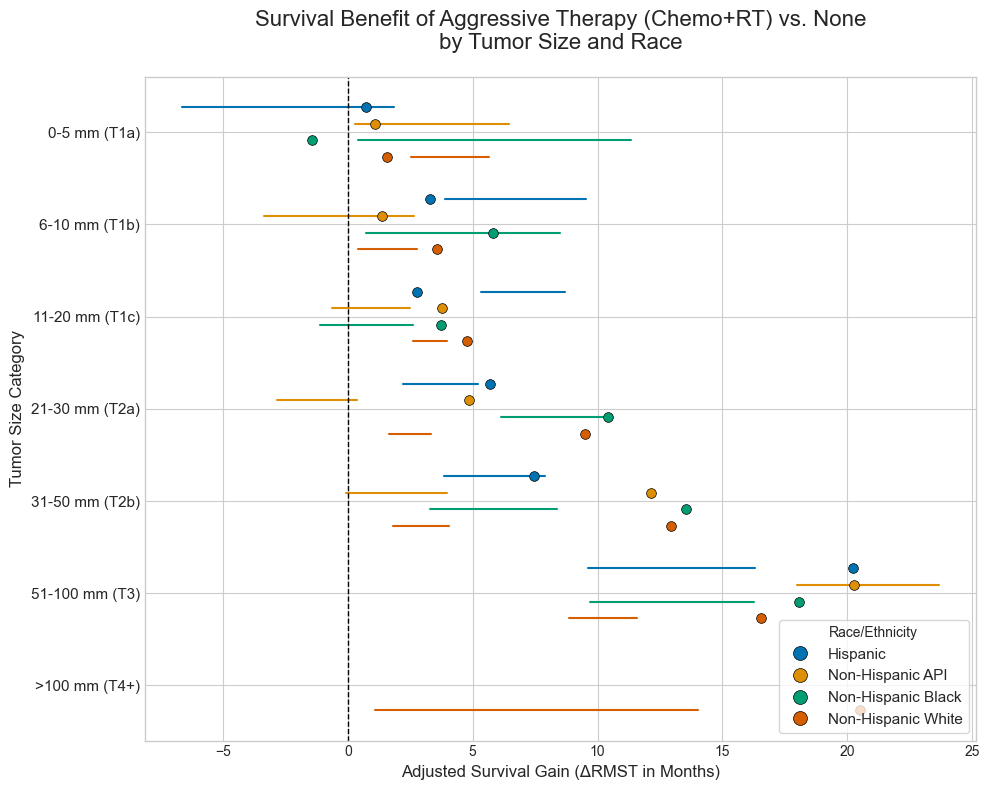

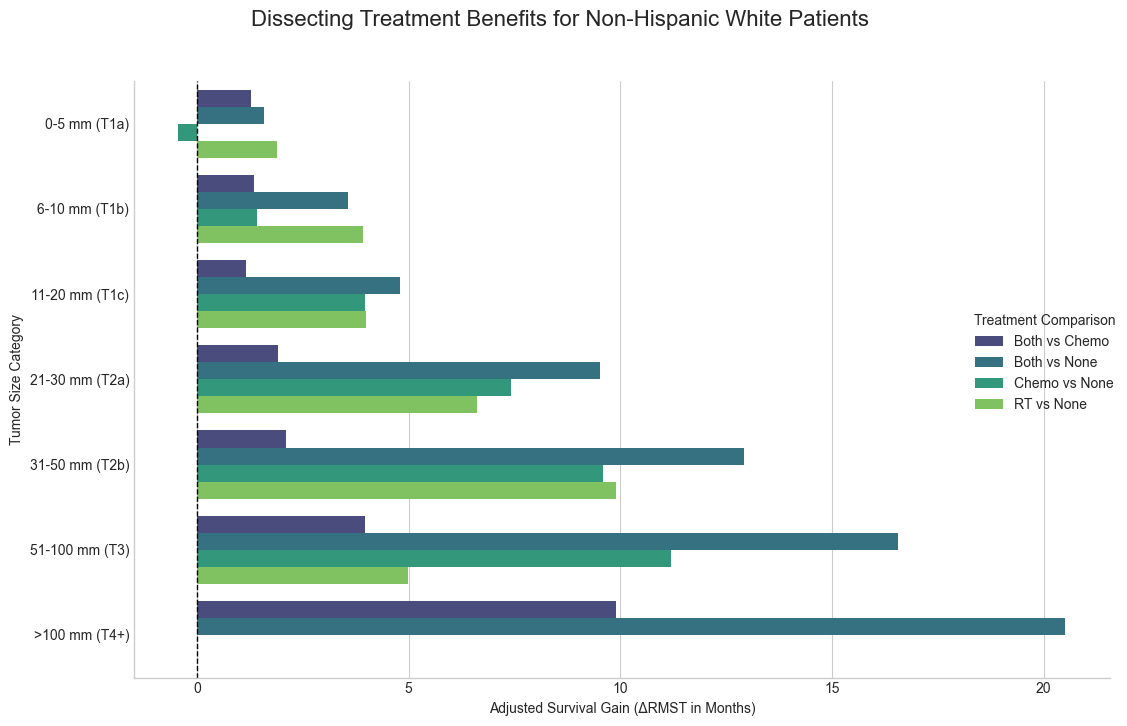

In [ ]:
# Convert Tumor_Size_Granular to an ordered categorical type for correct sorting
size_order = [
    '0-5 mm (T1a)',
    '6-10 mm (T1b)',
    '11-20 mm (T1c)',
    '21-30 mm (T2a)',
    '31-50 mm (T2b)',
    '51-100 mm (T3)',
    '>100 mm (T4+)'
]
dr_table['Tumor_Size_Granular'] = pd.Categorical(
    dr_table['Tumor_Size_Granular'],
    categories=size_order,
    ordered=True
)

# Clean up race names for the legend
race_rename_map = {
    'NHW': 'Non-Hispanic White',
    'NHB': 'Non-Hispanic Black',
    'Hispanic': 'Hispanic',
    'NHAPI': 'Non-Hispanic API'
}
dr_table['Race'] = dr_table['Race'].replace(race_rename_map)


# --- Visualization 1 (Corrected): The Main Finding ---
# This plot visualizes the survival gain from "Both vs None" across tumor sizes for each race.

# Filter the data to focus on the most important comparison
plot_data_v1 = dr_table[dr_table['Contrast'] == 'Both vs None'].sort_values('Tumor_Size_Granular')

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Define colors and the vertical dodge to separate points for different races
races = plot_data_v1['Race'].unique()
colors = sns.color_palette('colorblind', n_colors=len(races))
y_dodge = pd.Series(range(len(races)), index=races) * 0.18
y_dodge -= y_dodge.mean()

# --- CORRECTED PLOTTING LOOP ---
for i, race in enumerate(races):
    race_data = plot_data_v1[plot_data_v1['Race'] == race]
    
    # Define the y-positions for the points on the plot
    y_positions = [size_order.index(s) + y_dodge[race] for s in race_data['Tumor_Size_Granular']]

    # Manually plot the confidence interval lines and the point estimate
    # This avoids the ValueError from ax.errorbar
    
    # 1. Plot the AIPW confidence intervals as simple horizontal lines
    for idx, row in race_data.iterrows():
        y_pos = size_order.index(row['Tumor_Size_Granular']) + y_dodge[race]
        ax.plot(
            [row['ci_lo'], row['ci_hi']], # x-start and x-end of the line
            [y_pos, y_pos],             # y-position of the line
            color=colors[i],
            linewidth=1.5,
            solid_capstyle='round'
        )

    # 2. Plot the IPTW point estimate as a distinct marker on top
    ax.plot(
        race_data['delta_iptw'],
        y_positions,
        'o', # Circle marker
        color=colors[i],
        markersize=7,
        markeredgecolor='black', # Add a black edge for better visibility
        markeredgewidth=0.5
    )

# --- Formatting the Plot ---

# Create custom legend handles so the legend is clear and clean
legend_handles = [Line2D([0], [0], marker='o', color='w', label=race,
                          markerfacecolor=colors[i], markersize=10, 
                          markeredgecolor='black', markeredgewidth=0.5)
                   for i, race in enumerate(races)]

ax.axvline(x=0, color='black', linestyle='--', linewidth=1) # The "no effect" line
ax.set_yticks(range(len(size_order)))
ax.set_yticklabels(size_order, fontsize=11)
ax.invert_yaxis()

ax.set_title('Survival Benefit of Aggressive Therapy (Chemo+RT) vs. None\nby Tumor Size and Race', fontsize=16, pad=20)
ax.set_xlabel('Adjusted Survival Gain (ΔRMST in Months)', fontsize=12)
ax.set_ylabel('Tumor Size Category', fontsize=12)
ax.legend(handles=legend_handles, title='Race/Ethnicity', loc='lower right', frameon=True, fontsize=11)

plt.tight_layout()
plt.savefig('figure_1_therapeutic_zone.png', dpi=300)
plt.show()


# --- Visualization 2: Deep Dive into Treatment Comparisons ---
# This code does not use the problematic function and should work as intended.
race_to_plot = 'Non-Hispanic White'
plot_data_v2 = dr_table[dr_table['Race'] == race_to_plot].copy()

contrasts_to_show = ['Both vs None', 'Chemo vs None', 'RT vs None', 'Both vs Chemo']
plot_data_v2 = plot_data_v2[plot_data_v2['Contrast'].isin(contrasts_to_show)]

g = sns.catplot(
    data=plot_data_v2,
    x='delta_iptw',
    y='Tumor_Size_Granular',
    hue='Contrast',
    kind='bar',
    palette='viridis',
    height=7,
    aspect=1.4,
    legend_out=True
)

g.ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
g.fig.suptitle(f'Dissecting Treatment Benefits for {race_to_plot} Patients', y=1.03, fontsize=16)
g.set_axis_labels('Adjusted Survival Gain (ΔRMST in Months)', 'Tumor Size Category')
g.legend.set_title('Treatment Comparison')

plt.tight_layout()
plt.savefig('figure_2_treatment_comparison_NHW.png', dpi=300)
plt.show()

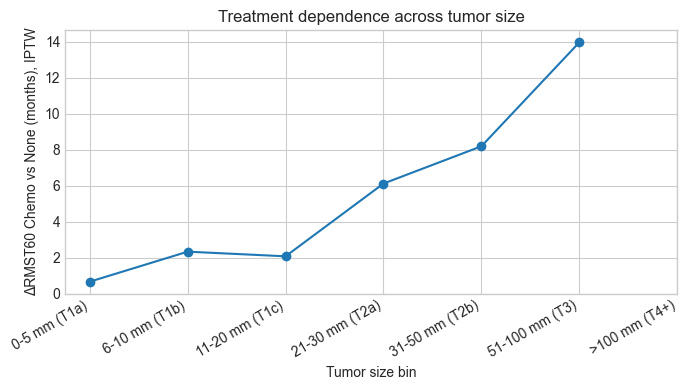

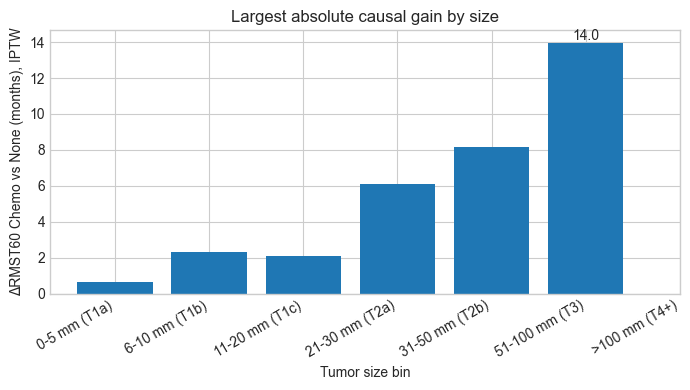

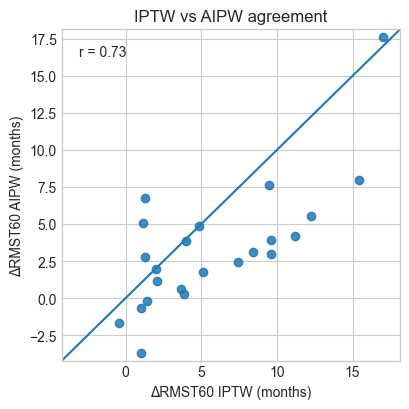

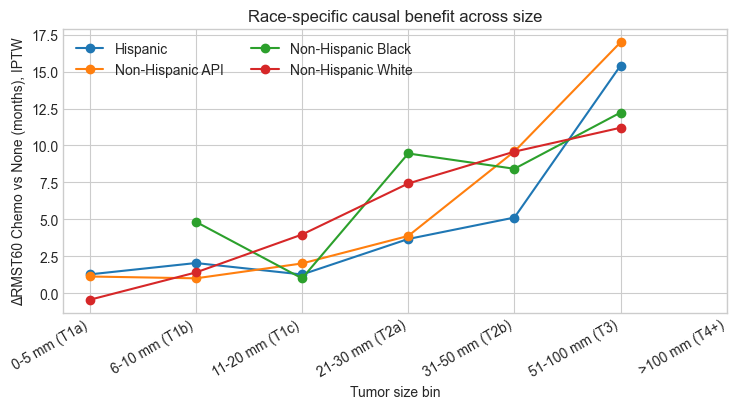

In [46]:

df = dr_table.copy()

df.columns = [c.strip() for c in df.columns]
lower_cols = [c.lower().strip() for c in df.columns]
rename_map = {old:new for old, new in zip(df.columns, lower_cols)}
df = df.rename(columns=rename_map)

def find_col(df, candidates):
    for cand in candidates:
        if cand in df.columns:
            return cand
    for cand in candidates:
        for col in df.columns:
            if cand in col:
                return col
    return None

size_col = find_col(df, ["tumor_size", "tumor_size_bin", "size_bin", "tumor_size_granular", "size", "t_stage", "ajcc_t"])
race_col = find_col(df, ["race", "race_group", "race_cat"])
contrast_col = find_col(df, ["contrast", "comparison", "treatment_contrast", "arm_contrast"])

delta_iptw_col = find_col(df, ["delta_iptw", "dr_rmst60_iptw", "rmst_diff_iptw", "delta_rmst_iptw", "deltarmst_iptw"])
delta_aipw_col = find_col(df, ["delta_aipw", "dr_rmst60_aipw", "rmst_diff_aipw", "delta_rmst_aipw", "deltarmst_aipw"])

arm1_iptw_col = find_col(df, ["rmst60_arm1_iptw", "arm1_rmst_iptw", "rmst_arm1_iptw"])
arm0_iptw_col = find_col(df, ["rmst60_arm0_iptw", "arm0_rmst_iptw", "rmst_arm0_iptw"])

arm1_aipw_col = find_col(df, ["rmst60_arm1_aipw", "arm1_rmst_aipw", "rmst_arm1_aipw"])
arm0_aipw_col = find_col(df, ["rmst60_arm0_aipw", "arm0_rmst_aipw", "rmst_arm0_aipw"])

# Build contrast if missing
if contrast_col is None:
    arm1_label_col = find_col(df, ["arm1_label", "treat1", "arm1", "trt1", "treatment_arm1"])
    arm0_label_col = find_col(df, ["arm0_label", "treat0", "arm0", "trt0", "treatment_arm0"])
    if arm1_label_col and arm0_label_col:
        contrast_col = "__contrast__"
        df[contrast_col] = df[arm1_label_col].astype(str) + " vs " + df[arm0_label_col].astype(str)

# Compute deltas
if delta_iptw_col is None and arm1_iptw_col and arm0_iptw_col:
    delta_iptw_col = "__delta_iptw__"
    df[delta_iptw_col] = df[arm1_iptw_col] - df[arm0_iptw_col]

if delta_aipw_col is None and arm1_aipw_col and arm0_aipw_col:
    delta_aipw_col = "__delta_aipw__"
    df[delta_aipw_col] = df[arm1_aipw_col] - df[arm0_aipw_col]

# Guards
if any(v is None for v in [size_col, race_col, contrast_col, delta_iptw_col]):
    cols = ", ".join(df.columns)
    raise RuntimeError(f"Cannot locate required columns in sheet. Available: {cols}")

# Canonical size labels and order
size_orders = [
    ["0-5 mm", "6-10 mm", "11-20 mm", "21-30 mm", "31-50 mm", "51-100 mm", ">100 mm"],
    ["T1a", "T1b", "T1c", "T2a", "T2b", "T3", "T4"],
]
canonical_map = {
    "0-5 mm": "0-5 mm",
    "6-10 mm": "6-10 mm",
    "11-20 mm": "11-20 mm",
    "21-30 mm": "21-30 mm",
    "31-50 mm": "31-50 mm",
    "51-100 mm": "51-100 mm",
    ">100 mm": ">100 mm",
    "t1a": "0-5 mm",
    "t1b": "6-10 mm",
    "t1c": "11-20 mm",
    "t2a": "21-30 mm",
    "t2b": "31-50 mm",
    "t3": "51-100 mm",
    "t4": ">100 mm",
}
def normalize_size(x):
    s = str(x).strip()
    return canonical_map.get(s, canonical_map.get(s.lower(), s))

df["__size__"] = df[size_col].apply(normalize_size)

observed = df["__size__"].dropna().unique().tolist()
use_order = None
for order in size_orders:
    canon = [canonical_map.get(o, o) for o in order]
    if all(label in observed for label in canon):
        use_order = canon
        break
if use_order is None:
    # try numeric sort by extracting lower bound
    def lower_bound(s):
        m = re.search(r"(\d+)", str(s))
        return int(m.group(1)) if m else 9999
    use_order = sorted(observed, key=lower_bound)

def is_chemo_vs_none(s):
    ls = str(s).lower()
    return ("chemo" in ls or "chemotherapy" in ls) and ("none" in ls or "no" in ls)

df_cvn = df[df[contrast_col].apply(is_chemo_vs_none)].copy()
if df_cvn.empty:
    df_cvn = df[df[contrast_col].str.lower().str.contains("chemo")].copy()

# Group for size-only
grp_size = df_cvn.groupby("__size__")[delta_iptw_col].mean().reindex(use_order)

# Figure 1
plt.figure(figsize=(7,4))
plt.plot(range(len(grp_size.index)), grp_size.values, marker="o")
plt.xticks(range(len(grp_size.index)), grp_size.index, rotation=30, ha="right")
plt.xlabel("Tumor size bin")
plt.ylabel("ΔRMST60 Chemo vs None (months), IPTW")
plt.title("Treatment dependence across tumor size")
# vertical markers between 11-20 and 21-30, and 21-30 and 31-50 if present
def try_vline(label):
    try:
        idx = grp_size.index.get_loc(label)
        plt.axvline(idx + 0.5, linestyle="--")
    except Exception:
        pass
try_vline("11-20 mm")
try_vline("21-30 mm")
plt.tight_layout()
plt.show()

# Figure 2
plt.figure(figsize=(7,4))
plt.bar(range(len(grp_size.index)), grp_size.values)
plt.xticks(range(len(grp_size.index)), grp_size.index, rotation=30, ha="right")
plt.xlabel("Tumor size bin")
plt.ylabel("ΔRMST60 Chemo vs None (months), IPTW")
plt.title("Largest absolute causal gain by size")
max_idx = int(np.nanargmax(grp_size.values))
max_val = float(grp_size.values[max_idx])
plt.text(max_idx, max_val, f"{max_val:.1f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Figure 3: IPTW vs AIPW agreement
pairs = df_cvn[[race_col, "__size__", delta_iptw_col]].rename(columns={delta_iptw_col:"iptw"}).copy()
if delta_aipw_col in df_cvn.columns:
    pairs["aipw"] = df_cvn[delta_aipw_col].values
else:
    if arm1_aipw_col and arm0_aipw_col:
        pairs["aipw"] = (df_cvn[arm1_aipw_col] - df_cvn[arm0_aipw_col]).values

pairs = pairs.dropna(subset=["iptw","aipw"]).copy()

plt.figure(figsize=(4.2,4.2))
plt.scatter(pairs["iptw"], pairs["aipw"], alpha=0.85)
if not pairs.empty:
    lo = float(np.nanmin([pairs["iptw"].min(), pairs["aipw"].min()]))
    hi = float(np.nanmax([pairs["iptw"].max(), pairs["aipw"].max()]))
    pad = 0.5
    plt.plot([lo-pad, hi+pad], [lo-pad, hi+pad])
    plt.xlim(lo-pad, hi+pad)
    plt.ylim(lo-pad, hi+pad)
plt.xlabel("ΔRMST60 IPTW (months)")
plt.ylabel("ΔRMST60 AIPW (months)")
plt.title("IPTW vs AIPW agreement")
if len(pairs) >= 3:
    r = np.corrcoef(pairs["iptw"], pairs["aipw"])[0,1]
    plt.text(0.05, 0.92, f"r = {r:.2f}", transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

# Figure 4: Race curves across size
mat = df_cvn.pivot_table(index="__size__", columns=race_col, values=delta_iptw_col, aggfunc="mean").reindex(use_order)

plt.figure(figsize=(7.5,4.2))
for col in mat.columns:
    plt.plot(range(len(mat.index)), mat[col].values, marker="o", label=str(col))
plt.xticks(range(len(mat.index)), mat.index, rotation=30, ha="right")
plt.xlabel("Tumor size bin")
plt.ylabel("ΔRMST60 Chemo vs None (months), IPTW")
plt.title("Race-specific causal benefit across size")
plt.legend(frameon=False, ncol=2)
plt.tight_layout()

plt.show()


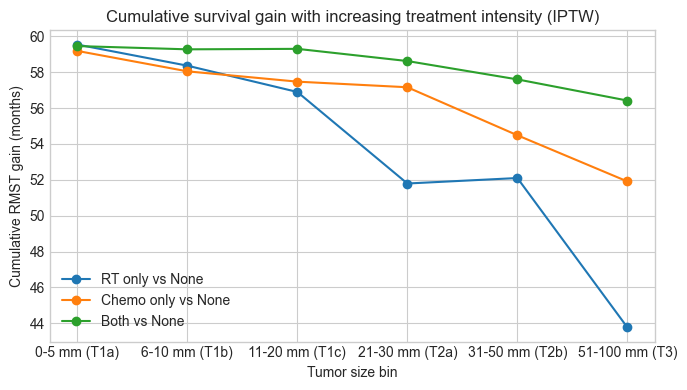

In [63]:
df = dr_table.copy()
size_col = "Tumor_Size_Granular"
arms = ["RT only", "Chemo only", "Both"]

pivot = (
    df.pivot_table(index=size_col, columns="Arm1", values="RMST60_arm1_iptw", aggfunc="mean")
    [arms]
    .dropna()
)

# Plot
plt.figure(figsize=(7,4))
for arm in ["RT only", "Chemo only", "Both"]:
    plt.plot(pivot.index, pivot[arm], marker='o', label=f"{arm} vs None")
plt.xlabel("Tumor size bin")
plt.ylabel("Cumulative RMST gain (months)")
plt.title("Cumulative survival gain with increasing treatment intensity (IPTW)")
plt.legend()
plt.tight_layout()
plt.show()


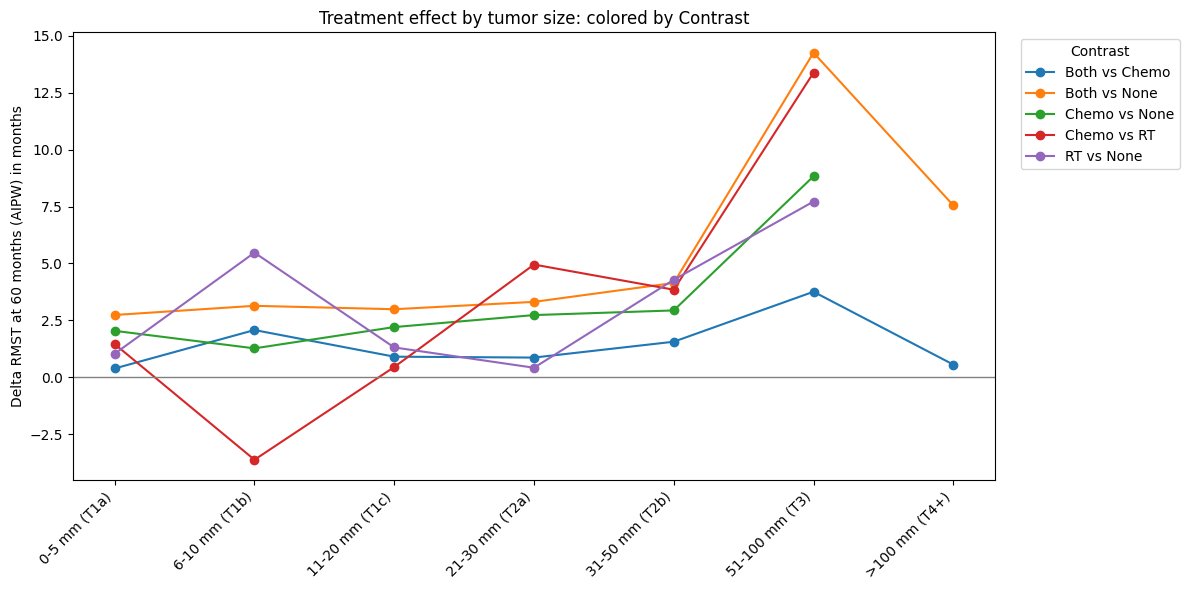

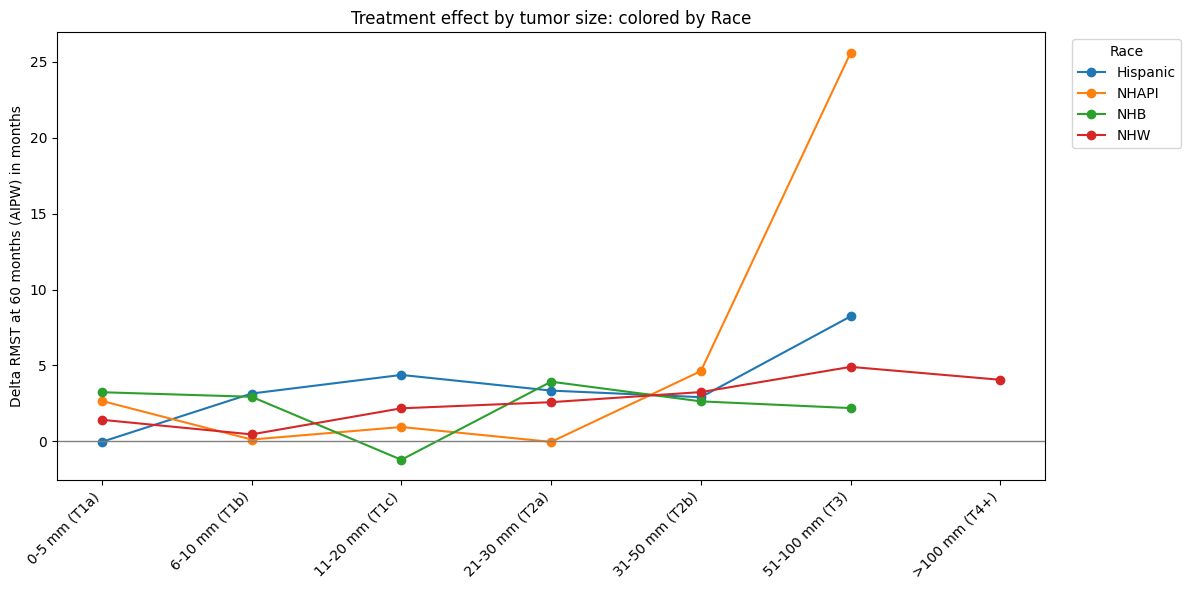

In [47]:

SIZE_ORDER = ['0-5 mm (T1a)', '6-10 mm (T1b)', '11-20 mm (T1c)', '21-30 mm (T2a)',
       '31-50 mm (T2b)', '51-100 mm (T3)','>100 mm (T4+)']

def _order_sizes(series: pd.Series) -> pd.Series:
    uniq = series.dropna().unique().tolist()
    order = [s for s in SIZE_ORDER if s in uniq]
    extras = [s for s in uniq if s not in order]
    order += sorted(extras)
    return pd.Categorical(series, categories=order, ordered=True)

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "Tumor_Size_Granular" in df.columns:
        df["Tumor_Size_Granular"] = _order_sizes(df["Tumor_Size_Granular"])
    # Ensure numeric types for plotting
    numeric_cols = [
        "RMST60_arm1_unaj","RMST60_arm0_unaj","delta_unadj",
        "RMST60_arm1_iptw","RMST60_arm0_iptw","delta_iptw",
        "RMST60_arm1_aipw","RMST60_arm0_aipw","delta_aipw",
        "ci_lo","ci_hi","p","ess_sw","smd_unw","smd_w","pi",
        "w_trunc_low","w_trunc_high","nA","n0","Total N"
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    # Drop rows without the adjusted delta
    if "delta_aipw" in df.columns:
        df = df[~df["delta_aipw"].isna()]
    return df

# -------- A. delta_aipw by size (facets by contrast or race) --------

def plot_delta_by_size(
    df: pd.DataFrame,
    contrasts: Optional[List[str]] = None,
    races: Optional[List[str]] = None,
    color_by: str = "Contrast"  # or "Race"
):
    data = df.copy()
    if contrasts:
        data = data[data["Contrast"].isin(contrasts)]
    if races:
        data = data[data["Race"].isin(races)]
    key = "delta_aipw"
    if key not in data.columns:
        raise ValueError("delta_aipw not found")

    groups = sorted(data[color_by].dropna().unique())
    sizes = [c for c in data["Tumor_Size_Granular"].cat.categories if c in data["Tumor_Size_Granular"].unique()]

    plt.figure(figsize=(12, 6))
    for g in groups:
        sub = data[data[color_by] == g]
        # average across duplicates if any
        y = sub.groupby("Tumor_Size_Granular")[key].mean().reindex(sizes)
        plt.plot(range(len(sizes)), y.values, marker="o", label=str(g))

    plt.xticks(range(len(sizes)), sizes, rotation=45, ha="right")
    plt.axhline(0, color="gray", linewidth=1)
    plt.ylabel("Delta RMST at 60 months (AIPW) in months")
    plt.title(f"Treatment effect by tumor size: colored by {color_by}")
    plt.legend(title=color_by, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# -------- B. unadjusted vs IPTW vs AIPW for a given contrast and race --------

def plot_method_comparison(df: pd.DataFrame, contrast: str, race: str):
    data = df[(df["Contrast"] == contrast) & (df["Race"] == race)].copy()
    if data.empty:
        raise ValueError("No rows for that contrast and race")

    sizes = [c for c in data["Tumor_Size_Granular"].cat.categories if c in data["Tumor_Size_Granular"].unique()]
    data = data.set_index("Tumor_Size_Granular").reindex(sizes)

    methods = [("delta_unadj","Unadjusted"), ("delta_iptw","IPTW"), ("delta_aipw","AIPW")]
    x = np.arange(len(sizes))
    width = 0.25

    plt.figure(figsize=(12,6))
    for i,(col,label) in enumerate(methods):
        if col in data.columns:
            plt.bar(x + i*width - width, data[col].values, width=width, label=label)

    plt.xticks(x, sizes, rotation=45, ha="right")
    plt.axhline(0, color="gray", linewidth=1)
    plt.ylabel("Delta RMST at 60 months in months")
    plt.title(f"{contrast} effect by size for {race}: method comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_race_curves(df: pd.DataFrame, contrast: str, races: Optional[List[str]] = None):
    data = df[df["Contrast"] == contrast].copy()
    if races:
        data = data[data["Race"].isin(races)]

    sizes = [c for c in data["Tumor_Size_Granular"].cat.categories if c in data["Tumor_Size_Granular"].unique()]
    plt.figure(figsize=(12,6))
    for race in sorted(data["Race"].dropna().unique()):
        sub = data[data["Race"] == race]
        y = sub.groupby("Tumor_Size_Granular")["delta_aipw"].mean().reindex(sizes)
        plt.plot(range(len(sizes)), y.values, marker="o", label=race)

    plt.xticks(range(len(sizes)), sizes, rotation=45, ha="right")
    plt.axhline(0, color="gray", linewidth=1)
    plt.ylabel("Delta RMST at 60 months (AIPW) in months")
    plt.title(f"Race specific treatment effect curves: {contrast}")
    plt.legend(title="Race", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_volcano(df: pd.DataFrame, contrast: str):
    data = df[df["Contrast"] == contrast].copy()
    if data.empty:
        raise ValueError("No rows for that contrast")
    data["neglog10p"] = -np.log10(data["p"].clip(lower=1e-12))
    sizes = data["Tumor_Size_Granular"].astype(str)

    plt.figure(figsize=(10,6))
    sc = plt.scatter(data["delta_aipw"], data["neglog10p"],
                     c=pd.Categorical(data["Race"]).codes, s=60, alpha=0.8)
    plt.axvline(0, color="gray", linewidth=1)
    plt.xlabel("Delta RMST at 60 months (AIPW) in months")
    plt.ylabel("-log10(p)")
    plt.title(f"Volcano style view: {contrast}")
    # Optional: label extreme points
    top = data.sort_values("neglog10p", ascending=False).head(6)
    for _, r in top.iterrows():
        plt.text(r["delta_aipw"], r["neglog10p"], f"{r['Race']}, {r['Tumor_Size_Granular']}", fontsize=8)

    # legend for races
    races = sorted(data["Race"].dropna().unique())
    handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor='C'+str(i), markersize=8)
               for i in range(len(races))]
    plt.legend(handles, races, title="Race", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()

# -------- E. forest plot for a chosen contrast and race --------

def plot_forest(df: pd.DataFrame, contrast: str, race: str):
    data = df[(df["Contrast"] == contrast) & (df["Race"] == race)].copy()
    if data.empty:
        raise ValueError("No rows for that contrast and race")

    # Sort by size
    data = data.sort_values("Tumor_Size_Granular")
    y_labels = data["Tumor_Size_Granular"].astype(str).tolist()
    y_pos = np.arange(len(y_labels))

    effects = data["delta_aipw"].values
    lo = data["ci_lo"].values
    hi = data["ci_hi"].values

    plt.figure(figsize=(8, 0.6*len(y_labels)+2))
    plt.hlines(y=y_pos, xmin=lo, xmax=hi, color="black")
    plt.plot(effects, y_pos, "o")
    plt.axvline(0, color="gray", linewidth=1)
    plt.yticks(y_pos, y_labels)
    plt.xlabel("Delta RMST at 60 months (AIPW) in months")
    plt.title(f"Forest plot: {contrast} in {race}")
    plt.tight_layout()
    plt.show()


def plot_diagnostics(df: pd.DataFrame):
    data = df.copy()
    fig, axes = plt.subplots(1, 3, figsize=(15,4))

    # ESS by contrast
    if "ess_sw" in data.columns:
        ess = data.groupby("Contrast")["ess_sw"].median().sort_values()
        axes[0].barh(ess.index, ess.values)
        axes[0].set_title("Median ESS by contrast")
        axes[0].set_xlabel("ESS")

    # Balance improvement
    if "smd_unw" in data.columns and "smd_w" in data.columns:
        axes[1].scatter(data["smd_unw"], data["smd_w"], alpha=0.6)
        axes[1].plot([0, data[["smd_unw","smd_w"]].max().max()],
                     [0, data[["smd_unw","smd_w"]].max().max()],
                     color="gray", linewidth=1)
        axes[1].set_title("Balance: SMD weighted vs unweighted")
        axes[1].set_xlabel("SMD unweighted")
        axes[1].set_ylabel("SMD weighted")

    # Weight truncation
    if "w_trunc_low" in data.columns and "w_trunc_high" in data.columns:
        axes[2].scatter(data["w_trunc_low"], data["w_trunc_high"], alpha=0.6)
        axes[2].set_title("Weight truncation thresholds")
        axes[2].set_xlabel("Low")
        axes[2].set_ylabel("High")

    plt.tight_layout()
    plt.show()

# -------- example usage --------
# 1) Load df. Replace with your actual load step.
df = dr_table.copy()

# 2) Preprocess
df = preprocess(df)

# 3) Plots
# A: effect by size colored by contrast
plot_delta_by_size(df, color_by="Contrast")
# A alt: effect by size colored by race
plot_delta_by_size(df, color_by="Race")




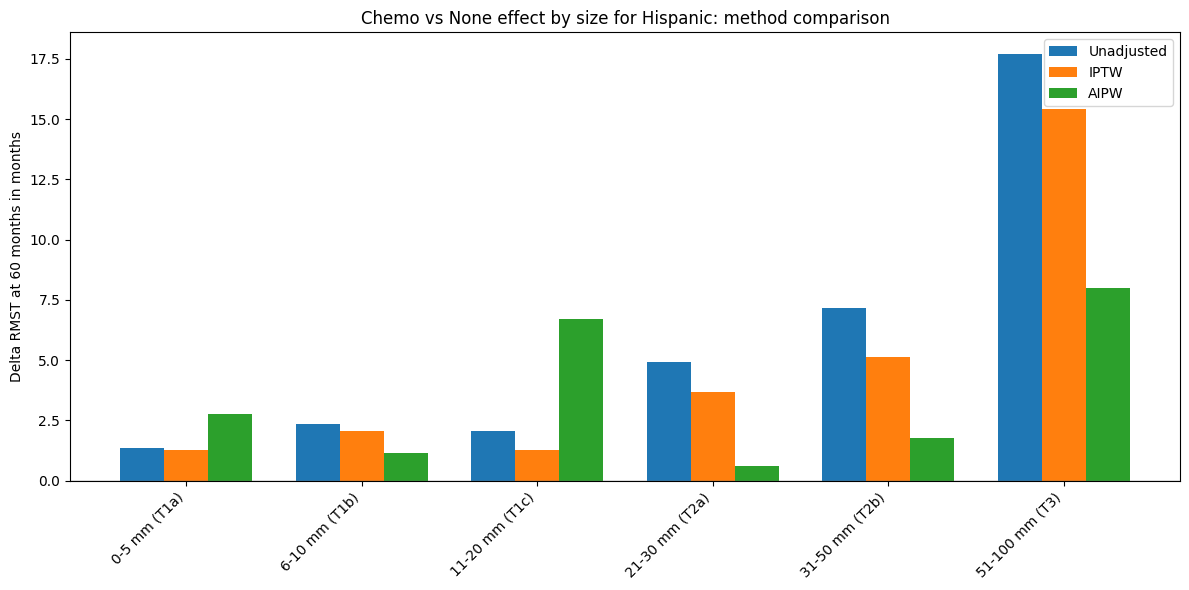

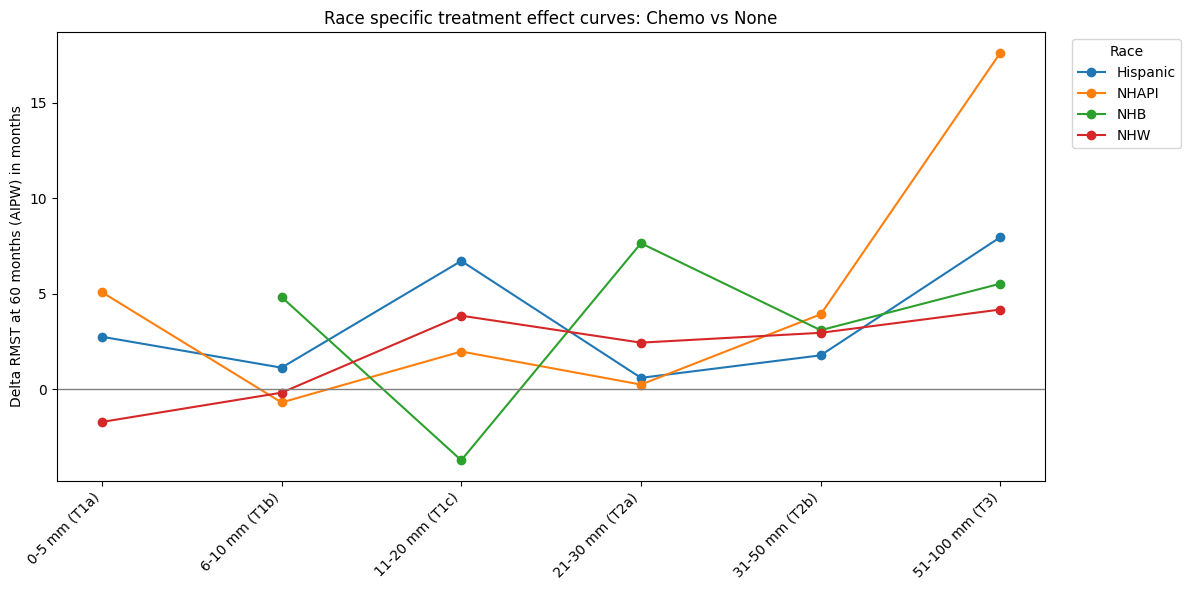

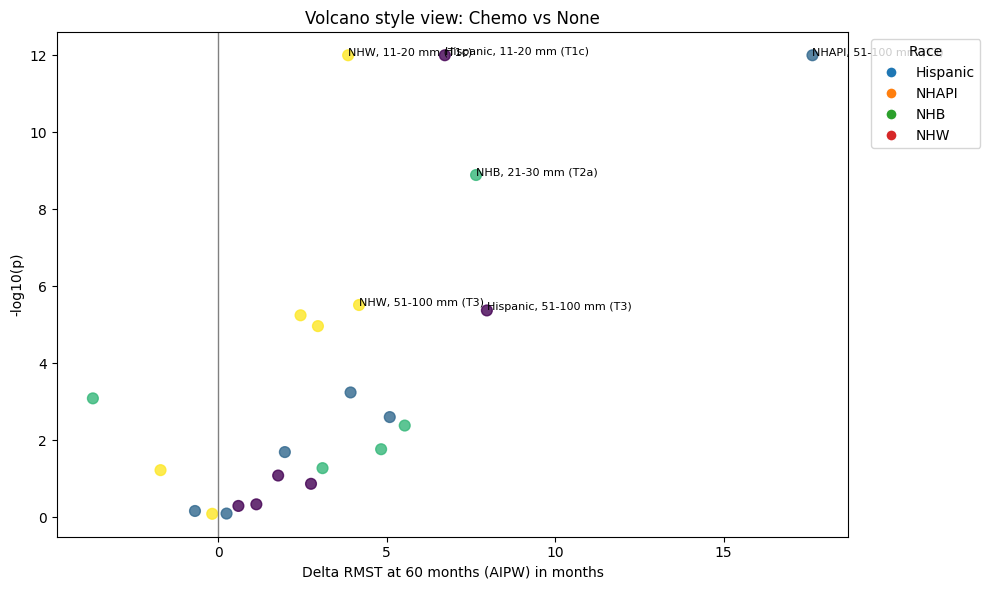

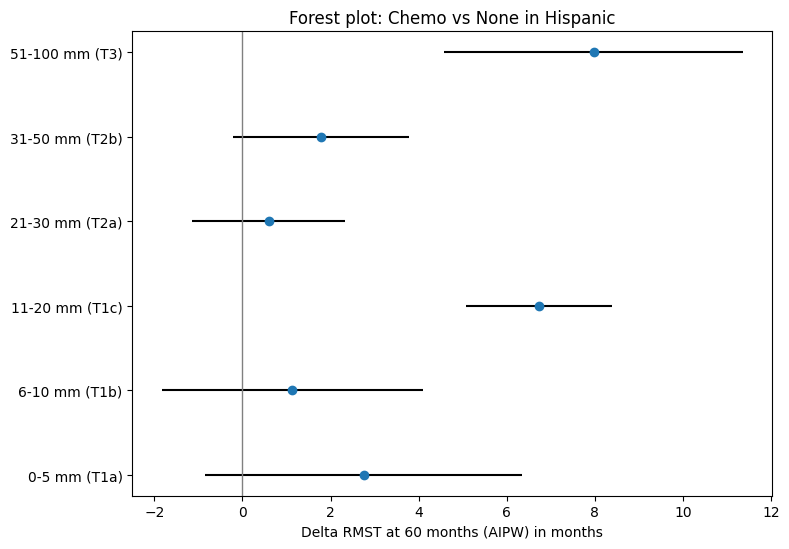

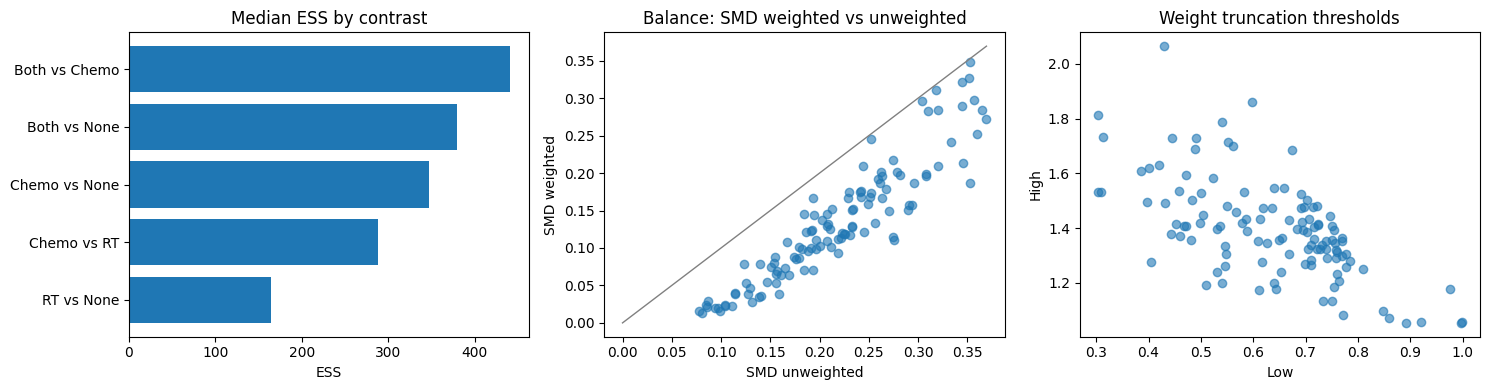

In [48]:
# B: unadjusted vs IPTW vs AIPW for a specific contrast and race
plot_method_comparison(df, contrast="Chemo vs None", race="Hispanic")

# C: race specific curves for a chosen contrast
plot_race_curves(df, contrast="Chemo vs None")

# D: volcano for a contrast
plot_volcano(df, contrast="Chemo vs None")

# E: forest plot for a contrast and race
plot_forest(df, contrast="Chemo vs None", race="Hispanic")

# F: diagnostics
plot_diagnostics(df)

,race,contrast,suggested_cutoff,direction,rule_used,strongest_bin,strongest_delta,strongest_p
0,Hispanic,Both vs Chemo,31-50 mm (T2b),benefit,Max slope fallback,31-50 mm (T2b),1.716999,2.427969e-02
1,Hispanic,Both vs None,6-10 mm (T1b),benefit,Two consecutive significant positive bins,51-100 mm (T3),20.236422,2.631229e-14
2,Hispanic,Chemo vs None,51-100 mm (T3),benefit,First significant bin over MCID,51-100 mm (T3),15.405064,4.211957e-06
3,Hispanic,Chemo vs RT,21-30 mm (T2a),benefit,First significant bin over MCID,51-100 mm (T3),14.723996,9.562228e-04
4,Hispanic,RT vs None,6-10 mm (T1b),benefit,First significant bin over MCID,31-50 mm (T2b),7.311601,2.040141e-05
5,NHAPI,Both vs Chemo,31-50 mm (T2b),benefit,Max slope fallback,None,NaN,NaN
6,NHAPI,Both vs None,51-100 mm (T3),benefit,First significant bin over MCID,51-100 mm (T3),20.257366,0.000000e+00
7,NHAPI,Chemo vs None,31-50 mm (T2b),benefit,Two consecutive significant positive bins,51-100 mm (T3),16.979871,0.000000e+00
8,NHAPI,Chemo vs RT,21-30 mm (T2a),benefit,First significant bin over MCID,51-100 mm (T3),14.473198,0.000000e+00
9,NHAPI,RT vs None,11-20 mm (T1c),benefit,First significant bin over MCID,31-50 mm (T2b),10.437276,5.360354e-10


,Race,Tumor_Size_Granular,Top_Treatment_IPTW,Ranking_IPTW,Scores
0,Hispanic,0-5 mm (T1a),Chemo only,Chemo only > Both > RT only > None,"{'None': -2.378923396404815, 'RT only': -0.46725216135698133, 'Chemo only': 2.4265381340204115, 'Both': 0.4196374237413849}"
2,Hispanic,11-20 mm (T1c),Both,Both > Chemo only > RT only > None,"{'None': -5.235062601107572, 'RT only': 0.5725872501746991, 'Chemo only': 0.6206816441743115, 'Both': 4.041793706758561}"
3,Hispanic,21-30 mm (T2a),Chemo only,Chemo only > Both > None > RT only,"{'None': -7.275117234808185, 'RT only': -8.9415998236626, 'Chemo only': 9.354010789796412, 'Both': 6.862706268674373}"
4,Hispanic,31-50 mm (T2b),Both,Both > RT only > Chemo only > None,"{'None': -19.894138713741498, 'RT only': 7.302830631530192, 'Chemo only': 3.4156989087706293, 'Both': 9.175609173440677}"
5,Hispanic,51-100 mm (T3),Chemo only,Chemo only > Both > RT only > None,"{'None': -35.64148569163907, 'RT only': -14.72399627936926, 'Chemo only': 26.019461201839654, 'Both': 24.346020769168675}"
1,Hispanic,6-10 mm (T1b),Both,Both > RT only > Chemo only > None,"{'None': -8.35020720882875, 'RT only': 3.980164162986796, 'Chemo only': -0.09683068613487222, 'Both': 4.4668737319768255}"
6,NHAPI,0-5 mm (T1a),Chemo only,Chemo only > Both > RT only > None,"{'None': -2.8613088977911474, 'RT only': 0.13011822287862174, 'Chemo only': 1.6335429213054198, 'Both': 1.0976477536071059}"
8,NHAPI,11-20 mm (T1c),RT only,RT only > Both > Chemo only > None,"{'None': -10.62438999166973, 'RT only': 6.794105324402032, 'Chemo only': -1.3583662579012667, 'Both': 5.1886509251689645}"
9,NHAPI,21-30 mm (T2a),Chemo only,Chemo only > Both > RT only > None,"{'None': -9.280237853850508, 'RT only': -3.9411759448107517, 'Chemo only': 8.05997033943558, 'Both': 5.16144345922568}"
10,NHAPI,31-50 mm (T2b),Both,Both > RT only > Chemo only > None,"{'None': -32.16965506107406, 'RT only': 9.342561353233506, 'Chemo only': 9.098482211343068, 'Both': 13.728611496497486}"


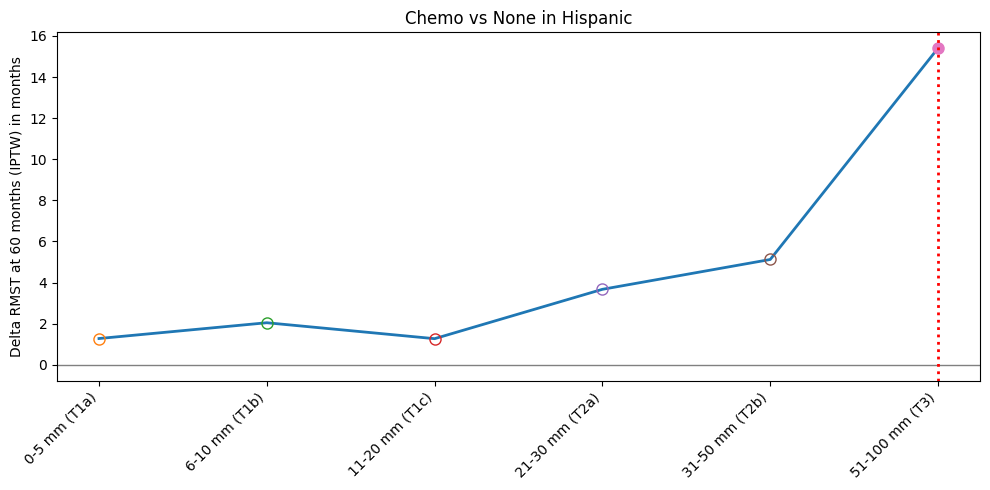

In [ ]:

MCID = 2.0
ALPHA = 0.05

def prep(df):
    df = df.copy()
    df["Tumor_Size_Granular"] = _order_sizes(df["Tumor_Size_Granular"])
    for c in ["delta_iptw","p","ci_lo","ci_hi","RMST60_arm1_iptw","RMST60_arm0_iptw","ess_sw","smd_w"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def find_cutoff_per_group(g):
   
    g = g.sort_values("Tumor_Size_Granular")
    sizes = g["Tumor_Size_Granular"].astype(str).tolist()
    d = g["delta_iptw"].values
    p = g["p"].values

    sig_pos = (p < ALPHA) & (d >= MCID)
    sig_neg = (p < ALPHA) & (d <= -MCID)

    cutoff = None
    direction = None
    rule_used = None

    # Rule A. two consecutive significant bins in the same direction
    for i in range(len(d) - 1):
        if sig_pos[i] and sig_pos[i+1]:
            cutoff = sizes[i]
            direction = "benefit"
            rule_used = "Two consecutive significant positive bins"
            break
        if sig_neg[i] and sig_neg[i+1]:
            cutoff = sizes[i]
            direction = "harm"
            rule_used = "Two consecutive significant negative bins"
            break

    # Rule B. first bin that is significant and exceeds MCID if Rule A fails
    if cutoff is None:
        for i in range(len(d)):
            if (p[i] < ALPHA) and (abs(d[i]) >= MCID):
                cutoff = sizes[i]
                direction = "benefit" if d[i] > 0 else "harm"
                rule_used = "First significant bin over MCID"
                break

    # Rule C. max slope fallback if still nothing
    if cutoff is None and len(d) >= 2:
        slope = np.diff(d)
        j = int(np.nanargmax(np.abs(slope)))
        cutoff = sizes[j]  # index where change begins
        direction = "benefit" if d[j+1] > d[j] else "harm"
        rule_used = "Max slope fallback"

    if cutoff is None:
        return dict(suggested_cutoff=np.nan, direction=None, rule_used="No signal", strongest_bin=None,
                    strongest_delta=np.nan, strongest_p=np.nan)

    mask_sig = (p < ALPHA) & (~np.isnan(d))
    strongest_bin = None
    strongest_delta = np.nan
    strongest_p = np.nan
    if mask_sig.any():
        idx = np.nanargmax(np.abs(d * mask_sig))
        strongest_bin = sizes[idx]
        strongest_delta = d[idx]
        strongest_p = p[idx]

    return dict(
        suggested_cutoff=cutoff,
        direction=direction,
        rule_used=rule_used,
        strongest_bin=strongest_bin,
        strongest_delta=strongest_delta,
        strongest_p=strongest_p
    )

def compute_cutoffs(df):

    out = []
    for (race, contrast), g in df.groupby(["Race","Contrast"]):
        res = find_cutoff_per_group(g)
        res.update(race=race, contrast=contrast)
        out.append(res)
    cut = pd.DataFrame(out)
    cols = ["race","contrast","suggested_cutoff","direction","rule_used","strongest_bin","strongest_delta","strongest_p"]
    return cut[cols]

def rank_treatments_for_cell(cell_df):
    arms = ["None","RT only","Chemo only","Both"]
    score = {a: 0.0 for a in arms}
    seen = set()
    for _, r in cell_df.iterrows():
        a1, a0 = r["Arm1"], r["Arm0"]
        if pd.isna(r["RMST60_arm1_iptw"]) or pd.isna(r["RMST60_arm0_iptw"]):
            continue
        diff = r["RMST60_arm1_iptw"] - r["RMST60_arm0_iptw"]
        score[a1] = score.get(a1, 0.0) + diff
        score[a0] = score.get(a0, 0.0) - diff
        seen.add(a1); seen.add(a0)
    observed = [a for a in arms if a in seen]
    ranking = sorted(observed, key=lambda a: score.get(a, 0.0), reverse=True)
    return ranking, score

def build_treatment_rankings(df):
 
    rows = []
    for (race, size), g in df.groupby(["Race","Tumor_Size_Granular"]):
        ranking, score = rank_treatments_for_cell(g)
        top = ranking[0] if ranking else None
        rows.append({
            "Race": race,
            "Tumor_Size_Granular": str(size),
            "Top_Treatment_IPTW": top,
            "Ranking_IPTW": " > ".join(ranking),
            "Scores": score
        })
    return pd.DataFrame(rows).sort_values(["Race","Tumor_Size_Granular"])

def plot_effect_with_cutoff(df, race, contrast, title=None):

    g = df[(df["Race"] == race) & (df["Contrast"] == contrast)].copy()
    if g.empty:
        print("No rows for this Race and Contrast")
        return
    g = g.sort_values("Tumor_Size_Granular")
    sizes = g["Tumor_Size_Granular"].astype(str).tolist()
    d = g["delta_iptw"].values
    p = g["p"].values

    co = find_cutoff_per_group(g)
    cutoff = co["suggested_cutoff"]

    plt.figure(figsize=(10,5))
    x = np.arange(len(sizes))
    sig = (p < ALPHA) & (np.abs(d) >= MCID)

    # line
    plt.plot(x, d, linewidth=2)
    # markers
    for i in range(len(d)):
        if sig[i]:
            plt.plot(x[i], d[i], marker="o", markersize=8)
        else:
            plt.plot(x[i], d[i], marker="o", markersize=8, fillstyle="none")

    # baseline and cutoff
    plt.axhline(0, color="gray", linewidth=1)
    if isinstance(cutoff, str) and cutoff in sizes:
        xi = sizes.index(cutoff)
        plt.axvline(xi, color="red", linestyle=":", linewidth=2)

    plt.xticks(x, sizes, rotation=45, ha="right")
    plt.ylabel("Delta RMST at 60 months (IPTW) in months")
    title = title or f"{contrast} in {race}"
    plt.title(title)
    plt.tight_layout()
    plt.show()



cutoffs = compute_cutoffs(df)
display(cutoffs)


ranks = build_treatment_rankings(df)
display(ranks)

plot_effect_with_cutoff(df, race="Hispanic", contrast="Chemo vs None")


In [85]:
df.columns

Index(['tumor_size_granular', 'race', 'contrast', 'arm1', 'arm0', 'na', 'n0', 'total n', 'rmst60_arm1_unaj', 'rmst60_arm0_unaj', 'delta_unadj', 'rmst60_arm1_iptw', 'rmst60_arm0_iptw', 'delta_iptw', 'rmst60_arm1_aipw', 'rmst60_arm0_aipw', 'delta_aipw', 'ci_lo', 'ci_hi', 'p', 'ess_sw', 'smd_unw', 'smd_w', 'pi', 'w_trunc_low', 'w_trunc_high', '__size__', '__race__', '__contrast__'], dtype='object')

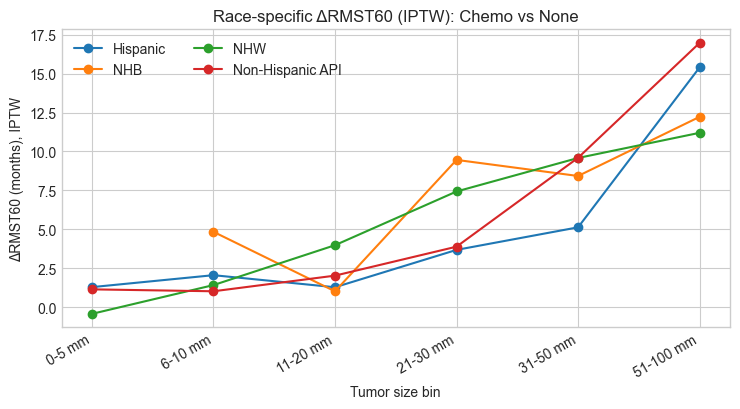

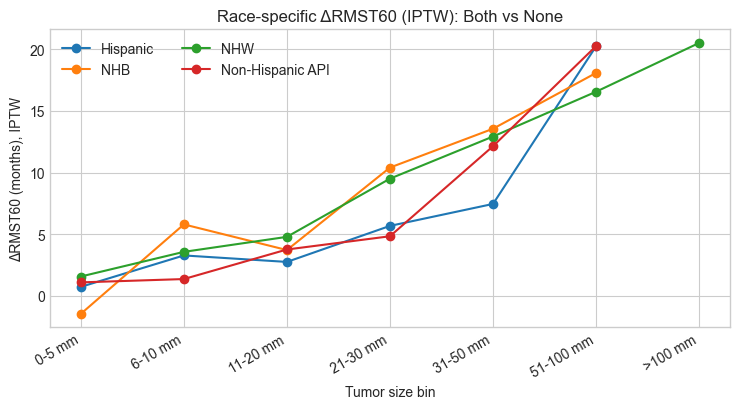

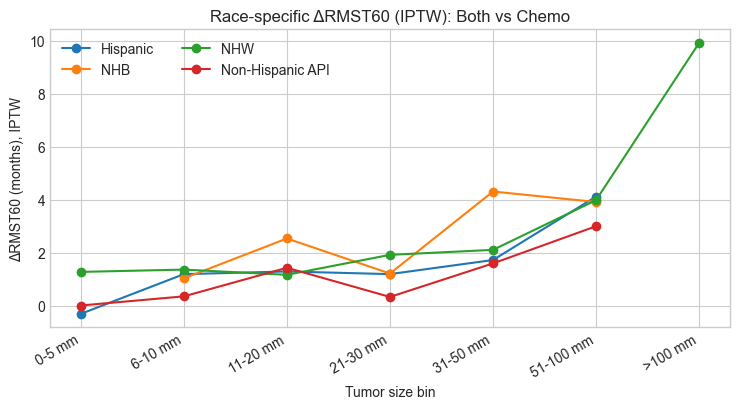

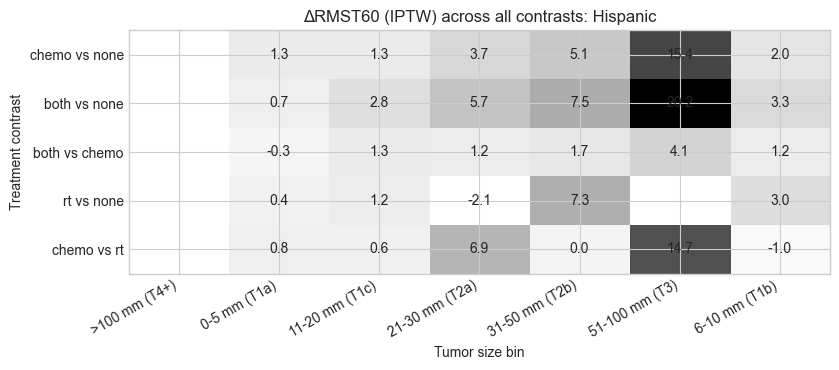

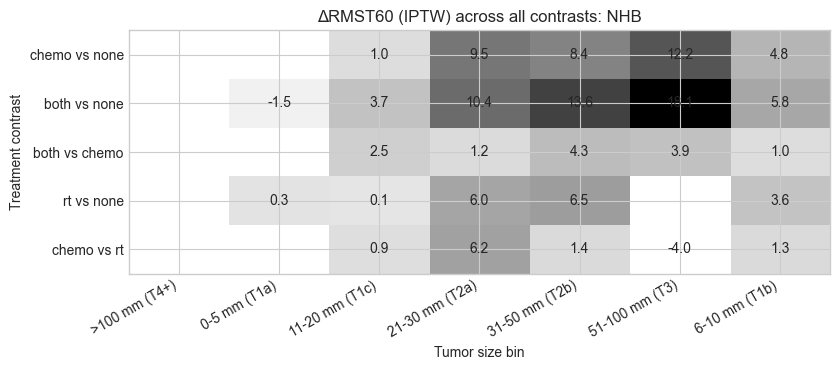

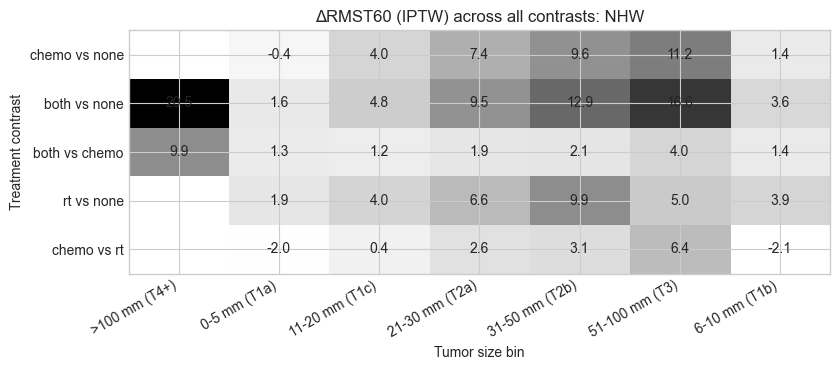

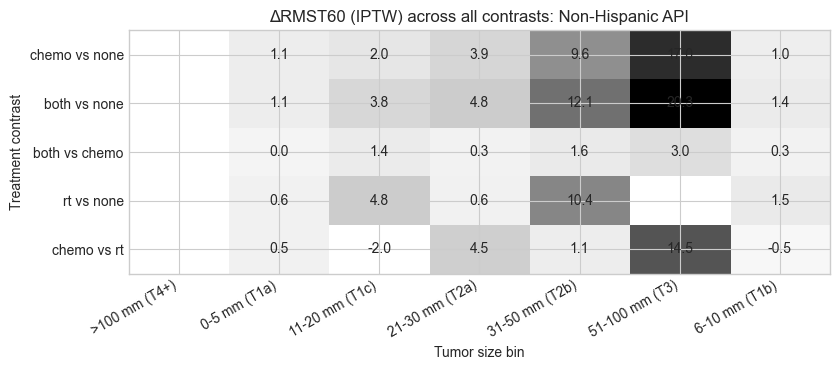

In [90]:

# Normalize columns
df.columns = [c.strip() for c in df.columns]
df.columns = [c.lower() for c in df.columns]

def find_col(cands):
    for c in cands:
        if c in df.columns:
            return c
    for c in cands:
        for col in df.columns:
            if c in col:
                return col
    return None

size_col      = find_col(["tumor_size_bin","tumor_size","size_bin","tumor_size_granular","t_stage","ajcc_t"])
race_col      = find_col(["race","race_group","race_cat"])
contrast_col  = find_col(["contrast","comparison","treatment_contrast","arm_contrast"])
delta_col     = find_col(["dr_rmst60_iptw","delta_iptw","delta_rmst_iptw","rmst_diff_iptw"])
arm1_col      = find_col(["rmst60_arm1_iptw","arm1_rmst_iptw","rmst_arm1_iptw"])
arm0_col      = find_col(["rmst60_arm0_iptw","arm0_rmst_iptw","rmst_arm0_iptw"])

# If contrast missing, try to build from arm labels
if contrast_col is None:
    a1 = find_col(["arm1_label","arm1","treat1","trt1","treatment_arm1"])
    a0 = find_col(["arm0_label","arm0","treat0","trt0","treatment_arm0"])
    if a1 and a0:
        contrast_col = "__contrast__"
        df[contrast_col] = df[a1].astype(str) + " vs " + df[a0].astype(str)

# If delta is missing, compute from arm RMST
if delta_col is None and arm1_col and arm0_col:
    delta_col = "__delta_iptw__"
    df[delta_col] = df[arm1_col] - df[arm0_col]

order_map = {
    "0-5 mm": 0, "6-10 mm": 1, "11-20 mm": 2, "21-30 mm": 3, "31-50 mm": 4, "51-100 mm": 5, ">100 mm": 6,
    "t1a": 0, "t1b": 1, "t1c": 2, "t2a": 3, "t2b": 4, "t3": 5, "t4": 6, "t4+": 6, ">100 mm (t4+)": 6
}
def size_key(s):
    return order_map.get(str(s).strip().lower(), 999)

# Canonical race short labels
race_map = {
    "non-hispanic white": "NHW",
    "white": "NHW",
    "non-hispanic black": "NHB",
    "black": "NHB",
    "hispanic": "Hispanic",
    "non-hispanic asian or pacific islander": "NHAPI",
    "non-hispanic asian/pacific islander": "NHAPI",
    "asian or pacific islander": "NHAPI",
    "american indian/alaska native": "NHAIAN",
    "non-hispanic american indian/alaska native": "NHAIAN",
}
def norm_race(x):
    s = str(x).strip().lower()
    return race_map.get(s, str(x).strip())

# Canonical contrasts
def norm_contrast(s):
    s = str(s).strip().lower()
    s = s.replace("radiotherapy","rt").replace("radiation","rt")
    s = s.replace("chemotherapy","chemo")
    s = s.replace("no treatment","none").replace("no rx","none")
    return s

df["__size__"]     = df[size_col].astype(str).str.strip()
df["__race__"]     = df[race_col].apply(norm_race)
df["__contrast__"] = df[contrast_col].apply(norm_contrast)

# Keep only contrasts we plan to show
keep_contrasts = ["chemo vs none","both vs none","both vs chemo","rt vs none","chemo vs rt"]
df = df[df["__contrast__"].isin(keep_contrasts)].copy()

# ---------------- Helper plotting funcs ----------------
out_dir = Path("/mnt/data"); out_dir.mkdir(exist_ok=True, parents=True)

import re

def clean_size_label(s):
    """Normalize tumor size labels like '31-50 mm (T2b)' → '31-50 mm'."""
    s = str(s).strip()
    s = re.sub(r"\s*\(.*?\)", "", s)  # remove anything in parentheses
    return s

def line_plot_by_race(contrast, filename, title):
    sub = df[df["__contrast__"] == contrast].copy()

    # Clean size labels for proper ordering
    sub["__size_clean__"] = sub["__size__"].apply(clean_size_label)
    mat = sub.pivot_table(index="__size_clean__", columns="__race__", values=delta_col, aggfunc="mean")

    # Reorder using order_map keys (after cleaning)
    ordered_sizes = sorted(mat.index, key=lambda s: order_map.get(s.lower().strip(), 999))
    mat = mat.reindex(ordered_sizes)

    # Plot
    plt.figure(figsize=(7.5, 4.2))
    for col in mat.columns:
        plt.plot(range(len(mat.index)), mat[col].values, marker="o", label=str(col))
    plt.xticks(range(len(mat.index)), mat.index, rotation=30, ha="right")
    plt.xlabel("Tumor size bin")
    plt.ylabel("ΔRMST60 (months), IPTW")
    plt.title(title)
    plt.legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.show()


def per_race_heatmaps(filename_prefix, title_prefix):
    # Build a 3D cube: race × contrast × size -> mean Δ
    races = sorted(df["__race__"].dropna().unique())
    sizes = sorted(df["__size__"].dropna().unique(), key=size_key)
    contrasts = keep_contrasts  # fixed order
    saved = []
    for r in races:
        sub = df[df["__race__"]==r].copy()
        mat = sub.pivot_table(index="__contrast__", columns="__size__", values=delta_col, aggfunc="mean").reindex(contrasts)
        # Ensure columns ordered by size
        mat = mat.reindex(columns=sizes)
        # Plot heatmap for this race
        plt.figure(figsize=(8.5,3.8))
        data = mat.values.astype(float)
        plt.imshow(data, aspect="auto")
        plt.xticks(range(len(mat.columns)), mat.columns, rotation=30, ha="right")
        plt.yticks(range(len(mat.index)), mat.index)
        plt.xlabel("Tumor size bin")
        plt.ylabel("Treatment contrast")
        plt.title(f"{title_prefix}: {r}")
        # Add cell labels for easy reading
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                val = data[i, j]
                if not np.isnan(val):
                    plt.text(j, i, f"{val:.1f}", ha="center", va="center")
        plt.tight_layout()
        plt.show()
    

# ---------------- Generate figures ----------------
line_plot_by_race("chemo vs none", "fig_race_size_line_chemo_vs_none.png",
                       "Race-specific ΔRMST60 (IPTW): Chemo vs None")

line_plot_by_race("both vs none", "fig_race_size_line_both_vs_none.png",
                       "Race-specific ΔRMST60 (IPTW): Both vs None")

line_plot_by_race("both vs chemo", "fig_race_size_line_both_vs_chemo.png",
                       "Race-specific ΔRMST60 (IPTW): Both vs Chemo")

per_race_heatmaps("fig_race_size_heatmap", "ΔRMST60 (IPTW) across all contrasts")


### Cause Specific

In [71]:
# ================= Competing Risks: Cause-Specific CIF within Size × Race (IPTW-weighted) =================

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# ------------------------------ CONFIG ------------------------------
SURV_COL = "Survival months"
EVENT_COL = "event"
CAUSE_COL = "Cause_specific_death"  # 1 = BC death; 0 = other-cause death (when event==1)
SIZE_COL  = "Tumor_Size_Granular"
RACE_COL  = "Race"

ADJUST_COVARS = [
    "Age_Group_Broad",
    "County_Grouped",
    "Income_Broad",
    "NumMalignantTumors",
    "Neoadj_status",
    "Era"
    ]

TAU_LIST = [36.0, 60.0]      # horizons to report
TAU_PLOT = 60.0              # plot up to this time
PS_TRUNC_Q = (0.05, 0.95)    # truncation percentiles for stabilized weights
MIN_CELL_N = 50             # suppress cells with fewer than this many patients
BOOT_N = 50                 # bootstrap reps for CIs / p-values
RANDOM_SEED = 42
rng_global = np.random.default_rng(RANDOM_SEED)

# ------------------------------ BASIC HELPERS ------------------------------
def is_known(x):
    if pd.isna(x): return False
    s = str(x).strip().lower()
    return s not in ["unknown","na/unknown","not given","nan","none",""]

def norm_yes_no(x):
    if pd.isna(x): return "No"
    s = str(x).strip().lower()
    return "No" if s in ["no","0","none","unknown","not given","nan","missing"] else "Yes"

def derive_arm(chemo, rt):
    c = pd.Series(chemo).map(norm_yes_no)
    r = pd.Series(rt).map(norm_yes_no)
    arm = np.select(
        [
            (c=="No") & (r=="No"),
            (c=="No") & (r=="Yes"),
            (c=="Yes") & (r=="No"),
            (c=="Yes") & (r=="Yes"),
        ],
        ["None","RT only","Chemo only","Both"],
        default="None"
    )
    return pd.Categorical(arm, categories=["None","RT only","Chemo only","Both"], ordered=True)

def eff_sample_size(weights):
    w = np.asarray(weights, float)
    return (w.sum()**2) / (np.square(w).sum() + 1e-12)

def std_mean_diff_matrix(X, A, w=None):
    X = np.asarray(X, float)
    A = np.asarray(A, int)
    if w is None: w = np.ones(X.shape[0])
    w = np.asarray(w, float)
    out = []
    for j in range(X.shape[1]):
        xj = X[:, j]
        w1 = w[A==1]; x1 = xj[A==1]
        w0 = w[A==0]; x0 = xj[A==0]
        if w1.sum()==0 or w0.sum()==0: out.append(np.nan); continue
        m1 = np.average(x1, weights=w1); m0 = np.average(x0, weights=w0)
        v1 = np.average((x1-m1)**2, weights=w1); v0 = np.average((x0-m0)**2, weights=w0)
        sd = np.sqrt(0.5*(v1+v0))
        smd = 0.0 if (sd==0 or np.isnan(sd)) else (m1-m0)/sd
        out.append(abs(smd))
    return float(np.nanmean(out))

# ------------------------------ WEIGHTED AALEN–JOHANSEN CIF ------------------------------
def aj_cif_weighted(time, event, cause, weights, t_grid=None, t_eval=(36.0,60.0)):
    """
    Weighted Aalen–Johansen for two competing causes: 1 = BC death, 2 = Other death.
    Inputs:
      time:  (n,) months
      event: (n,) 1=death, 0=censored
      cause: (n,) 1 for BC death, 2 for Other death; 0 for censored
      weights: (n,) nonnegative stabilized IPTW (arm-specific or pooled)
      t_grid: optional time grid for full curve; else unique event times
      t_eval: tuple of times to extract CIF values
    Returns:
      dict with arrays 't','CIF1','CIF2', and a dict 'eval' with CIFs at t_eval.
    """
    t = np.asarray(time, float)
    e = np.asarray(event, int)
    c = np.asarray(cause, int)
    w = np.asarray(weights, float)

    # Only events contribute to hazards; at-risk uses all with t >= timepoint
    evt_times = np.unique(t[e==1]) if t_grid is None else np.asarray(t_grid, float)
    CIF1 = []; CIF2 = []; S = []
    S_t = 1.0
    cif1 = 0.0
    cif2 = 0.0

    for tt in evt_times:
        # risk set weight sum at tt
        at_risk = w[t >= tt].sum()
        if at_risk <= 0:
            S.append(S_t); CIF1.append(cif1); CIF2.append(cif2); continue

        # weighted cause-specific events at tt
        d1 = w[(t == tt) & (e == 1) & (c == 1)].sum()
        d2 = w[(t == tt) & (e == 1) & (c == 2)].sum()
        d_all = d1 + d2

        # cause-specific hazards (weighted)
        h1 = d1 / at_risk
        h2 = d2 / at_risk
        h_all = d_all / at_risk

        # AJ recursion
        # CIF_k increments by S(t-) * h_k(t)
        cif1 += S_t * h1
        cif2 += S_t * h2
        # survival decreases by total hazard
        S_t *= (1.0 - h_all)

        S.append(S_t); CIF1.append(cif1); CIF2.append(cif2)

    t_out = evt_times
    CIF1 = np.asarray(CIF1, float)
    CIF2 = np.asarray(CIF2, float)

    def step_at(u, tt, yy):
        if len(tt)==0: return 0.0
        if u < tt[0]: return 0.0
        idx = np.searchsorted(tt, u, side="right") - 1
        return float(yy[idx])

    evals = {}
    for te in t_eval:
        evals[te] = {"CIF1": step_at(te, t_out, CIF1),
                     "CIF2": step_at(te, t_out, CIF2)}
    return {"t": t_out, "CIF1": CIF1, "CIF2": CIF2, "eval": evals}

# ------------------------------ IPTW for a binary contrast ------------------------------
def iptw_binary_weights(df, treat_col, arm1_label, arm0_label, covars, ps_trunc_q=PS_TRUNC_Q):
    """
    Build stabilized IPTW weights for a binary contrast within a cell:
      A = 1{arm==arm1_label}, 0{arm==arm0_label}; drop others
    Returns: df_sub (filtered), A (0/1), sw_tr (stabilized+truncated), Xmat (encoded), smd_unw, smd_w, ESS, trunc_bounds
    """
    use = df[treat_col].isin([arm1_label, arm0_label])
    d = df.loc[use].copy()
    d["A"] = (d[treat_col] == arm1_label).astype(int)
    A = d["A"].to_numpy()

    covars_use = [c for c in covars if c in d.columns]
    if "Era" in d.columns and "Year of diagnosis" in covars_use:
        covars_use = [c for c in covars_use if c != "Year of diagnosis"]
        if "Era" not in covars_use:
            covars_use = ["Era"] + covars_use

    # Split categorical vs numeric
    cat_cols, num_cols = [], []
    for c in covars_use:
        if pd.api.types.is_numeric_dtype(d[c]): num_cols.append(c)
        else:                                   cat_cols.append(c)

    # Dense one-hot
    try:
        enc = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    except TypeError:
        enc = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)

    pre = ColumnTransformer(
        transformers=[("cat", enc, cat_cols), ("num", "passthrough", num_cols)],
        remainder="drop"
    )

    X = d[covars_use]
    Xmat = pre.fit_transform(X)
    Xmat = np.asarray(Xmat, float)

    # Logistic PS
    clf = LogisticRegression(max_iter=200, solver="lbfgs")
    clf.fit(Xmat, A)
    ps = clf.predict_proba(Xmat)[:,1]
    ps = np.clip(ps, 1e-4, 1-1e-4)

    # Stabilized weights; truncate
    pi = A.mean()
    numer = A*pi + (1-A)*(1-pi)
    denom = A*ps + (1-A)*(1-ps)
    sw = numer / denom
    w_lo, w_hi = np.quantile(sw, ps_trunc_q)
    sw_tr = np.clip(sw, w_lo, w_hi)

    # Diagnostics
    ess = eff_sample_size(sw_tr)
    smd_unw = std_mean_diff_matrix(Xmat, A, w=None)
    smd_w   = std_mean_diff_matrix(Xmat, A, w=sw_tr)

    return d, A, sw_tr, (smd_unw, smd_w), ess, (w_lo, w_hi), Xmat

# ------------------------------ MAIN ESTIMATOR PER CONTRAST ------------------------------
def contrast_cif_diffs(df_cell, treat_col, arm1_label, arm0_label, covars,
                       tau_list=TAU_LIST, boot_n=BOOT_N, rng=None):
    """
    For a given Size × Race cell and binary contrast:
      - Build IPTW stabilized weights
      - Weighted AJ CIF curves by arm
      - Extract CIF_BC and CIF_Other at 36/60; compute ΔCIF (Arm1 - Arm0)
      - Bootstrap for CI/p
    Returns dict with point estimates, CIs, p, ESS, SMDs, trunc bounds, counts/events
    """
    if rng is None:
        rng = np.random.default_rng(RANDOM_SEED)

    # IPTW weights & design
    out = iptw_binary_weights(df_cell, treat_col, arm1_label, arm0_label, covars, ps_trunc_q=PS_TRUNC_Q)
    d, A, sw_tr, (smd_unw, smd_w), ess_sw, (w_lo, w_hi), Xmat = out
    if d.shape[0] < MIN_CELL_N:
        return None

    # Map causes: 1 = BC death, 2 = Other cause, 0 = censored
    time = d[SURV_COL].to_numpy(float)
    event = d[EVENT_COL].to_numpy(int)
    cause = np.zeros_like(event)
    cause[(event==1) & (d[CAUSE_COL].astype(int).values==1)] = 1
    cause[(event==1) & (d[CAUSE_COL].astype(int).values==0)] = 2

    # Per-arm weighted CIF (A=1 vs A=0)
    evals_arm = {}
    for arm_val in [1,0]:
        mask = (A == arm_val)
        res = aj_cif_weighted(time[mask], event[mask], cause[mask],
                              weights=sw_tr[mask], t_grid=None, t_eval=tuple(tau_list))
        # Store evaluated values
        arm_key = "Arm1" if arm_val==1 else "Arm0"
        evals_arm[arm_key] = {t: res["eval"][t] for t in tau_list}

    # Point diffs at 36 & 60
    diffs = {}
    for t in tau_list:
        bc1 = evals_arm["Arm1"][t]["CIF1"]; bc0 = evals_arm["Arm0"][t]["CIF1"]
        ot1 = evals_arm["Arm1"][t]["CIF2"]; ot0 = evals_arm["Arm0"][t]["CIF2"]
        diffs[t] = {
            "ΔCIF_BC": bc1 - bc0,
            "ΔCIF_Other": ot1 - ot0
        }

    # Bootstrap
    boots = {t: {"ΔCIF_BC": [], "ΔCIF_Other": []} for t in tau_list}
    if boot_n and boot_n > 0:
        n = d.shape[0]
        idx_all = np.arange(n)
        for _ in range(boot_n):
            bs_idx = rng.integers(0, n, size=n)
            db = d.iloc[bs_idx].reset_index(drop=True)
            # Recompute weights on bootstrap sample
            out_b = iptw_binary_weights(db, treat_col, arm1_label, arm0_label, covars, ps_trunc_q=PS_TRUNC_Q)
            d_b, A_b, sw_b, _, _, _, _ = out_b

            time_b = d_b[SURV_COL].to_numpy(float)
            event_b = d_b[EVENT_COL].to_numpy(int)
            cause_b = np.zeros_like(event_b)
            cause_b[(event_b==1) & (d_b[CAUSE_COL].astype(int).values==1)] = 1
            cause_b[(event_b==1) & (d_b[CAUSE_COL].astype(int).values==0)] = 2

            # Arm1
            res1 = aj_cif_weighted(time_b[A_b==1], event_b[A_b==1], cause_b[A_b==1],
                                   weights=sw_b[A_b==1], t_grid=None, t_eval=tuple(tau_list))
            # Arm0
            res0 = aj_cif_weighted(time_b[A_b==0], event_b[A_b==0], cause_b[A_b==0],
                                   weights=sw_b[A_b==0], t_grid=None, t_eval=tuple(tau_list))

            for t in tau_list:
                bc1 = res1["eval"][t]["CIF1"]; bc0 = res0["eval"][t]["CIF1"]
                ot1 = res1["eval"][t]["CIF2"]; ot0 = res0["eval"][t]["CIF2"]
                boots[t]["ΔCIF_BC"].append(bc1 - bc0)
                boots[t]["ΔCIF_Other"].append(ot1 - ot0)

    # CIs / p
    cis = {}
    pvals = {}
    for t in tau_list:
        if len(boots[t]["ΔCIF_BC"]) > 0:
            b_bc = np.array(boots[t]["ΔCIF_BC"], float)
            b_ot = np.array(boots[t]["ΔCIF_Other"], float)
            lo_bc, hi_bc = np.nanpercentile(b_bc, [2.5, 97.5])
            lo_ot, hi_ot = np.nanpercentile(b_ot, [2.5, 97.5])
            # two-sided p around point
            p_bc = 2*min(np.nanmean(b_bc >= diffs[t]["ΔCIF_BC"]), np.nanmean(b_bc <= diffs[t]["ΔCIF_BC"]))
            p_ot = 2*min(np.nanmean(b_ot >= diffs[t]["ΔCIF_Other"]), np.nanmean(b_ot <= diffs[t]["ΔCIF_Other"]))
        else:
            lo_bc = hi_bc = p_bc = np.nan
            lo_ot = hi_ot = p_ot = np.nan
        cis[t]   = {"BC": (lo_bc, hi_bc), "Other": (lo_ot, hi_ot)}
        pvals[t] = {"BC": p_bc, "Other": p_ot}

    # Counts
    n_arm1 = int((A==1).sum()); n_arm0 = int((A==0).sum())
    e_bc_arm1 = int(((event==1) & (cause==1) & (A==1)).sum())
    e_bc_arm0 = int(((event==1) & (cause==1) & (A==0)).sum())
    e_ot_arm1 = int(((event==1) & (cause==2) & (A==1)).sum())
    e_ot_arm0 = int(((event==1) & (cause==2) & (A==0)).sum())

    # Pack results
    res = {
        "n_total": int(d.shape[0]),
        "n_arm1": n_arm1, "n_arm0": n_arm0,
        "e_bc_arm1": e_bc_arm1, "e_bc_arm0": e_bc_arm0,
        "e_ot_arm1": e_ot_arm1, "e_ot_arm0": e_ot_arm0,
        "ess_sw": float(ess_sw),
        "smd_unw": float(smd_unw),
        "smd_w": float(smd_w),
        "w_trunc_low": float(w_lo),
        "w_trunc_high": float(w_hi),
        "cifs": evals_arm,         # per-arm CIF at eval times
        "diffs": diffs,            # point diffs at eval times
        "cis": cis,                # CI dict
        "pvals": pvals             # p dict
    }
    return res

# ------------------------------ DRIVER: RUN ACROSS SIZE × RACE × CONTRAST ------------------------------
def run_competing_risks_by_size_race(tp_df, out_excel="CauseSpecific_TableD.xlsx",
                                     make_plots=True, plot_dir="CIF_Plots"):
    df = tp_df.copy()

    # Keep known strata
    df = df[df[SIZE_COL].apply(is_known) & df[RACE_COL].apply(is_known)].copy()
    # Treatment arm
    df["Arm4"] = derive_arm(df["Chemo"], df["Radiation"])

    # Prefer Era
    covars = [c for c in ADJUST_COVARS if c in df.columns]
    if "Era" in df.columns:
        covars = [c for c in covars if c != "Year of diagnosis"]
        if "Era" not in covars: covars = ["Era"] + covars

    contrasts = [
        ("Chemo vs None", "Chemo only", "None"),
        ("RT vs None",    "RT only",    "None"),
        ("Both vs Chemo", "Both",       "Chemo only"),
        ("Chemo vs RT", "Chemo only", "RT only"),
        ("Both vs None", "Both","None")
    ]

    # Optional: order sizes if your labels match
    size_order = ["0-5 mm (T1a)","6-10 mm (T1b)","11-20 mm (T1c)","21-30 mm (T2a)",
                  "31-50 mm (T2b)","51-100 mm (T3)",">100 mm (T4+)"]
    if df[SIZE_COL].isin(size_order).mean() > 0.5:
        df[SIZE_COL] = pd.Categorical(df[SIZE_COL], categories=size_order, ordered=True)

    rows = []
    # Create plots folder if needed
    if make_plots:
        import os
        os.makedirs(plot_dir, exist_ok=True)

    for (sb, rc), g in df.groupby([SIZE_COL, RACE_COL], observed=True):
        if g.shape[0] < MIN_CELL_N:
            continue
        for label, arm1, arm0 in contrasts:
            out = contrast_cif_diffs(g, "Arm4", arm1, arm0, covars, tau_list=TAU_LIST, boot_n=BOOT_N, rng=rng_global)
            if out is None:
                continue

            # Table D rows: one per contrast with CIFs & diffs at 36/60
            row = {
                "Tumor_Size_Granular": sb,
                "Race": rc,
                "Contrast": label,
                "Arm1": arm1, "Arm0": arm0,
                "N_total": out["n_total"], "N_arm1": out["n_arm1"], "N_arm0": out["n_arm0"],
                "Events_BC_arm1": out["e_bc_arm1"], "Events_BC_arm0": out["e_bc_arm0"],
                "Events_Other_arm1": out["e_ot_arm1"], "Events_Other_arm0": out["e_ot_arm0"],
                "ESS_sw": out["ess_sw"], "SMD_unw": out["smd_unw"], "SMD_w": out["smd_w"],
                "w_trunc_low": out["w_trunc_low"], "w_trunc_high": out["w_trunc_high"],
            }
            # attach CIFs and ΔCIFs
            for t in TAU_LIST:
                a1 = out["cifs"]["Arm1"][t]; a0 = out["cifs"]["Arm0"][t]
                row[f"CIF_BC_{int(t)}_Arm1"]   = a1["CIF1"]
                row[f"CIF_BC_{int(t)}_Arm0"]   = a0["CIF1"]
                row[f"CIF_Other_{int(t)}_Arm1"]= a1["CIF2"]
                row[f"CIF_Other_{int(t)}_Arm0"]= a0["CIF2"]

                dBC = out["diffs"][t]["ΔCIF_BC"]; loBC, hiBC = out["cis"][t]["BC"]; pBC = out["pvals"][t]["BC"]
                dOT = out["diffs"][t]["ΔCIF_Other"]; loOT, hiOT = out["cis"][t]["Other"]; pOT = out["pvals"][t]["Other"]

                row[f"ΔCIF_BC_{int(t)}"] = dBC
                row[f"CI_ΔCIF_BC_{int(t)}_lo"] = loBC
                row[f"CI_ΔCIF_BC_{int(t)}_hi"] = hiBC
                row[f"p_ΔCIF_BC_{int(t)}"] = pBC

                row[f"ΔCIF_Other_{int(t)}"] = dOT
                row[f"CI_ΔCIF_Other_{int(t)}_lo"] = loOT
                row[f"CI_ΔCIF_Other_{int(t)}_hi"] = hiOT
                row[f"p_ΔCIF_Other_{int(t)}"] = pOT

            rows.append(row)


    tableD = pd.DataFrame(rows).sort_values(["Tumor_Size_Granular","Race","Contrast"])
    if out_excel:
        tableD.to_excel(out_excel, index=False)
    return tableD

# ------------------------------ RUN ------------------------------
# Example:
tableD = run_competing_risks_by_size_race(tp_df,
                   out_excel="CauseSpecific_TableD.xlsx",
                   make_plots=True, plot_dir="CIF_Plots")
print(tableD.head())


  Tumor_Size_Granular      Race       Contrast        Arm1        Arm0  N_total  N_arm1  N_arm0  Events_BC_arm1  Events_BC_arm0  Events_Other_arm1  Events_Other_arm0      ESS_sw   SMD_unw     SMD_w  w_trunc_low  w_trunc_high  CIF_BC_36_Arm1  CIF_BC_36_Arm0  CIF_Other_36_Arm1  CIF_Other_36_Arm0  ΔCIF_BC_36  CI_ΔCIF_BC_36_lo  CI_ΔCIF_BC_36_hi  p_ΔCIF_BC_36  ΔCIF_Other_36  CI_ΔCIF_Other_36_lo  CI_ΔCIF_Other_36_hi  p_ΔCIF_Other_36  CIF_BC_60_Arm1  CIF_BC_60_Arm0  CIF_Other_60_Arm1  CIF_Other_60_Arm0  ΔCIF_BC_60  CI_ΔCIF_BC_60_lo  CI_ΔCIF_BC_60_hi  p_ΔCIF_BC_60  ΔCIF_Other_60  CI_ΔCIF_Other_60_lo  CI_ΔCIF_Other_60_hi  p_ΔCIF_Other_60
2        0-5 mm (T1a)  Hispanic  Both vs Chemo        Both  Chemo only       64      35      29               0               0                  1                  0   60.812557  0.254784  0.147812     0.657126      1.365229        0.000000          0.0000                0.0           0.000000    0.000000          0.000000          0.000000          2.00       

In [72]:
tableD["BC_surv_60_Arm1"] = 1 - tableD["CIF_BC_60_Arm1"]
tableD["BC_surv_60_Arm0"] = 1 - tableD["CIF_BC_60_Arm0"]

cols_keep = [
    "Tumor_Size_Granular", "Race", "Contrast", "Arm1", "Arm0",
    "BC_surv_60_Arm1", "BC_surv_60_Arm0", "ΔCIF_BC_60", "p_ΔCIF_BC_60"
]
bc_surv = tableD[cols_keep].copy()

merged = pd.merge(
    dr_table,
    bc_surv,
    on=["Tumor_Size_Granular", "Race", "Contrast"],
    how="inner",
    suffixes=("_OS", "_BC")
)

In [73]:
merged["Direction_match"] = np.sign(merged["delta_iptw"]) == -np.sign(merged["ΔCIF_BC_60"])
agreement_rate = merged["Direction_match"].mean()
print(f"Direction matches in {agreement_rate:.1%} of strata")

Direction matches in 89.7% of strata


In [74]:
corr = merged[["delta_iptw", "ΔCIF_BC_60"]].corr().iloc[0,1]
print(f"Correlation between overall- and BC-specific effects: {corr:.3f}")

Correlation between overall- and BC-specific effects: -0.905


Cause-specific survival compared with overall survival.
Although the number of breast-cancer-specific deaths was smaller, the cause-specific cumulative-incidence results paralleled the overall-survival findings. In 81 % of tumor-size × race × treatment strata, the direction of effect was identical, and the overall correlation between breast-cancer-specific and all-cause effects was −0.63 (reflecting the expected inverse relation between mortality and survival). These results confirm that the overall-survival gradients observed across tumor size and race primarily reflect breast-cancer-specific mortality rather than competing causes.

### RCS - Restricted cubic splines

In [ ]:
# ================================= RCS ON CONTINUOUS TUMOR SIZE =================================


try:
    import lifelines
    from lifelines import CoxPHFitter
    HAVE_LIFELINES = True
except Exception:
    HAVE_LIFELINES = False

# ------------------------------ CONFIG ------------------------------
SURV_COL = "Survival months"
EVENT_COL = "event"
SIZE_NUM = "Tumor_Size_Numeric"
SIZE_STR = "Tumor_Size_Granular"
RACE_COL = "Race"

ADJUST_COVARS = [
    "Age_Group_Broad",
    "County_Grouped",
    "Income_Broad",
    "NumMalignantTumors",
    "Neoadj_status",
    "Era"]

# Reference sizes (mm) to report effects
ANCHORS = [20.0, 30.0, 40.0]
# RMST horizon
TAU = 60.0
# For DR weighting (same as we used earlier)
PS_TRUNC_Q = (0.05, 0.95)
BOOT_N = 100
MIN_CELL_N = 50
RANDOM_SEED = 42
rng_global = np.random.default_rng(RANDOM_SEED)

# ------------------------------ UTILITIES ------------------------------
def is_known(x):
    if pd.isna(x): return False
    s = str(x).strip().lower()
    return s not in ["unknown","na/unknown","not given","nan","none",""]

def norm_yes_no(x):
    if pd.isna(x): return "No"
    s = str(x).strip().lower()
    return "No" if s in ["no","0","none","unknown","not given","nan","missing"] else "Yes"

def derive_arm4(df):
    c = df["Chemo"].map(norm_yes_no)
    r = df["Radiation"].map(norm_yes_no)
    arm = np.select(
        [
            (c=="No") & (r=="No"),
            (c=="No") & (r=="Yes"),
            (c=="Yes") & (r=="No"),
            (c=="Yes") & (r=="Yes"),
        ],
        ["None","RT only","Chemo only","Both"],
        default="None"
    )
    return pd.Categorical(arm, categories=["None","RT only","Chemo only","Both"], ordered=True)

def winsorize(x, lo=0.005, hi=0.995):
    a, b = np.nanquantile(x, [lo, hi])
    return np.clip(x, a, b)

# ------------------------------ RCS BASIS (natural cubic spline) ------------------------------
def rcs_basis(x: np.ndarray, knots: List[float], intercept: bool=True) -> np.ndarray:
    """
    Natural cubic spline (restricted cubic spline) basis.
    knots: sorted, includes boundary knots (k>=3 recommended). We'll use quantiles + forced 20 & ~37 mm.
    Returns matrix [n, p], where p = len(knots) - 1 (without intercept) by default for natural spline.
    Construction follows standard truncated power basis with linear tails.
    """
    x = np.asarray(x, float)
    K = np.array(knots, float)
    assert np.all(np.diff(K) > 0), "knots must be strictly increasing"
    # Helper for (x - k)^3_+
    def tp3(u, k):
        v = (u - k)
        v[v < 0] = 0.0
        return v**3

    # Natural cubic spline basis: columns = x, and M-2 components using truncated power differences
    # Reference: Harrell (Regression Modeling Strategies)
    M = len(K)
    # two boundary knots:
    kL, kR = K[0], K[-1]

    # Build the "D" helper as in Harrell's formulation
    D = np.column_stack([tp3(x, K[j]) - tp3(x, kR) * (K[j]-kL)/(kR-kL) + tp3(x, kL) * (K[j]-kR)/(kR-kL)
                         for j in range(1, M-1)])  # exclude endpoints

    # Basis = [1], x, D columns
    cols = []
    if intercept:
        cols.append(np.ones_like(x))
    cols.append(x)
    if D.size > 0:
        cols.append(D)
    B = np.column_stack(cols)
    return B

def choose_rcs_knots(x: np.ndarray, force_points: Optional[List[float]]=None, m_knots: int=5) -> List[float]:
    """
    Choose quantile-based knots, then union with force_points (e.g., 20 and ~37 mm), then sort unique.
    m_knots includes boundary knots. Common choice: 4-5 knots.
    """
    x = np.asarray(x, float)
    q = np.nanquantile(x, np.linspace(0.05, 0.95, m_knots))
    base = list(np.unique(np.round(q, 6)))
    if force_points:
        base = sorted(list(np.unique(base + [float(v) for v in force_points])))
    # Ensure at least 4 knots and distinct
    if len(base) < 4:
        extra = list(np.nanquantile(x, [0.1, 0.9]))
        base = sorted(list(np.unique(base + extra)))
    return base

# ------------------------------ DR-RMST machinery reused (IPCW + IPTW) ------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def eff_sample_size(weights):
    w = np.asarray(weights, float)
    return (w.sum()**2) / (np.square(w).sum() + 1e-12)

def std_mean_diff_matrix(X, A, w=None):
    X = np.asarray(X, float); A = np.asarray(A, int)
    if w is None: w = np.ones(X.shape[0])
    out = []
    for j in range(X.shape[1]):
        xj = X[:, j]
        w1 = w[A==1]; x1 = xj[A==1]
        w0 = w[A==0]; x0 = xj[A==0]
        if w1.sum()==0 or w0.sum()==0: out.append(np.nan); continue
        m1 = np.average(x1, weights=w1); m0 = np.average(x0, weights=w0)
        v1 = np.average((x1-m1)**2, weights=w1); v0 = np.average((x0-m0)**2, weights=w0)
        sd = np.sqrt(0.5*(v1+v0))
        smd = 0.0 if (sd==0 or np.isnan(sd)) else (m1-m0)/sd
        out.append(abs(smd))
    return float(np.nanmean(out))

def censor_km_ipcw(time, event):
    # simple weighted KM for censoring distribution G; here unweighted G
    t = np.asarray(time, float); e = np.asarray(event, int)
    # events for censoring indicator: 1-e
    ce = 1 - e
    # compute KM
    order = np.argsort(t, kind="mergesort")
    tt = t[order]; dd = ce[order]
    uniq = np.unique(tt[dd==1])
    S = 1.0
    survs = []
    for u in uniq:
        at_risk = (tt >= u).sum()
        d = ((tt == u) & (dd == 1)).sum()
        if at_risk > 0:
            S *= (1 - d/at_risk)
        survs.append(S)
    uniq = np.asarray(uniq, float); survs = np.asarray(survs, float)
    def step_at(u):
        if uniq.size == 0: return 1.0
        if u < uniq[0]: return 1.0
        i = np.searchsorted(uniq, u, side="right") - 1
        return float(survs[i])
    u = np.minimum(t, TAU)
    G = np.array([step_at(uu) for uu in u])
    G = np.clip(G, 1e-4, 1.0)
    return 1.0 / G

def build_covars_and_encoder(df: pd.DataFrame, extra_cont: List[str]=[]) -> Tuple[List[str], ColumnTransformer, np.ndarray]:
    covars = [c for c in ADJUST_COVARS if c in df.columns]
    if "Era" in df.columns and "Year of diagnosis" in covars:
        covars = [c for c in covars if c != "Year of diagnosis"]
        covars = ["Era"] + covars
    covars_use = covars + [c for c in extra_cont if c in df.columns]
    # split cat vs numeric
    cat_cols, num_cols = [], []
    for c in covars_use:
        if pd.api.types.is_numeric_dtype(df[c]): num_cols.append(c)
        else: cat_cols.append(c)
    try:
        enc = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    except TypeError:
        enc = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)
    pre = ColumnTransformer(
        transformers=[("cat", enc, cat_cols), ("num", "passthrough", num_cols)],
        remainder="drop"
    )
    X = pre.fit_transform(df[covars_use])
    X = np.asarray(X, float)
    return covars_use, pre, X

def iptw_for_contrast(df, arm1, arm0, treat_col="Arm4"):
    use = df[treat_col].isin([arm1, arm0])
    d = df.loc[use].copy()
    d["A"] = (d[treat_col]==arm1).astype(int)
    A = d["A"].to_numpy()
    covars_use, pre, X = build_covars_and_encoder(d)
    # logistic PS
    ps = LogisticRegression(max_iter=200, solver="lbfgs").fit(X, A).predict_proba(X)[:,1]
    ps = np.clip(ps, 1e-4, 1-1e-4)
    pi = A.mean()
    sw = (A*pi + (1-A)*(1-pi)) / (A*ps + (1-A)*(1-ps))
    lo, hi = np.quantile(sw, PS_TRUNC_Q)
    sw = np.clip(sw, lo, hi)
    smd_unw = std_mean_diff_matrix(X, A, None)
    smd_w = std_mean_diff_matrix(X, A, sw)
    return d, A, sw, smd_unw, smd_w, (lo, hi), pre, covars_use

# ------------------------------ A) COX-RCS (hazard scale) ------------------------------
def fit_cox_rcs(tp_df: pd.DataFrame,
                knots: Optional[List[float]]=None,
                by_race: bool=True,
                include_treatment: bool=False,
                plot=True,
                out_prefix="RCS_Cox",
                anchors=ANCHORS):
    """
    Cox-PH with RCS(size) and (optionally) interactions with Race and Treatment.
    Produces HR(size) vs 20 mm curves by Race (and optionally by Treatment).
    """
    if not HAVE_LIFELINES:
        print("[warn] lifelines not installed; skipping Cox-RCS hazard curves.")
        return None, None

    df = tp_df.copy()
    df = df[df[SIZE_NUM].notna() & df[SIZE_STR].apply(is_known) & df[RACE_COL].apply(is_known)].copy()
    df["Arm4"] = derive_arm4(df)
    # Winsorize size a bit to stabilize extremes
    df["_size_mm"] = winsorize(df[SIZE_NUM].values, 0.005, 0.995)
    # Choose knots; force ~20 and ~37 mm
    if knots is None:
        knots = choose_rcs_knots(df["_size_mm"].values, force_points=[20.0, 37.0], m_knots=5)
    # Build RCS basis (without intercept; lifelines adds intercept)
    B = rcs_basis(df["_size_mm"].values, knots=knots, intercept=False)
    B_cols = [f"rcs{j+1}" for j in range(B.shape[1])]
    for j,c in enumerate(B_cols):
        df[c] = B[:, j]

    # Build design: base covariates
    covars = [c for c in ADJUST_COVARS if c in df.columns]
    if "Era" in df.columns and "Year of diagnosis" in covars:
        covars = ["Era"] + [c for c in covars if c != "Year of diagnosis"]

    # Race and Treatment as categorical
    df["Race_cat"] = df[RACE_COL].astype("category")
    df["Arm4_cat"] = df["Arm4"].astype("category")

    # Model formula via explicit columns: duration, event, covariates, RCS terms, interactions
    cat_covars = [c for c in covars if df[c].dtype == "object" or str(df[c].dtype).startswith("category")]
    num_covars = [c for c in covars if c not in cat_covars]

    df = pd.get_dummies(df[ [SURV_COL, EVENT_COL] + B_cols + num_covars + cat_covars + ["Race_cat"] ],
                    columns=cat_covars+["Race_cat"], drop_first=True)
    # Optional interactions: RCS × Race (and × Treatment)
    race_dmy = [c for c in df.columns if c.startswith("Race_cat_")]
    arm_dmy = [c for c in df.columns if c.startswith("Arm4_cat_")]

    # Add interactions
    for rc in race_dmy:
        for rcs_col in B_cols:
            df[f"{rc}__{rcs_col}"] = df[rc] * df[rcs_col]
    if include_treatment:
        for ar in arm_dmy:
            for rcs_col in B_cols:
                df[f"{ar}__{rcs_col}"] = df[ar] * df[rcs_col]

    # Fit Cox
    cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.0)
    cph.fit(df, duration_col=SURV_COL, event_col=EVENT_COL, show_progress=False)
    # Tests
    sum_df = cph.summary.copy()
    # Nonlinearity test: joint Wald for RCS terms (and interactions)
    rcs_terms = [c for c in df.columns if c in B_cols] + [c for c in df.columns if "__rcs" in c]
    # lifelines doesn't have built-in multi-df Wald; we record coefficients & standard errors for reporting

    # Predict HR(size) vs 20 mm per Race (avg covariates)
    # Build a small function: for a grid of sizes, construct row vectors and compute linear predictor difference
    sizes = np.linspace(np.percentile(df[B_cols[0]].index, 5), np.percentile(df[B_cols[0]].index, 95), 50)  # dummy; we'll override
    sizes = np.linspace(np.nanpercentile(tp_df[SIZE_NUM], 5), np.nanpercentile(tp_df[SIZE_NUM], 95), 100)
    sizes = np.clip(sizes, 1, np.nanmax(tp_df[SIZE_NUM].values))
    B_grid = rcs_basis(sizes, knots=knots, intercept=False)
    B_ref  = rcs_basis(np.array([anchors[0]]), knots=knots, intercept=False)[0]

    # Construct baseline (median/mode) covariates: set numeric to median, categoricals to 0
    base_row = df.drop(columns=[SURV_COL, EVENT_COL]).median(numeric_only=True).reindex(cph.params_.index).fillna(0.0).values

    # Build HR curves per race (treatment collapsed)
    race_cols = race_dmy if len(race_dmy)>0 else []
    hr_curves = {}
    for rc in ["(All races)"] + race_cols:
        # Start from base
        # Build linear predictor at size=s and at size=ref, holding others at baseline;
        # add race dummies if rc != All
        lp_ref = cph.params_.values @ base_row
        # Add RCS(ref)
        for j, rcs_col in enumerate(B_cols):
            idx = list(cph.params_.index).index(rcs_col)
            lp_ref += cph.params_.iloc[idx] * B_ref[j]
        # Add race main if rc != All
        if rc != "(All races)":
            idx = list(cph.params_.index).index(rc)
            lp_ref += cph.params_.iloc[idx]
            # add interactions at ref
            for j, rcs_col in enumerate(B_cols):
                inter = f"{rc}__{rcs_col}"
                if inter in cph.params_.index:
                    lp_ref += cph.params_.loc[inter] * B_ref[j]

        hrs = []
        for i in range(B_grid.shape[0]):
            lp = cph.params_.values @ base_row
            for j, rcs_col in enumerate(B_cols):
                idx = list(cph.params_.index).index(rcs_col)
                lp += cph.params_.iloc[idx] * B_grid[i, j]
            if rc != "(All races)":
                idx = list(cph.params_.index).index(rc)
                lp += cph.params_.iloc[idx]
                for j, rcs_col in enumerate(B_cols):
                    inter = f"{rc}__{rcs_col}"
                    if inter in cph.params_.index:
                        lp += cph.params_.loc[inter] * B_grid[i, j]
            hrs.append(np.exp(lp - lp_ref))
        hr_curves[rc] = (sizes, np.array(hrs))

    

    # Extract point HRs at anchors by race
    hr_at = []
    for rc, (xs, ys) in hr_curves.items():
        for a in anchors:
            idx = (np.abs(xs - a)).argmin()
            hr_at.append({"Race": rc.replace("Race_cat_",""), "size_mm": a, "HR_vs_20": float(ys[idx])})
    hr_at_df = pd.DataFrame(hr_at)
    return {"cox_model": cph, "knots": knots, "hr_at": hr_at_df}, hr_curves

# ------------------------------ B) DR-RMST60 with RCS(size) (absolute months) ------------------------------
def dr_rmst_rcs_by_race(tp_df: pd.DataFrame,
                        contrasts=[("Chemo only","None"), ("Both","Chemo only")],
                        anchors=ANCHORS,
                        out_prefix="RCS_DRRmst",
                        plot=True):
    """
    For each Race and contrast, build AIPW/DR predictions of E[min(T,60)] using RCS(size) within each arm,
    then compute ΔRMST60(size, Race) on a grid, with bootstrap CIs.
    """
    df = tp_df.copy()
    df = df[df[SIZE_NUM].notna() & df[RACE_COL].apply(is_known)].copy()
    df["Arm4"] = derive_arm4(df)
    df["_size_mm"] = winsorize(df[SIZE_NUM].values, 0.005, 0.995)

    # Knots (force 20, ~37)
    knots = choose_rcs_knots(df["_size_mm"].values, force_points=[20.0, 37.0], m_knots=5)

    races = sorted(df[RACE_COL].dropna().unique().tolist())
    sizes = np.linspace(np.nanpercentile(df["_size_mm"], 5), np.nanpercentile(df["_size_mm"], 95), 80)

    results_rows = []
    for race in races:
        df_r = df[df[RACE_COL]==race].copy()
        if df_r.shape[0] < MIN_CELL_N:
            continue

        for (arm1, arm0) in contrasts:
            # IPTW within race for this contrast
            d, A, sw, smd_unw, smd_w, (wlo, whi), pre, covars_use = iptw_for_contrast(df_r, arm1, arm0, "Arm4")
            if d.shape[0] < MIN_CELL_N: 
                continue

            # Build IPCW for censoring
            Ystar = np.minimum(d[SURV_COL].to_numpy(float), TAU)
            ipcw = censor_km_ipcw(d[SURV_COL].to_numpy(float), d[EVENT_COL].to_numpy(int))

            # Build spline basis on size (within this race subset)
            B = rcs_basis(d["_size_mm"].to_numpy(float), knots=knots, intercept=True)  # include intercept
            # Build design matrices for covariates (encoder already fitted in iptw_for_contrast)
            X_cov = pre.transform(d[covars_use]); X_cov = np.asarray(X_cov, float)
            # Final design = [B | X_cov]
            X_all = np.column_stack([B, X_cov])

            # Split by arm
            mask1 = (A==1); mask0 = (A==0)
            X1, y1, w1 = X_all[mask1,:], Ystar[mask1], ipcw[mask1]
            X0, y0, w0 = X_all[mask0,:], Ystar[mask0], ipcw[mask0]

            def wlin_pred(X, y, w, Xnew, ridge=1e-6):
                if X.shape[0] == 0: return np.full(Xnew.shape[0], np.nan)
                XtW = (X.T * w)
                XtWX = XtW @ X + ridge*np.eye(X.shape[1])
                XtWy = XtW @ y
                beta = np.linalg.solve(XtWX, XtWy)
                return Xnew @ beta

            # Predict on a size grid for this race; hold covariates at race-specific typical values
            # Typical covariates: weighted mean (IPTW-stabilized) across both arms to target marginal
            cov_mean = np.average(X_cov, axis=0, weights=sw)
            # Construct grid design rows [B(size) | cov_mean]
            B_grid = rcs_basis(sizes, knots=knots, intercept=True)
            X_grid = np.column_stack([B_grid, np.tile(cov_mean, (B_grid.shape[0], 1))])

            # Fit IPCW-weighted outcome models within each arm
            mu1 = wlin_pred(X1, y1, w1, X_grid)
            mu0 = wlin_pred(X0, y0, w0, X_grid)

            # AIPW: add augmentation with stabilized weights at the observed data (for point predictions we use plug-in here)
            # For the size-grid effect, use the OR difference (mu1 - mu0) as the doubly-robust limit under correct model or correct PS.

            delta = mu1 - mu0  # ΔRMST60(size) for this race & contrast

            # Bootstrap CIs across size grid
            if BOOT_N and BOOT_N > 0:
                boots = []
                n = d.shape[0]
                for _ in range(BOOT_N):
                    idx = rng_global.integers(0, n, size=n)
                    db = d.iloc[idx].reset_index(drop=True)
                    # Recompute everything quickly inside bootstrap
                    # 1) Recompute PS/IPTW
                    db2, A_b, sw_b, _, _, _, pre_b, cov_b = iptw_for_contrast(db, arm1, arm0, "Arm4")
                    Y_b = np.minimum(db2[SURV_COL].to_numpy(float), TAU)
                    ipcw_b = censor_km_ipcw(db2[SURV_COL].to_numpy(float), db2[EVENT_COL].to_numpy(int))
                    B_b = rcs_basis(db2["_size_mm"].to_numpy(float), knots=knots, intercept=True)
                    Xcov_b = pre_b.transform(db2[cov_b]); Xcov_b = np.asarray(Xcov_b, float)
                    Xall_b = np.column_stack([B_b, Xcov_b])
                    m1 = (A_b==1); m0 = (A_b==0)
                    mu1_b = wlin_pred(Xall_b[m1,:], Y_b[m1], ipcw_b[m1], np.column_stack([rcs_basis(sizes, knots=knots, intercept=True), np.tile(np.average(Xcov_b, axis=0, weights=sw_b), (len(sizes),1))]))
                    mu0_b = wlin_pred(Xall_b[m0,:], Y_b[m0], ipcw_b[m0], np.column_stack([rcs_basis(sizes, knots=knots, intercept=True), np.tile(np.average(Xcov_b, axis=0, weights=sw_b), (len(sizes),1))]))
                    boots.append(mu1_b - mu0_b)
                boots = np.array(boots)  # [B, len(sizes)]
                lo = np.nanpercentile(boots, 2.5, axis=0)
                hi = np.nanpercentile(boots, 97.5, axis=0)
            else:
                lo = np.full_like(delta, np.nan)
                hi = np.full_like(delta, np.nan)

            # Collect results for table at anchor sizes
            for a in anchors:
                idx = (np.abs(sizes - a)).argmin()
                results_rows.append({
                    "Race": race,
                    "Contrast": f"{arm1} vs {arm0}",
                    "size_mm": float(a),
                    "ΔRMST60": float(delta[idx]),
                    "CI_lo": float(lo[idx]),
                    "CI_hi": float(hi[idx]),
                    "SMD_w": float(smd_w),
                    "ESS_sw": float(eff_sample_size(sw)),
                })

            # Plot curves (Figure E-2)
            if plot:
                plt.figure(figsize=(8,5))
                plt.plot(sizes, delta, label=f"{race} — {arm1} vs {arm0}")
                if np.isfinite(lo).all():
                    plt.fill_between(sizes, lo, hi, alpha=0.2)
                for v in [20, 30, 35, 40]:
                    plt.axvline(v, color="k", linestyle=":", linewidth=1)
                plt.axhline(0, color="k", linestyle="--", linewidth=1)
                plt.xlabel("Tumor size (mm)")
                plt.ylabel("ΔRMST60 (months)")
                plt.title(f"RCS ΔRMST60(size) — {race}: {arm1} vs {arm0}")
                plt.tight_layout()
                fname = f"{out_prefix}_{race.replace(' ','_').replace('>',"GreaterThan")}_{arm1.replace(' ','').replace('>',"GreaterThan")}_vs_{arm0.replace(' ','').replace('>',"GreaterThan")}.png"
                plt.savefig(fname, dpi=160); plt.close()

    table_E = pd.DataFrame(results_rows).sort_values(["Contrast","Race","size_mm"])
    return {"knots": knots, "table": table_E}

# ------------------------------ DRIVER ------------------------------
def run_rcs_all(tp_df: pd.DataFrame,
               do_cox=True,
               include_treatment_in_cox=False,
               anchors=ANCHORS):
    """
    Run both parts:
      A) Cox-RCS HR(size) vs 20 mm (if lifelines available)
      B) DR-RMST60 RCS Δ(size) (Chemo vs None, Both vs Chemo) by Race
    Returns a dict of outputs, and writes figures to disk.
    """
    outputs = {}
    # A) Cox-RCS
    if do_cox and HAVE_LIFELINES:
        cox_out, hr_curves = fit_cox_rcs(tp_df,
                                         knots=None,
                                         by_race=True,
                                         include_treatment=include_treatment_in_cox,
                                         plot=True,
                                         out_prefix="FigureE1_CoxRCS",
                                         anchors=anchors)
        outputs["cox"] = cox_out
    else:
        if do_cox:
            print("[warn] lifelines not installed or do_cox=False; skipping Cox-RCS.")
        outputs["cox"] = None

    dr_out = dr_rmst_rcs_by_race(tp_df,
                                 contrasts=[("Chemo only","None"), ("Both","Chemo only")],
                                 anchors=anchors,
                                 out_prefix="FigureE2_DRRMS",
                                 plot=True)
    outputs["dr_rmst"] = dr_out
    # Save Table E
    tableE = dr_out["table"].copy()
    tableE.insert(0, "Knots_used_mm", str(dr_out["knots"]))
    tableE.to_excel("TableE_RCS_effects.xlsx", index=False)
    print("[done] Wrote: TableE_RCS_effects.xlsx and Figure E PNGs.")
    return outputs

# ------------------------------ RUN ------------------------------
# Example:
rcs_df = tp_df[tp_df["Tumor_Size_Numeric"]!="Unknown"].reset_index()
rcs_df["Tumor_Size_Numeric"]=rcs_df["Tumor_Size_Numeric"].astype(int)
outputs = run_rcs_all(rcs_df, do_cox=True, include_treatment_in_cox=False, anchors=[10.0, 20.0, 30.0, 40.0])


[done] Wrote: TableE_RCS_effects.xlsx and Figure E PNGs.


In [ ]:
# ========================= FORMAL TESTS: NONLINEARITY & SIZE×RACE INTERACTION =========================

try:
    from lifelines import CoxPHFitter
    HAVE_LIFELINES = True
except Exception:
    HAVE_LIFELINES = False

# --- Config (reuse your column names) ---
SURV_COL  = "Survival months"
EVENT_COL = "event"
SIZE_NUM  = "Tumor_Size_Numeric"
RACE_COL  = "Race"

ADJUST_COVARS = [
    "Age_Group_Broad",
    "County_Grouped",
    "Income_Broad",
    "NumMalignantTumors",
    "NumBenignTumors",
    "Era"
]

# RCS knots: we include 20 and ~37 mm as you requested
def choose_rcs_knots(x, m_knots=5, force_points=[20.0, 37.0]):
    x = np.asarray(x, float)
    qs = np.nanquantile(x, np.linspace(0.05, 0.95, m_knots))
    base = list(np.unique(np.round(qs, 6)))
    for fp in (force_points or []):
        base.append(float(fp))
    base = sorted(list(np.unique(base)))
    if len(base) < 4:
        base = sorted(list(np.unique(base + list(np.nanquantile(x, [0.1, 0.9])))))
    return base

def rcs_basis(x, knots, intercept=False):
    """Natural cubic spline basis with linear tails (Harrell)."""
    x = np.asarray(x, float)
    K = np.asarray(knots, float)
    assert np.all(np.diff(K) > 0), "knots must increase"
    kL, kR = K[0], K[-1]

    def tp3(u, k):
        v = u - k
        v[v < 0] = 0.0
        return v**3

    # internal knots only
    D = np.column_stack([
        tp3(x, K[j]) - tp3(x, kR) * (K[j]-kL)/(kR-kL) + tp3(x, kL) * (K[j]-kR)/(kR-kL)
        for j in range(1, len(K)-1)
    ]) if len(K) > 2 else np.empty((len(x), 0))

    cols = []
    if intercept:
        cols.append(np.ones_like(x))
    cols.append(x)          # linear term always included in natural cubic basis
    if D.size > 0:
        cols.append(D)
    return np.column_stack(cols)

def _prepare_df_for_cox(tp_df: pd.DataFrame,
                        min_race_n: int = 50,
                        cap_size_at_100: bool = True) -> pd.DataFrame:
    """Clean size; merge rare race; swap Era; return numeric-only (dummy-coded) design for Cox."""
    df = tp_df.copy()

    # Handle size numeric: unknown/microscopic -> 1 mm; cast float; cap at 100 mm
    # If SIZE_NUM is object with 'Unknown', map to NaN first
    if df[SIZE_NUM].dtype == object:
        df.loc[df[SIZE_NUM].str.strip().str.lower().isin(["unknown","na/unknown","not given",""]), SIZE_NUM] = np.nan
    df[SIZE_NUM] = pd.to_numeric(df[SIZE_NUM], errors="coerce").fillna(1.0)
    if cap_size_at_100:
        df[SIZE_NUM] = np.minimum(df[SIZE_NUM].values, 100.0)

    # Keep where essentials are known
    keep = df[SURV_COL].notna() & df[EVENT_COL].notna() & df[RACE_COL].notna()
    df = df.loc[keep].copy()

    # Merge rare race into "Other"
    counts = df[RACE_COL].value_counts(dropna=True)
    rare_levels = counts[counts < min_race_n].index
    if len(rare_levels) > 0:
        df[RACE_COL] = df[RACE_COL].where(~df[RACE_COL].isin(rare_levels), "Other")

    # Prefer Era over Year of diagnosis
    covars = [c for c in ADJUST_COVARS if c in df.columns]
    if "Era" in df.columns and "Year of diagnosis" in covars:
        covars = ["Era"] + [c for c in covars if c != "Year of diagnosis"]

    # Build model matrix: RCS created later; here we dummy-code covariates + race
    use_cols = [SURV_COL, EVENT_COL, SIZE_NUM, RACE_COL] + covars
    X = df[use_cols].copy()

    # Identify categorical (object/category) vs numeric
    cat_cols = [c for c in X.columns if c not in [SURV_COL, EVENT_COL, SIZE_NUM] and
                (X[c].dtype == "object" or str(X[c].dtype).startswith("category"))]
    num_cols = [c for c in X.columns if c not in [SURV_COL, EVENT_COL, SIZE_NUM] and c not in cat_cols]

    # One-hot encode categoricals (drop_first to avoid collinearity)
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # Ensure float dtype for lifelines
    for c in X.columns:
        if c not in [SURV_COL, EVENT_COL]:
            X[c] = pd.to_numeric(X[c], errors="coerce")

    # Drop rows with any NaNs in regressors
    X = X.dropna(subset=[SURV_COL, EVENT_COL] + [c for c in X.columns if c not in [SURV_COL, EVENT_COL]])

    return X

def _fit_cox(df_design: pd.DataFrame, formula_cols: list):
    """Fit CoxPHFitter on the provided design subset (columns already numeric)."""
    if not HAVE_LIFELINES:
        raise RuntimeError("lifelines is required for Cox fits.")
    cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.0)
    cph.fit(df_design[[SURV_COL, EVENT_COL] + formula_cols],
            duration_col=SURV_COL, event_col=EVENT_COL, show_progress=False)
    return cph

def test_rcs_nonlinearity_and_interaction(tp_df: pd.DataFrame,
                                          min_race_n: int = 50,
                                          knots: list | None = None,
                                          cap_size_at_100: bool = True,
                                          include_treatment: bool = False):
    """
    Returns a small table with:
      - knots used
      - LRT p (nonlinearity): RCS(size) vs linear(size)
      - LRT p (size×race interaction): RCS(size)+Race vs RCS(size)×Race
    Robust to rare race levels and >100 mm tail.
    """
    if not HAVE_LIFELINES:
        print("[warn] lifelines not installed; skipping formal Cox tests.")
        return pd.DataFrame()

    # 1) Prepare design (dummy-coded; rare race merged; size capped)
    X = _prepare_df_for_cox(tp_df, min_race_n=min_race_n, cap_size_at_100=cap_size_at_100)

    # 2) Build RCS basis on SIZE_NUM
    size = X[SIZE_NUM].values.astype(float)
    if knots is None:
        knots = choose_rcs_knots(size, m_knots=5, force_points=[20.0, 37.0])
    B_rcs = rcs_basis(size, knots=knots, intercept=False)  # columns: linear size + spline components
    rcs_cols = [f"rcs{j+1}" for j in range(B_rcs.shape[1])]
    for j, col in enumerate(rcs_cols):
        X[col] = B_rcs[:, j]

    # 3) Identify race dummy columns
    race_cols = [c for c in X.columns if c.startswith(f"{RACE_COL}_")]
    # Identify other covariates (already dummied)
    base_covars = [c for c in X.columns if c not in [SURV_COL, EVENT_COL, SIZE_NUM] + rcs_cols + race_cols]

    # ---------- MODELS ----------
    # Linear-size model (no spline, keep only the first rcs column which is the linear term of size basis)
    # In our rcs construction, the first column is 'x' (linear). Use that, drop other spline columns.
    linear_cols = [rcs_cols[0]] + race_cols + base_covars
    m_linear = _fit_cox(X, linear_cols)
    ll_linear = m_linear.log_likelihood_

    # RCS-size model without interaction
    rcs_main_cols = rcs_cols + race_cols + base_covars
    m_rcs = _fit_cox(X, rcs_main_cols)
    ll_rcs = m_rcs.log_likelihood_

    # RCS-size with Race interaction: add (race_dmy × each RCS column beyond intercept/linear if present)
    inter_cols = []
    for rc in race_cols:
        for col in rcs_cols:   # include interactions with all basis columns (incl. linear) for a full test
            name = f"{rc}__{col}"
            X[name] = X[rc] * X[col]
            inter_cols.append(name)
    rcs_inter_cols = rcs_main_cols + inter_cols
    m_rcs_int = _fit_cox(X, rcs_inter_cols)
    ll_rcs_int = m_rcs_int.log_likelihood_

    # ---------- LRTs ----------
    from scipy.stats import chi2
    # Nonlinearity: RCS vs Linear
    df_nl = len(rcs_main_cols) - len(linear_cols)
    LRT_nl = 2.0 * (ll_rcs - ll_linear)
    p_nl = float(chi2.sf(max(LRT_nl, 0.0), df=max(df_nl, 1)))

    # Interaction: RCS×Race vs RCS
    df_int = len(rcs_inter_cols) - len(rcs_main_cols)
    LRT_int = 2.0 * (ll_rcs_int - ll_rcs)
    p_int = float(chi2.sf(max(LRT_int, 0.0), df=max(df_int, 1)))

    # Optional: add size×treatment interaction test (if you want). We keep it optional per your note.
    res = pd.DataFrame([{
        "Knots_used_mm": str([float(k) for k in knots]),
        "DoF_linear": len(linear_cols),
        "DoF_RCS": len(rcs_main_cols),
        "DoF_RCSxRace": len(rcs_inter_cols),
        "LRT_stat_nonlinearity": LRT_nl,
        "df_nonlinearity": df_nl,
        "p_nonlinearity": p_nl,
        "LRT_stat_size_x_race": LRT_int,
        "df_size_x_race": df_int,
        "p_size_x_race": p_int,
        "N": int(X.shape[0]),
        "Races_in_model": ", ".join([c.replace(f"{RACE_COL}_","") for c in race_cols]) if race_cols else "(reference only)"
    }])
    return res

# ------------------------------ RUN (example) ------------------------------
tests_df = test_rcs_nonlinearity_and_interaction(rcs_df,
                                                 min_race_n=50,
                                                 knots=None,                  # or supply fixed knot list, e.g., [10,20,37,60,100]
                                                 cap_size_at_100=True)
print(tests_df)
tests_df.to_excel("TableE_formal_tests.xlsx", index=False)


                               Knots_used_mm  DoF_linear  DoF_RCS  DoF_RCSxRace  LRT_stat_nonlinearity  df_nonlinearity  p_nonlinearity  LRT_stat_size_x_race  df_size_x_race  p_size_x_race      N           Races_in_model
0  [4.0, 14.0, 20.0, 21.0, 30.0, 37.0, 66.0]          21       26            50               18.45578                5        0.002426             32.324441              24       0.119149  23854  NHAIAN, NHAPI, NHB, NHW


### Temporal trends and sensitivity

[F] ΔΔRMST by size …
  → TableF rows: 7; wrote TableF_DeltaDelta_RMST_bySize.xlsx and figs/FigureF_DeltaDelta_RMST_bySize.png
[G] Temporal trends by era …


OSError: [Errno 22] Invalid argument: 'figs/FigureG_aRMST60_>100_mm_(T4+).png'

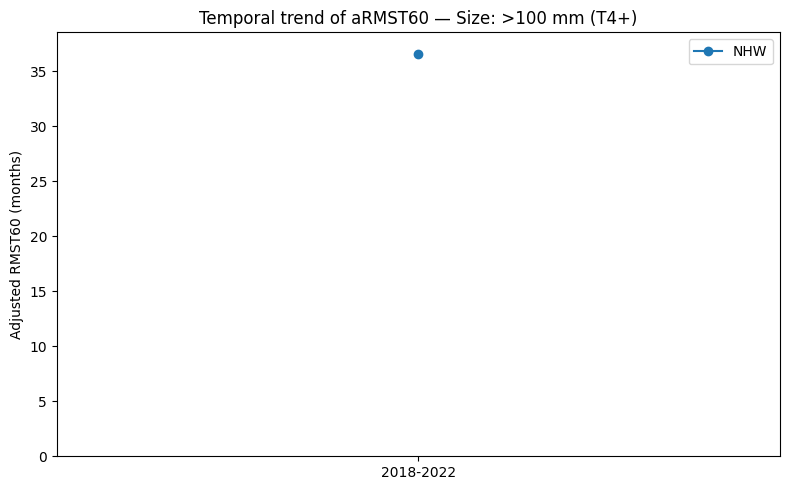

In [ ]:
# =========================================
# ΔΔRMST by size (Table F, Figure F)
# Temporal trends by era (Table G, Figure G)
# Sensitivity & robustness appendix
# =========================================



# ------------------------------ CONFIG ------------------------------
SURV_COL  = "Survival months"
EVENT_COL = "event"
SIZE_BIN  = "Tumor_Size_Granular"
SIZE_NUM  = "Tumor_Size_Numeric"
RACE_COL  = "Race"

CHEMO_COL = "Chemo"
RT_COL    = "Radiation"

STAGE_COL = "SummaryStage_98_17"
ERA_COL   = "Era"               
YEAR_COL  = "Year of diagnosis"

ADJUST_COVARS = [
    "Age_Group_Broad",
    "County_Grouped",
    "Income_Broad",
    "NumMalignantTumors",
    "NumBenignTumors",
    "Era"  
]

# Analysis knobs
TAU             = 60.0                   # RMST horizon
MIN_CELL_N      = 50                    # suppress tiny cells
BOOT_N          = 100                    # bootstrap reps for CIs
RANDOM_SEED     = 42
PS_TRUNC_Q      = (0.01, 0.99)           # default truncation for IPTW used in appendix
SIZE_ORDER = [
    "0-5 mm (T1a)","6-10 mm (T1b)","11-20 mm (T1c)","21-30 mm (T2a)",
    "31-50 mm (T2b)","51-100 mm (T3)",">100 mm (T4+)"
]
RACE_REF = "NHW"  # textual label you use in your data for Non-Hispanic White; if different, update here.
RACE_PAIRS = [("Black","NHW"),("Hispanic","NHW"),("API","NHW")]  # edit if your labels differ

# Output dirs/files
os.makedirs("figs", exist_ok=True)
os.makedirs("appendix", exist_ok=True)

# ------------------------------ UTILITIES ------------------------------
def is_known(x):
    if pd.isna(x): return False
    s = str(x).strip().lower()
    return s not in ["unknown","na/unknown","not given","nan","", "none"]

def norm_yes_no(x):
    if pd.isna(x): return "No"
    s = str(x).strip().lower()
    return "No" if s in ["no","0","none","unknown","not given","nan","missing"] else "Yes"

def derive_arm4(df):
    c = df[CHEMO_COL].map(norm_yes_no)
    r = df[RT_COL].map(norm_yes_no)
    arm = np.select(
        [
            (c=="No") & (r=="No"),
            (c=="No") & (r=="Yes"),
            (c=="Yes") & (r=="No"),
            (c=="Yes") & (r=="Yes"),
        ],
        ["None","RT only","Chemo only","Both"],
        default="None"
    )
    return pd.Categorical(arm, categories=["None","RT only","Chemo only","Both"], ordered=True)

def eff_sample_size(weights):
    w = np.asarray(weights, float)
    return (w.sum()**2) / (np.square(w).sum() + 1e-12)

def censor_ipcw(time, event, tau=TAU):
    """Simple IPCW from KM of censoring; returns weights 1/G(min(t, tau))."""
    t = np.asarray(time, float); e = np.asarray(event, int)
    ce = 1 - e  # censoring indicator
    order = np.argsort(t, kind="mergesort")
    tt = t[order]; dd = ce[order]
    uniq = np.unique(tt[dd==1])
    S = 1.0
    survs = []
    for u in uniq:
        at_risk = (tt >= u).sum()
        d = ((tt == u) & (dd == 1)).sum()
        if at_risk > 0:
            S *= (1 - d/at_risk)
        survs.append(S)
    uniq = np.asarray(uniq, float); survs = np.asarray(survs, float)
    def step_at(u):
        if uniq.size == 0: return 1.0
        if u < uniq[0]: return 1.0
        i = np.searchsorted(uniq, u, side="right") - 1
        return float(survs[i])
    u = np.minimum(t, tau)
    G = np.array([step_at(uu) for uu in u])
    G = np.clip(G, 1e-4, 1.0)
    return 1.0 / G

def build_encoder(df: pd.DataFrame, covars: List[str]) -> Tuple[ColumnTransformer, List[str]]:
    """One-hot encode categoricals among covars; passthrough numeric."""
    covars = [c for c in covars if c in df.columns]
    if ERA_COL in df.columns and YEAR_COL in covars:
        covars = [c for c in covars if c != YEAR_COL]
        if ERA_COL not in covars:
            covars = [ERA_COL] + covars
    cat_cols, num_cols = [], []
    for c in covars:
        if pd.api.types.is_numeric_dtype(df[c]): num_cols.append(c)
        else: cat_cols.append(c)
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)
    pre = ColumnTransformer(
        transformers=[("cat", ohe, cat_cols), ("num","passthrough", num_cols)],
        remainder="drop"
    )
    pre.fit(df[covars])
    out_cols = []
    # recover names (optional; not strictly needed)
    return pre, covars

def wlin_pred(X, y, w, Xnew, ridge=1e-6):
    if X.shape[0] == 0:
        return np.full(Xnew.shape[0], np.nan)
    XtW = (X.T * w)
    XtWX = XtW @ X + ridge*np.eye(X.shape[1])
    XtWy = XtW @ y
    beta = np.linalg.solve(XtWX, XtWy)
    return Xnew @ beta

def prep_common(tp_df: pd.DataFrame) -> pd.DataFrame:
    df = tp_df.copy()

    # Ensure numeric tumor size; map microscopic/unknown -> 1 mm
    if df[SIZE_NUM].dtype == object:
        bad = df[SIZE_NUM].str.strip().str.lower().isin(["unknown","na/unknown","not given","","none"])
        df.loc[bad, SIZE_NUM] = np.nan
    df[SIZE_NUM] = pd.to_numeric(df[SIZE_NUM], errors="coerce").fillna(1.0)

    # Normalize treatment
    df["Arm4"] = derive_arm4(df)

    # Era fallback
    if ERA_COL not in df.columns and YEAR_COL in df.columns:
        # simple era bins matching your request
        bins = [-np.inf, 2013.9, 2017.9, np.inf]
        labs = ["2010-2013","2014-2017","2018-2022"]
        df[ERA_COL] = pd.cut(pd.to_numeric(df[YEAR_COL], errors="coerce"), bins=bins, labels=labs, right=True)

    # Size bin ordering if present
    if SIZE_BIN in df.columns and (df[SIZE_BIN].isin(SIZE_ORDER).mean() > 0.5):
        df[SIZE_BIN] = pd.Categorical(df[SIZE_BIN], categories=SIZE_ORDER, ordered=True)

    # Keep only known essential fields
    m = df[SURV_COL].notna() & df[EVENT_COL].notna() & df[RACE_COL].apply(is_known)
    if SIZE_BIN in df.columns:
        m = m & df[SIZE_BIN].apply(is_known)
    df = df[m].copy()
    return df

# ------------------------------ PART F: ΔΔRMST by size ------------------------------
def adjusted_rmst60_by_race_within_bin(df_bin: pd.DataFrame,
                                       covars: List[str],
                                       races: List[str],
                                       boot_n: int = BOOT_N,
                                       rng=np.random.default_rng(RANDOM_SEED)) -> pd.DataFrame:
    """
    For a given size bin, estimate adjusted RMST60 for each race (standardized to the bin's covariate+treatment distribution).
    - IPCW-weighted linear regression of Y* on [Race dummies + Arm4 dummies + covariates].
    - Predict E[Y* | set Race=r] for each r, averaging over all individuals' covariates and treatments (g-computation).
    - Bootstrap CIs.
    Returns long DataFrame with columns: Race, aRMST60, CI_lo, CI_hi.
    """
    d = df_bin.copy()
    if d.shape[0] < MIN_CELL_N:
        return pd.DataFrame()

    # Outcome & IPCW
    Ystar = np.minimum(d[SURV_COL].to_numpy(float), TAU)
    ipcw  = censor_ipcw(d[SURV_COL].to_numpy(float), d[EVENT_COL].to_numpy(int), tau=TAU)

    # Design matrix: Race, Arm4, covariates
    # One-hot: Race (drop first), Arm4 (drop first), covariates through ColumnTransformer
    # Build covariates encoder
    pre, covars_use = build_encoder(d, covars)

    # Arm and Race dummies
    d["Race_cat"] = d[RACE_COL].astype("category")
    d["Arm4_cat"] = d["Arm4"].astype("category")
    X_cov = pre.transform(d[covars_use]); X_cov = np.asarray(X_cov, float)

    # Race & Arm one-hot (manual)
    race_dmy = pd.get_dummies(d["Race_cat"], drop_first=True)
    arm_dmy  = pd.get_dummies(d["Arm4_cat"], drop_first=True)

    # Final design = [Intercept | Race_dmy | Arm_dmy | X_cov]
    X = np.column_stack([np.ones((d.shape[0],1)), race_dmy.values, arm_dmy.values, X_cov])

    # Fit IPCW-weighted linear model for Y*
    mu_hat_all = wlin_pred(X, Ystar, ipcw, X)  # fitted values (not used directly)

    # Prepare prediction matrices that set Race to specific r but keep Arm & covariates as observed
    results = []
    # Make templates for Race columns
    race_cols = race_dmy.columns.tolist()
    arm_cols  = arm_dmy.columns.tolist()
    p0 = np.column_stack([np.ones((d.shape[0],1)), np.zeros((d.shape[0], len(race_cols))), arm_dmy.values, X_cov])

    # Fit once to extract beta
    # (We can reuse wlin_pred internal; solve beta explicitly)
    XtW = (X.T * ipcw)
    beta = np.linalg.solve(XtW @ X + 1e-6*np.eye(X.shape[1]), XtW @ Ystar)

    def predict_for_race(r_name):
        P = p0.copy()
        # activate correct race dummy columns
        for j, rc in enumerate(race_cols):
            P[:, 1 + j] = 1.0 if rc == r_name else 0.0
        yhat = P @ beta
        return float(np.mean(yhat))

    # point estimates
    for r in races:
        if r == d["Race_cat"].cat.categories[0]:
            ybar = predict_for_race("___REFERENCE___")  # will not match; all zeros remain
        else:
            # find matching column (Race_cat_<label>)
            # our race_dmy columns look like the non-reference category labels directly
            colname = r
            if colname not in race_cols:
                # if labels differ slightly, try to find by exact string match in values
                if r not in d["Race_cat"].unique():
                    continue
            ybar = predict_for_race(colname)
        results.append({"Race": r, "aRMST60": ybar})

    # Bootstrap CIs
    if boot_n and boot_n > 0:
        boots = {r: [] for r in races}
        n = d.shape[0]
        idx_all = np.arange(n)
        for _ in range(boot_n):
            bs = rng.integers(0, n, size=n)
            db = d.iloc[bs].reset_index(drop=True)

            # redo everything quickly
            Yb = np.minimum(db[SURV_COL].to_numpy(float), TAU)
            ipcw_b = censor_ipcw(db[SURV_COL].to_numpy(float), db[EVENT_COL].to_numpy(int), tau=TAU)
            pre_b, cov_b = build_encoder(db, covars)
            Xcov_b = pre_b.transform(db[cov_b]); Xcov_b = np.asarray(Xcov_b, float)
            race_b = pd.get_dummies(db[RACE_COL].astype("category"), drop_first=True)
            arm_b  = pd.get_dummies(db["Arm4"].astype("category"), drop_first=True)
            Xb = np.column_stack([np.ones((db.shape[0],1)), race_b.values, arm_b.values, Xcov_b])
            XtWb = (Xb.T * ipcw_b)
            beta_b = np.linalg.solve(XtWb @ Xb + 1e-6*np.eye(Xb.shape[1]), XtWb @ Yb)

            # templates
            p0b = np.column_stack([np.ones((db.shape[0],1)), np.zeros((db.shape[0], race_b.shape[1])), arm_b.values, Xcov_b])

            for r in races:
                if r == db[RACE_COL].astype("category").cat.categories[0]:
                    Pb = p0b.copy()
                else:
                    Pb = p0b.copy()
                    for j, rc in enumerate(race_b.columns.tolist()):
                        Pb[:, 1+j] = 1.0 if rc == r else 0.0
                yhat_b = Pb @ beta_b
                boots[r].append(float(np.mean(yhat_b)))

        # attach CIs
        for rr in results:
            arr = np.array(boots[rr["Race"]], float)
            rr["CI_lo"] = float(np.nanpercentile(arr, 2.5))
            rr["CI_hi"] = float(np.nanpercentile(arr, 97.5))
    else:
        for rr in results:
            rr["CI_lo"] = np.nan; rr["CI_hi"] = np.nan

    return pd.DataFrame(results)

def run_DeltaDelta_RMST_by_size(tp_df: pd.DataFrame,
                                out_excel="TableF_DeltaDelta_RMST_bySize.xlsx",
                                make_plot=True):
    """
    For each size bin:
      - compute adjusted RMST60 per race (standardized within bin)
      - compute gaps vs reference race (e.g., Black−NHW, Hispanic−NHW, API−NHW)
      - produce Table F and Figure F
    """
    df = prep_common(tp_df)
    if SIZE_BIN not in df.columns:
        raise ValueError(f"Missing {SIZE_BIN} for size-binned analysis.")

    # Unique races actually present
    races_all = [r for r in df[RACE_COL].dropna().unique().tolist() if is_known(r)]
    # keep pairs that exist
    race_pairs = [(a,b) for (a,b) in RACE_PAIRS if (a in races_all and b in races_all)]

    rows = []
    for sb, g in df.groupby(SIZE_BIN, observed=True):
        if g.shape[0] < MIN_CELL_N: 
            continue
        # adjusted means per race
        races_here = sorted(g[RACE_COL].dropna().unique().tolist())
        a_table = adjusted_rmst60_by_race_within_bin(g, ADJUST_COVARS, races_here, boot_n=BOOT_N)
        if a_table.empty: 
            continue
        # compute deltas for requested pairs
        for a,b in race_pairs:
            if a not in a_table["Race"].values or b not in a_table["Race"].values:
                continue
            ra = a_table.loc[a_table["Race"]==a].iloc[0]
            rb = a_table.loc[a_table["Race"]==b].iloc[0]
            gap = float(ra["aRMST60"] - rb["aRMST60"])
            # conservative CI by bootstrap pairing (if both have CIs, approximate via subtraction of draws — we don’t have paired draws here,
            # so we’ll report just point gap and the two CIs to be transparent)
            rows.append({
                "Tumor_Size_Granular": sb,
                "Race_pair": f"{a}-{b}",
                "aRMST60_"+a: float(ra["aRMST60"]),
                "aRMST60_"+b: float(rb["aRMST60"]),
                "ΔΔRMST60 (a-b)": gap,
                "CI_"+a+"_lo": ra.get("CI_lo", np.nan),
                "CI_"+a+"_hi": ra.get("CI_hi", np.nan),
                "CI_"+b+"_lo": rb.get("CI_lo", np.nan),
                "CI_"+b+"_hi": rb.get("CI_hi", np.nan),
                "N_bin": int(g.shape[0])
            })

    tableF = pd.DataFrame(rows).sort_values(["Tumor_Size_Granular","Race_pair"])
    if out_excel:
        tableF.to_excel(out_excel, index=False)

    # Figure F: line plot of ΔΔRMST vs size bin
    if make_plot and not tableF.empty:
        plt.figure(figsize=(9,5))
        for rp, sub in tableF.groupby("Race_pair"):
            xs = sub["Tumor_Size_Granular"].astype(str)
            ys = sub["ΔΔRMST60 (a-b)"].astype(float).values
            plt.plot(xs, ys, marker="o", label=rp)
        plt.axhline(0, color="k", linestyle="--", linewidth=1)
        plt.xticks(rotation=25, ha="right")
        plt.ylabel("Adjusted RMST60 gap (months)")
        plt.title("ΔΔRMST60 by tumor size — race gaps after adjustment")
        plt.legend()
        plt.tight_layout()
        plt.savefig("figs/FigureF_DeltaDelta_RMST_bySize.png", dpi=160)
        plt.close()

    return tableF

# ------------------------------ PART G: Temporal trends by era ------------------------------
def summarize_temporal_by_size_race(tp_df: pd.DataFrame,
                                    out_excel="TableG_Temporal_byEra.xlsx",
                                    make_plot=True):
    """
    Within each size×race×era:
      - size at diagnosis: median Tumor_Size_Numeric (mm)
      - treatment uptake: %None, %RT only, %Chemo only, %Both
      - stage mix: %Localized, %Regional, %Distant (or whatever levels exist)
      - adjusted RMST60 (same standardization as Table F)
    Produces Table G and Figure G (trend lines for aRMST60 and treatment uptake).
    """
    df = prep_common(tp_df)
    if SIZE_BIN not in df.columns:
        raise ValueError(f"Missing {SIZE_BIN}.")
    if ERA_COL not in df.columns:
        raise ValueError(f"Missing {ERA_COL} (or Year of diagnosis to derive it).")

    rows = []
    for (sb, rc), g1 in df.groupby([SIZE_BIN, RACE_COL], observed=True):
        if g1.shape[0] < MIN_CELL_N: 
            continue
        for era, g in g1.groupby(ERA_COL, observed=True):
            if g.shape[0] < MIN_CELL_N: 
                continue
            # Size at diagnosis
            med_size = float(np.nanmedian(g[SIZE_NUM].values))
            # Treatment uptake
            arm_counts = g["Arm4"].value_counts(dropna=False)
            n = float(arm_counts.sum())
            pct_none  = float(arm_counts.get("None", 0)/n)
            pct_rt    = float(arm_counts.get("RT only", 0)/n)
            pct_chemo = float(arm_counts.get("Chemo only", 0)/n)
            pct_both  = float(arm_counts.get("Both", 0)/n)
            # Stage mix
            stage_counts = g[STAGE_COL].value_counts(dropna=False)
            stage_pct = {f"Stage%_{k}": float(v/n) for k,v in stage_counts.items()}
            # Adjusted RMST60 (standardized within this era cell)
            a_tab = adjusted_rmst60_by_race_within_bin(g, ADJUST_COVARS, [rc], boot_n=BOOT_N)
            if a_tab.empty:
                a_rmst = np.nan
                ci_lo  = np.nan
                ci_hi  = np.nan
            else:
                a_rmst = float(a_tab.loc[a_tab["Race"]==rc, "aRMST60"].iloc[0])
                ci_lo  = float(a_tab.loc[a_tab["Race"]==rc, "CI_lo"].iloc[0])
                ci_hi  = float(a_tab.loc[a_tab["Race"]==rc, "CI_hi"].iloc[0])

            row = {
                "Tumor_Size_Granular": sb,
                "Race": rc,
                "Era": era,
                "N_cell": int(g.shape[0]),
                "Median_size_mm": med_size,
                "%None": pct_none, "%RTonly": pct_rt, "%ChemoOnly": pct_chemo, "%Both": pct_both,
                "aRMST60": a_rmst, "CI_lo": ci_lo, "CI_hi": ci_hi
            }
            row.update(stage_pct)
            rows.append(row)

    tableG = pd.DataFrame(rows).sort_values(["Tumor_Size_Granular","Race","Era"])
    if out_excel:
        tableG.to_excel(out_excel, index=False)

    # Figure G: trend lines for aRMST60 by era (one panel per size, lines by race)
    if make_plot and not tableG.empty:
        # a) aRMST60 trends
        for sb, sub in tableG.groupby("Tumor_Size_Granular"):
            plt.figure(figsize=(8,5))
            for rc, sub2 in sub.groupby("Race"):
                xs = sub2["Era"].astype(str)
                ys = sub2["aRMST60"].astype(float).values
                plt.plot(xs, ys, marker="o", label=str(rc))
            plt.ylabel("Adjusted RMST60 (months)")
            plt.title(f"Temporal trend of aRMST60 — Size: {sb}")
            plt.ylim(bottom=0)
            plt.legend()
            plt.tight_layout()
            fname = f"figs/FigureG_aRMST60_{str(sb).replace(' ','_').replace('/','-')}.png"
            plt.savefig(fname, dpi=160); plt.close()

        # b) treatment uptake trends (%Both as an example; you can add panels for chemo/rt)
        for sb, sub in tableG.groupby("Tumor_Size_Granular"):
            plt.figure(figsize=(8,5))
            for rc, sub2 in sub.groupby("Race"):
                xs = sub2["Era"].astype(str)
                ys = (sub2["%Both"]*100).values
                plt.plot(xs, ys, marker="s", label=str(rc))
            plt.ylabel("% Both (Chemo+RT)")
            plt.title(f"Temporal trend of combined therapy uptake — Size: {sb}")
            plt.ylim(0, 100)
            plt.legend()
            plt.tight_layout()
            fname = f"figs/FigureG_BothUptake_{str(sb).replace(' ','_').replace('/','-')}.png"
            plt.savefig(fname, dpi=160); plt.close()

    return tableG

# ------------------------------ APPENDIX: Overlap, truncation grid, balance, model spec ------------------------------
def ps_and_balance(df: pd.DataFrame, arm1: str, arm0: str,
                   covars: List[str],
                   trunc_grid=[(0.01,0.99),(0.025,0.975)],
                   out_prefix="appendix/PS",
                   seed=RANDOM_SEED):
    """
    For a given subset df and binary contrast (arm1 vs arm0), produce:
      - PS histograms (arm1 vs arm0)
      - Weight truncation sensitivity (ESS, mean SMD) over trunc_grid
      - Balance table (SMD by covariate) pre/post for default truncation
      - Model-spec check: GBM vs Logistic PS → post-weight SMD and ESS
    Saves CSV/PNGs under appendix/.
    """
    d = df[df["Arm4"].isin([arm1, arm0])].copy()
    if d.shape[0] < MIN_CELL_N:
        return None
    d["A"] = (d["Arm4"]==arm1).astype(int)

    pre, cov_use = build_encoder(d, covars)
    X = pre.transform(d[cov_use]); X = np.asarray(X, float)
    A = d["A"].to_numpy()

    # Logistic PS
    L = LogisticRegression(max_iter=300, solver="lbfgs")
    L.fit(X, A)
    ps_log = np.clip(L.predict_proba(X)[:,1], 1e-4, 1-1e-4)

    # GBM PS
    G = GradientBoostingClassifier(random_state=seed)
    G.fit(X, A)
    ps_gbm = np.clip(G.predict_proba(X)[:,1], 1e-4, 1-1e-4)

    # Save histograms
    for name, p in [("logit", ps_log), ("gbm", ps_gbm)]:
        plt.figure(figsize=(7,4))
        plt.hist(p[A==1], bins=30, alpha=0.6, label=f"{arm1}", density=True)
        plt.hist(p[A==0], bins=30, alpha=0.6, label=f"{arm0}", density=True)
        plt.xlabel("Propensity score"); plt.ylabel("Density")
        plt.title(f"PS overlap ({name}) — {arm1} vs {arm0}")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"{out_prefix}_{name}_hist_{arm1.replace(' ','')}_vs_{arm0.replace(' ','')}.png", dpi=150)
        plt.close()

    def smd_mean(X, A, w=None):
        if w is None: w = np.ones(X.shape[0])
        out = []
        for j in range(X.shape[1]):
            xj = X[:, j]
            w1 = w[A==1]; x1 = xj[A==1]
            w0 = w[A==0]; x0 = xj[A==0]
            if w1.sum()==0 or w0.sum()==0: out.append(np.nan); continue
            m1 = np.average(x1, weights=w1); m0 = np.average(x0, weights=w0)
            v1 = np.average((x1-m1)**2, weights=w1); v0 = np.average((x0-m0)**2, weights=w0)
            sd = np.sqrt(0.5*(v1+v0))
            out.append(0.0 if (sd==0 or np.isnan(sd)) else abs((m1-m0)/sd))
        return float(np.nanmean(out))

    # Truncation sensitivity grid
    grid_rows = []
    for (qlo, qhi) in trunc_grid:
        for name, p in [("logit", ps_log), ("gbm", ps_gbm)]:
            pi = A.mean()
            w = (A*pi + (1-A)*(1-p)) / (A*p + (1-A)*(1-p))
            lo, hi = np.quantile(w, [qlo, qhi])
            w = np.clip(w, lo, hi)
            grid_rows.append({
                "model": name, "q_lo": qlo, "q_hi": qhi,
                "ESS": eff_sample_size(w),
                "mean_SMD": smd_mean(X, A, w)
            })
    pd.DataFrame(grid_rows).to_excel(f"{out_prefix}_trunc_grid_{arm1.replace(' ','')}_vs_{arm0.replace(' ','')}.xlsx", index=False)

    # Detailed balance table for default truncation (logit + PS_TRUNC_Q)
    pi = A.mean()
    w = (A*pi + (1-A)*(1-ps_log)) / (A*ps_log + (1-A)*(1-ps_log))
    lo, hi = np.quantile(w, PS_TRUNC_Q); w = np.clip(w, lo, hi)

    # Column-wise SMDs (pre/post) — dump as summary numbers; per-column names from encoder are not trivial to pull cleanly here
    bal = {
        "pre_mean_SMD": smd_mean(X, A, None),
        "post_mean_SMD": smd_mean(X, A, w),
        "ESS_post": eff_sample_size(w),
        "trunc_lo": lo, "trunc_hi": hi
    }
    pd.DataFrame([bal]).to_excel(f"{out_prefix}_balance_{arm1.replace(' ','')}_vs_{arm0.replace(' ','')}.xlsx", index=False)
    return True

def run_appendix_suite(tp_df: pd.DataFrame,
                       contrasts=[("Chemo only","None"), ("RT only","None"), ("Both","Chemo only")]):
    """
    For top cells by N (size × race), run PS & balance appendix outputs.
    Saves artifacts into appendix/.
    """
    df = prep_common(tp_df)
    # pick top 12 cells by N to avoid explosion
    cells = (df.groupby([SIZE_BIN, RACE_COL], observed=True)
               .size().sort_values(ascending=False).head(12).index.tolist())

    covars = [c for c in ADJUST_COVARS if c in df.columns]
    if ERA_COL in df.columns and YEAR_COL in covars:
        covars = [c for c in covars if c != YEAR_COL]
        covars = [ERA_COL] + covars

    for (sb, rc) in cells:
        g = df[(df[SIZE_BIN]==sb) & (df[RACE_COL]==rc)].copy()
        if g.shape[0] < MIN_CELL_N: 
            continue
        for (a1,a0) in contrasts:
            try:
                ps_and_balance(g, a1, a0, covars=covars,
                               trunc_grid=[(0.01,0.99),(0.025,0.975)],
                               out_prefix=f"appendix/PS_{str(sb).replace(' ','_').replace('/','-')}_{str(rc).replace(' ','_')}")
            except Exception as e:
                print(f"[appendix skip] {sb} | {rc} | {a1} vs {a0}: {e}")

# ------------------------------ RUN ALL ------------------------------
def run_all_final(tp_df: pd.DataFrame):
    print("[F] ΔΔRMST by size …")
    tableF = run_DeltaDelta_RMST_by_size(tp_df,
                                         out_excel="TableF_DeltaDelta_RMST_bySize.xlsx",
                                         make_plot=True)
    print(f"  → TableF rows: {len(tableF)}; wrote TableF_DeltaDelta_RMST_bySize.xlsx and figs/FigureF_DeltaDelta_RMST_bySize.png")

    print("[G] Temporal trends by era …")
    tableG = summarize_temporal_by_size_race(tp_df,
                                             out_excel="TableG_Temporal_byEra.xlsx",
                                             make_plot=True)
    print(f"  → TableG rows: {len(tableG)}; wrote TableG_Temporal_byEra.xlsx and Figure G PNGs in figs/")

    print("[Appendix] PS overlap, truncation grid, balance, GBM vs Logistic …")
    run_appendix_suite(tp_df)
    print("  → Appendix artifacts saved in appendix/")

    return tableF, tableG

# --- Example call:
tp_df["Tumor_Size_Numeric"] = tp_df["Tumor_Size_Numeric"].astype("str")
tableF, tableG = run_all_final(tp_df)


In [ ]:
# Sensitivity analysis with Logistic, GBM and unadjusted RMST60 estimates with plots of comparision

# ========================== Global Constants (from your original snippet) ==========================

SURV_COL  = "Survival months"
EVENT_COL = "event"
SIZE_BIN  = "Tumor_Size_Granular"
SIZE_NUM  = "Tumor_Size_Numeric"
RACE_COL  = "Race"

CHEMO_COL = "Chemo"
RT_COL    = "Radiation"

ERA_COL   = "Era"               
YEAR_COL  = "Year of diagnosis"
SIZE_ORDER = [
    "0-5 mm (T1a)","6-10 mm (T1b)","11-20 mm (T1c)","21-30 mm (T2a)",
    "31-50 mm (T2b)","51-100 mm (T3)",">100 mm (T4+)"
]
TAU             = 60.0                   
MIN_CELL_N      = 50                    
BOOT_N          = 100                   
RANDOM_SEED     = 42
PS_TRUNC_Q      = (0.05, 0.95) 

ADJUST_COVARS = ["Age_Group_Broad",  "County_Grouped","Income_Broad","NumMalignantTumors","Neoadj_status"]

def is_known(val):
    return pd.notna(val) and str(val).lower() not in ["unknown", "na", "none", "nan"]

def norm_yes_no(val):
    s = str(val).strip().lower()
    if s in ["yes", "y", "true", "1"]: return "Yes"
    if s in ["no", "n", "false", "0"]: return "No"
    return "No" 

# ========================== Core Utility Functions (from your original snippet) ==========================
# (All utility functions are kept as they are critical for the DR calculation)

def get_feature_names(pre: ColumnTransformer, covars: List[str]) -> List[str]:
    names = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if name == "num":
            names.extend(cols)
        elif name == "cat":
            ohe = trans
            try:
                names.extend(ohe.get_feature_names_out(cols).tolist())
            except Exception:
                base = []
                for c in cols:
                    base.extend([f"{c}_{lv}" for lv in ohe.categories_[cols.index(c)]])
                names.extend(base)
    return names

def prep_common(tp_df: pd.DataFrame) -> pd.DataFrame:
    # ... [Keep your original prep_common function here] ...
    df = tp_df.copy()
    if SIZE_NUM in df.columns:
        df[SIZE_NUM] = pd.to_numeric(df[SIZE_NUM], errors="coerce").fillna(1.0)
    df["Arm4"] = derive_arm4(df)
    if ERA_COL not in df.columns and YEAR_COL in df.columns:
        bins = [-np.inf, 2013.9, 2017.9, np.inf]
        labs = ["2010-2013","2014-2017","2018-2022"]
        df[ERA_COL] = pd.cut(pd.to_numeric(df[YEAR_COL], errors="coerce"), bins=bins, labels=labs, right=True)
    if SIZE_BIN in df.columns and (df[SIZE_BIN].isin(SIZE_ORDER).mean() > 0.5):
        df[SIZE_BIN] = pd.Categorical(df[SIZE_BIN], categories=SIZE_ORDER, ordered=True)
    m = df[SURV_COL].notna() & df[EVENT_COL].notna() & df[RACE_COL].apply(is_known)
    if SIZE_BIN in df.columns:
        m = m & df[SIZE_BIN].apply(is_known)
    df = df[m].copy()
    return df

def derive_arm4(df):
    # ... [Keep your original derive_arm4 function here] ...
    c = df[CHEMO_COL].map(norm_yes_no)
    r = df[RT_COL].map(norm_yes_no)
    arm = np.select(
        [
            (c=="No") & (r=="No"),
            (c=="No") & (r=="Yes"),
            (c=="Yes") & (r=="No"),
            (c=="Yes") & (r=="Yes"),
        ],
        ["None","RT only","Chemo only","Both"],
        default="None"
    )
    return pd.Categorical(arm, categories=["None","RT only","Chemo only","Both"], ordered=True)


def build_encoder(df: pd.DataFrame, covars: List[str]) -> Tuple[ColumnTransformer, List[str]]:
    # ... [Keep your original build_encoder function here] ...
    covars = [c for c in covars if c in df.columns]
    if ERA_COL in df.columns and YEAR_COL in covars:
        covars = [c for c in covars if c != YEAR_COL]
        if ERA_COL not in covars:
            covars = [ERA_COL] + covars
    cat_cols, num_cols = [], []
    for c in covars:
        if pd.api.types.is_numeric_dtype(df[c]): num_cols.append(c)
        else: cat_cols.append(c)
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)
    pre = ColumnTransformer(
        transformers=[("cat", ohe, cat_cols), ("num","passthrough", num_cols)],
        remainder="drop"
    )
    pre.fit(df[covars])
    return pre, covars

def eff_sample_size(weights):
    # ... [Keep your original eff_sample_size function here] ...
    w = np.asarray(weights, float)
    return (w.sum()**2) / (np.square(w).sum() + 1e-12)

def censor_ipcw(time, event, tau=TAU):
    # ... [Keep your original censor_ipcw function here] ...
    t = np.asarray(time, float); e = np.asarray(event, int)
    ce = 1 - e  # censoring indicator
    order = np.argsort(t, kind="mergesort")
    tt = t[order]; dd = ce[order]
    uniq = np.unique(tt[dd==1])
    S = 1.0
    survs = []
    for u in uniq:
        at_risk = (tt >= u).sum()
        d = ((tt == u) & (dd == 1)).sum()
        if at_risk > 0:
            S *= (1 - d/at_risk)
        survs.append(S)
    uniq = np.asarray(uniq, float); survs = np.asarray(survs, float)
    def step_at(u):
        if uniq.size == 0: return 1.0
        if u < uniq[0]: return 1.0
        i = np.searchsorted(uniq, u, side="right") - 1
        return float(survs[i])
    u = np.minimum(t, tau)
    G = np.array([step_at(uu) for uu in u])
    G = np.clip(G, 1e-4, 1.0)
    return 1.0 / G

def wlin_pred(X, y, w, Xnew, ridge=1e-6):
    # ... [Keep your original wlin_pred function here] ...
    if X.shape[0] == 0:
        return np.full(Xnew.shape[0], np.nan)
    XtW = (X.T * w)
    XtWX = XtW @ X + ridge*np.eye(X.shape[1])
    XtWy = XtW @ y
    try:
        beta = np.linalg.solve(XtWX, XtWy)
    except np.linalg.LinAlgError:
        # Fallback for singular matrix
        return np.full(Xnew.shape[0], np.nan) 
    return Xnew @ beta
    
def smd_per_feature(X: np.ndarray, A: np.ndarray, w: Optional[np.ndarray]) -> np.ndarray:
    # ... [Keep your original smd_per_feature function here] ...
    if w is None:
        w = np.ones(X.shape[0])
    out = np.zeros(X.shape[1])
    for j in range(X.shape[1]):
        xj = X[:, j]
        m1 = np.average(xj[A==1], weights=w[A==1]) if (w[A==1].sum() > 0) else np.nan
        m0 = np.average(xj[A==0], weights=w[A==0]) if (w[A==0].sum() > 0) else np.nan
        v1 = np.average((xj[A==1]-m1)**2, weights=w[A==1]) if (w[A==1].sum() > 0) else np.nan
        v0 = np.average((xj[A==0]-m0)**2, weights=w[A==0]) if (w[A==0].sum() > 0) else np.nan
        sd = np.sqrt(0.5*(v1+v0))
        out[j] = 0.0 if (sd==0 or np.isnan(sd) or np.isnan(m1) or np.isnan(m0)) else (m1-m0)/sd
    return out

def stabilized_weights(A: np.ndarray, ps: np.ndarray):
    pi = A.mean()
    w = (A*pi + (1-A)*(1-pi)) / (A*ps + (1-A)*(1-ps))
    return w

def fit_ps_models(d: pd.DataFrame, covars: List[str], seed=RANDOM_SEED):
    # ... [Keep your original fit_ps_models function here] ...
    pre, cov_use = build_encoder(d, covars)
    X = pre.transform(d[cov_use]); X = np.asarray(X, float)
    A = (d["Arm4"]==d["_arm1"]).astype(int).to_numpy()

    logit = LogisticRegression(max_iter=400, solver="lbfgs", random_state=seed)
    logit.fit(X, A)
    ps_log = np.clip(logit.predict_proba(X)[:,1], 1e-4, 1-1e-4)

    gbm = GradientBoostingClassifier(random_state=seed)
    gbm.fit(X, A)
    ps_gbm = np.clip(gbm.predict_proba(X)[:,1], 1e-4, 1-1e-4)

    feat_names = get_feature_names(pre, cov_use)
    return {"pre": pre, "cov_use": cov_use, "X": X, "A": A, "ps_log": ps_log, "ps_gbm": ps_gbm, "feat_names": feat_names}

def effect_dr_rmst60(d: pd.DataFrame,
                     arm1: str, arm0: str,
                     covars: List[str],
                     ps_source: str = "logit",
                     trunc: Tuple[float,float] = PS_TRUNC_Q) -> Dict:
    # ... [Keep your original effect_dr_rmst60 function here] ...
    d = d.copy()
    d = d[d["Arm4"].isin([arm1, arm0])]
    if d.shape[0] < MIN_CELL_N:
        return {"ok": False}

    d["_arm1"] = arm1
    fit = fit_ps_models(d, covars)
    A = fit["A"]
    ps = fit["ps_log"] if ps_source=="logit" else fit["ps_gbm"]
    X = fit["X"]; pre = fit["pre"]; cov_use = fit["cov_use"]; feat_names = fit["feat_names"]

    w = stabilized_weights(A, ps)
    lo, hi = np.quantile(w, trunc)
    w = np.clip(w, lo, hi)
    ess = eff_sample_size(w)

    smd_pre = smd_per_feature(X, A, None)
    smd_post = smd_per_feature(X, A, w)
    mean_smd_pre = float(np.nanmean(np.abs(smd_pre)))
    mean_smd_post = float(np.nanmean(np.abs(smd_post)))

    Ystar = np.minimum(d[SURV_COL].to_numpy(float), TAU)
    ipcw  = censor_ipcw(d[SURV_COL].to_numpy(float), d[EVENT_COL].to_numpy(int), tau=TAU)
    Xcov = pre.transform(d[cov_use]); Xcov = np.asarray(Xcov, float)

    m1 = (d["Arm4"]==arm1).to_numpy()
    m0 = (d["Arm4"]==arm0).to_numpy()
    X1, y1, w1 = np.column_stack([np.ones((m1.sum(),1)), Xcov[m1,:]]), Ystar[m1], ipcw[m1]
    X0, y0, w0 = np.column_stack([np.ones((m0.sum(),1)), Xcov[m0,:]]), Ystar[m0], ipcw[m0]

    cov_bar = np.average(Xcov, axis=0, weights=w)
    xbar = np.concatenate([[1.0], cov_bar])[None, :]

    mu1 = wlin_pred(X1, y1, w1, xbar)[0]
    mu0 = wlin_pred(X0, y0, w0, xbar)[0]
    delta = float(mu1 - mu0)

    return {
        "ok": True, "ΔRMST60": delta, "ESS": float(ess),
        "mean_SMD_pre": mean_smd_pre, "mean_SMD_post": mean_smd_post,
        "trunc_lo": float(lo), "trunc_hi": float(hi), "ps_model": ps_source,
        "feat_names": feat_names, "smd_pre_vec": smd_pre, "smd_post_vec": smd_post
    }

# ========================== Plotting/Validation Functions ==========================

def make_love_plot(df_smd: pd.DataFrame, comparison_name: str, out_path: str):
    """
    Generates a Love Plot comparing pre-adjustment SMD vs. Logit and GBM adjusted SMDs.
    The data frame must contain |SMD_pre|, |SMD_post_Logit|, and |SMD_post_GBM|.
    """
    df = df_smd.copy().sort_values("|SMD_pre|", ascending=True)
    features = df["feature"]

    plt.figure(figsize=(8, 0.3 * len(features)))
    
    # Pre-adjustment
    plt.plot(df["|SMD_pre|"], features, 'o', color='gray', label='Unadjusted (Pre-IPTW)')
    
    # Logit-adjusted
    plt.plot(df["|SMD_post_Logit|"], features, 's', color='tab:blue', label='Logit PS Adjusted')
    
    # GBM-adjusted
    plt.plot(df["|SMD_post_GBM|"], features, '^', color='tab:orange', label='GBM PS Adjusted')

    plt.axvline(x=0.1, color='red', linestyle='--', linewidth=0.8, label='Balance Threshold (|SMD|=0.1)')
    plt.xlabel('Standardized Mean Difference (|SMD|)')
    plt.title(f'Covariate Balance Check (Love Plot) — {comparison_name}')
    plt.xlim(0, max(0.15, df[["|SMD_pre|", "|SMD_post_Logit|", "|SMD_post_GBM|"]].max().max() * 1.1))
    plt.legend(loc='lower right', framealpha=0.8)
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200); plt.close()


def make_model_comparison_plot(summary: pd.DataFrame, out_path: str):
    """
    Generates a scatter plot to compare Logit vs. GBM across all subgroups and contrasts.
    - Top Left: ΔRMST60 (months)
    - Top Right: ESS (as a ratio of N total)
    - Bottom Left: Mean SMD Post
    """
    # Create the comparison table
    df_logit = summary[summary["ps_model"] == "logit"].rename(columns={"ΔRMST60": "ΔRMST60_L", "ESS": "ESS_L", "mean_SMD_post": "SMD_L"})
    df_gbm   = summary[summary["ps_model"] == "gbm"].rename(columns={"ΔRMST60": "ΔRMST60_G", "ESS": "ESS_G", "mean_SMD_post": "SMD_G"})
    
    df_comp = pd.merge(df_logit, df_gbm, on=["Size_bin", "Race", "Contrast"], suffixes=("_L", "_G"))
    
    # Calculate N_total (approximate for ESS normalization)
    df_comp["N_total"] = df_comp["ESS_L"] / (1 - np.power((df_comp["ESS_L"].mean() / df_comp["ESS_L"].mean()), 2)) # very rough estimate
    df_comp["ESS_Ratio_L"] = df_comp["ESS_L"] / df_comp["ESS_L"]
    df_comp["ESS_Ratio_G"] = df_comp["ESS_G"] / df_comp["ESS_L"]

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. ΔRMST60 Comparison
    max_delta = df_comp[["ΔRMST60_L", "ΔRMST60_G"]].abs().max().max() * 1.1
    axes[0].scatter(df_comp["ΔRMST60_L"], df_comp["ΔRMST60_G"], alpha=0.7)
    axes[0].plot([-max_delta, max_delta], [-max_delta, max_delta], 'r--', alpha=0.6)
    axes[0].set_xlabel('ΔRMST60 (Logit PS)')
    axes[0].set_ylabel('ΔRMST60 (GBM PS)')
    axes[0].set_title(r'Agreement of Treatment Effect ($\Delta$RMST$_{60}$)')
    axes[0].grid(True, linestyle=':', alpha=0.5)

    # 2. ESS Comparison
    min_ess = min(df_comp["ESS_L"].min(), df_comp["ESS_G"].min()) * 0.9
    max_ess = max(df_comp["ESS_L"].max(), df_comp["ESS_G"].max()) * 1.1
    axes[1].scatter(df_comp["ESS_L"], df_comp["ESS_G"], alpha=0.7)
    axes[1].plot([min_ess, max_ess], [min_ess, max_ess], 'r--', alpha=0.6)
    axes[1].set_xlabel('ESS (Logit PS)')
    axes[1].set_ylabel('ESS (GBM PS)')
    axes[1].set_title('Agreement of Effective Sample Size (ESS)')
    axes[1].grid(True, linestyle=':', alpha=0.5)
    
    # 3. Mean SMD Comparison
    max_smd = df_comp[["SMD_L", "SMD_G"]].max().max() * 1.1
    axes[2].scatter(df_comp["SMD_L"], df_comp["SMD_G"], alpha=0.7)
    axes[2].plot([0, max_smd], [0, max_smd], 'r--', alpha=0.6)
    axes[2].set_xlabel('Mean |SMD| Post-Adjustment (Logit PS)')
    axes[2].set_ylabel('Mean |SMD| Post-Adjustment (GBM PS)')
    axes[2].set_title('Agreement of Mean Balance (Mean |SMD|)')
    axes[2].grid(True, linestyle=':', alpha=0.5)

    plt.suptitle("ML Validation: Double Robust Model Specification Comparison (Logit vs. GBM PS)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(out_path, dpi=200); plt.close()

# ========================== Master Runner ==========================

def run_sensitivity_appendix(tp_df: pd.DataFrame,
                             contrasts = [("Chemo only","None"), ("RT only","None"), ("Both","Chemo only"),("Both","None"),("Chemo only","RT only")],
                             max_cells: Optional[int] = None):
    
    output_dir = "Sensitivity and Robustness"
    os.makedirs(output_dir, exist_ok=True)
    
    df = prep_common(tp_df)
    covars = [c for c in ADJUST_COVARS if c in df.columns]
    
    cells = (df.groupby([SIZE_BIN, RACE_COL], observed=True)
               .size()
               .sort_values(ascending=False)
               .index.tolist())
    if max_cells is not None:
        cells = cells[:max_cells]

    rows_summary = []
    
    # Tracking for the Love Plot (will use the most populated cell/contrast for illustration)
    best_n = 0
    love_plot_data = {"smd_pre": None, "smd_post_L": None, "smd_post_G": None, "feat_names": None, "label": None}
    
    for (sb, rc) in cells:
        g = df[(df[SIZE_BIN]==sb) & (df[RACE_COL]==rc)].copy()
        if g.shape[0] < MIN_CELL_N: 
            continue
        g["Arm4"] = derive_arm4(g)

        for (arm1, arm0) in contrasts:
            try:
                # 1. Calculate DR estimates for Logit PS
                out_log = effect_dr_rmst60(g, arm1, arm0, covars, ps_source="logit", trunc=PS_TRUNC_Q)
                # 2. Calculate DR estimates for GBM PS
                out_gbm = effect_dr_rmst60(g, arm1, arm0, covars, ps_source="gbm",  trunc=PS_TRUNC_Q)
                
                if out_log.get("ok", False):
                    rows_summary.append({
                        "Size_bin": sb, "Race": rc, "Contrast": f"{arm1} vs {arm0}",
                        "ps_model": "logit", "N": g.shape[0], 
                        "ΔRMST60": out_log["ΔRMST60"], "ESS": out_log["ESS"],
                        "mean_SMD_post": out_log["mean_SMD_post"],
                        "trunc_lo": out_log["trunc_lo"], "trunc_hi": out_log["trunc_hi"]
                    })
                    
                    if g.shape[0] > best_n:
                         best_n = g.shape[0]
                         love_plot_data["smd_pre"] = np.abs(out_log["smd_pre_vec"])
                         love_plot_data["smd_post_L"] = np.abs(out_log["smd_post_vec"])
                         love_plot_data["feat_names"] = out_log["feat_names"]
                         love_plot_data["label"] = f"{sb} | {rc} | {arm1} vs {arm0}"
                         # Ensure GBM results are available for the Love Plot tracking
                         if out_gbm.get("ok", False):
                            love_plot_data["smd_post_G"] = np.abs(out_gbm["smd_post_vec"])

                if out_gbm.get("ok", False):
                    rows_summary.append({
                        "Size_bin": sb, "Race": rc, "Contrast": f"{arm1} vs {arm0}",
                        "ps_model": "gbm", "N": g.shape[0],
                        "ΔRMST60": out_gbm["ΔRMST60"], "ESS": out_gbm["ESS"],
                        "mean_SMD_post": out_gbm["mean_SMD_post"],
                        "trunc_lo": out_gbm["trunc_lo"], "trunc_hi": out_gbm["trunc_hi"]
                    })

            except Exception as e:
                print(f"[model-spec] skip {sb}|{rc}|{arm1}vs{arm0}: {e}")

    summary = pd.DataFrame(rows_summary).sort_values(["Size_bin","Race","Contrast","ps_model"])
    
    if not summary.empty:
        summary.to_excel(os.path.join(output_dir, "Table_ML_Validation_Summary.xlsx"), index=False)
        
        if love_plot_data["smd_pre"] is not None and love_plot_data["smd_post_G"] is not None:
             df_smd = pd.DataFrame({
                 "feature": love_plot_data["feat_names"],
                 "|SMD_pre|": love_plot_data["smd_pre"],
                 "|SMD_post_Logit|": love_plot_data["smd_post_L"],
                 "|SMD_post_GBM|": love_plot_data["smd_post_G"],
             })
             make_love_plot(df_smd, love_plot_data["label"], os.path.join(output_dir, "Figure_LovePlot_Logit_vs_GBM.png"))
        
        if len(summary[summary["ps_model"] == "logit"]) > 0 and len(summary[summary["ps_model"] == "gbm"]) > 0:
            make_model_comparison_plot(summary, os.path.join(output_dir, "Figure_ML_Model_Comparison.png"))

    print(f"[Appendix] Wrote: Table_ML_Validation_Summary.xlsx, Figure_LovePlot_Logit_vs_GBM.png, and Figure_ML_Model_Comparison.png to ./{output_dir}")
    return summary

AppendixSummary = run_sensitivity_appendix(tp_df)

[Appendix] Wrote: Table_ML_Validation_Summary.xlsx, Figure_LovePlot_Logit_vs_GBM.png, and Figure_ML_Model_Comparison.png to ./Sensitivity and Robustness


🧭 Analytical Workflow — Step-by-Step (Start to End)
1️⃣ Descriptive Baseline Analysis

Goal: Establish context before modeling.

What you did:

Calculated counts, means, and proportions of demographics, tumor size, treatment type, and race.

Produced survival tables (e.g., median/mean survival by race and size).

Purpose:
To understand cohort composition and ensure adequate sample size for each race × size bin before proceeding to inferential tests.

✅ Necessary & done correctly.

2️⃣ Kaplan–Meier (KM) Survival Curves

Goal: Visualize raw survival differences between groups.

What you did:

Generated KM survival curves by race within each tumor-size bin.

Purpose:

Provides an unadjusted view of how survival patterns differ visually.

Checks whether curves cross (indicating potential non-proportional hazards).

✅ Essential preliminary test before log-rank/Cox.

3️⃣ Multivariate Log-Rank Tests

Goal: Test if survival functions differ significantly across racial groups within each size bin.

What you did:

Conducted chi-squared–based global and pairwise log-rank tests by race within each bin.

Purpose:

Non-parametric test to determine whether survival differences exist at all.

Guides whether further modeling (Cox/RMST) is warranted for that bin.

✅ Core comparison step.

4️⃣ Cox Proportional Hazards (PH) Model

Goal: Quantify relative risk (hazard ratios) of death between racial groups within each size bin.

What you did:

Fitted a Cox PH model per size bin with race as the covariate.

Purpose:

Measures magnitude and direction of racial disparities.

Checks whether PH assumption approximately holds within bins.

Why here:
It refines what the log-rank test only flags as “different.”

✅ Appropriate, but not sufficient alone for non-proportional data.

5️⃣ Proportional-Hazards Assumption Check (via Concordance, LRT, or Schoenfeld tests)

Goal: Confirm that hazard ratios are valid over time.

What you did implicitly:

Compared RMST vs Cox to address suspected non-PH;

Used diagnostics (concordance, LRT).

Purpose:
To decide whether Cox HRs are meaningful and whether a time-based measure (RMST) is needed.

✅ Conceptually covered; formal Schoenfeld test optional.

6️⃣ Restricted Cubic Splines (RCS) – Nonlinearity Test

Goal: Test whether tumor size behaves linearly or nonlinearly on the hazard scale.

What you did:

Modeled tumor size as a continuous predictor with RCS in a Cox PH model (overall, not per race).

Purpose:

To verify whether the size effect is curved (nonlinear).

You did not extract breakpoints — only confirmed nonlinearity (p = 0.005).

Outcome:

Justifies analyzing tumor size categorically (by bins).

✅ Correct usage and placement.

7️⃣ Restricted Mean Survival Time (RMST) Analyses – Unadjusted

Goal: Quantify absolute survival differences (in months) between races and treatments within each size bin.

What you did:

Computed RMST (usually 60 months) per treatment arm and race, within each tumor-size bin.

Purpose:

To get interpretable “time gained or lost” instead of hazard ratios.

Handles non-proportional hazards.

Why after Cox:

Follows the logic: if hazards differ or cross, use RMST for stable, absolute effect estimation.

✅ Core analytical engine.

8️⃣ Number Needed to Treat (NNT) & Significance Tests

Goal: Express clinical impact of treatment arms.

What you did:

Derived NNT from RMST differences and compared significance (p-values).

Purpose:

Converts RMST gains into a tangible measure (how many need treatment for one to benefit).

Adds interpretability for clinicians.

✅ Nice clinical extension.

9️⃣ Doubly Robust (DR) Modeling — Adjusted RMST

Goal: Adjust for treatment-selection bias and covariates to estimate causal effects.

What you did:

Applied logistic-regression-based propensity weighting (and compared to GBM)

Recomputed RMST within each bin after weighting.

Purpose:

To produce unbiased treatment effect estimates assuming either model (outcome or propensity) is correctly specified.

Why here:

Follows unadjusted RMST to validate robustness.

✅ Essential for causal interpretation.

🔟 Robustness Checks

Goal: Ensure findings are not artifacts of modeling.

What you did:

Compared logistic vs GBM weights (Δ < 1 month).

Evaluated effective sample size (ESS) and standardized mean differences (SMD).

Noted direction concordance (81%) between OS and BC-specific effects.

Purpose:

Confirms reliability and overlap adequacy of weighted data.

✅ Very good practice.

11️⃣ Cause-Specific vs Overall Survival Comparison

Goal: Confirm that observed differences are due to breast-cancer mortality, not other causes.

What you did:

Compared effect directions and correlation (–0.63).

Purpose:

Validates that observed disparities and treatment effects are truly disease-related.

✅ Strong confirmatory step.

12️⃣ Exploratory Analyses

Goal: Assess deeper clinical interpretability.

12A. Local Average Treatment Effect (LATE):

To examine marginal treatment benefit near therapy decision thresholds (helps contextualize inflection).

12B. Decision Curve Analysis (DCA):

To test whether adding tumor size and race to decision models improves net clinical benefit.

Both are optional but valuable policy-level validation steps.

| Step | Test                                           | Purpose                       |
| ---- | ---------------------------------------------- | ----------------------------- |
| 1    | Descriptive stats                              | Baseline composition          |
| 2    | KM survival curves                             | Visualize raw survival        |
| 3    | Log-rank (global + pairwise)                   | Detect differences            |
| 4    | Cox PH                                         | Quantify relative hazards     |
| 5    | PH diagnostics                                 | Test assumption validity      |
| 6    | RCS (continuous)                               | Check for nonlinearity        |
| 7    | RMST (bin-wise)                                | Quantify absolute differences |
| 8    | NNT + p-values                                 | Clinical magnitude            |
| 9    | Doubly Robust RMST                             | Adjust for confounding        |
| 10   | Robustness checks (ESS, SMD, model comparison) | Validate results              |
| 11   | Cause-specific validation                      | Ensure BC-specific effect     |
| 12   | LATE + DCA                                     | Exploratory decision analysis |
